<a href="https://colab.research.google.com/github/VanesssaRS/Tesis-desarrollo/blob/main/Actualiza_dependencias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis previo

In [ ]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime

def obtener_fecha_commit(url_repositorio):
    """
    Obtiene la fecha del último commit de un repositorio en GitHub utilizando la API de GitHub.
    """
    # Obtener el nombre del repositorio y usuario/organización
    repositorio = url_repositorio.split("/")[-1]
    usuario = url_repositorio.split("/")[3]

    # URL de la API para obtener el último commit
    api_url = f"https://api.github.com/repos/{usuario}/{repositorio}/commits"

    # Realizar la solicitud GET
    response = requests.get(api_url)

    if response.status_code == 200:
        commits = response.json()
        # Obtener la fecha del último commit
        if commits:
            fecha_commit = commits[0]['commit']['committer']['date']
            return fecha_commit
    else:
        print(f"Error al obtener los commits para {url_repositorio}: {response.status_code}")
    return None

def obtener_dependencias(url_repositorio):
    # Extraer el nombre del repositorio de la URL (tomamos el último segmento después del "/")
    repositorio = url_repositorio.split("/")[-1]
    usuario = url_repositorio.split("/")[3]  # Extraemos el nombre del usuario u organización

    # Intentamos primero en la rama master, luego en la rama main
    ramas_posibles = ['master', 'main']

    for rama in ramas_posibles:
        url_pom = f"https://raw.githubusercontent.com/{usuario}/{repositorio}/{rama}/pom.xml"
        print(f"Intentando acceder a: {url_pom}")

        # Realizar una solicitud HTTP para obtener el archivo pom.xml
        response = requests.get(url_pom)

        if response.status_code == 200:
            # Parsear el contenido XML
            xml_content = response.content.decode('utf-8')  # Asegurarse de que el archivo se decodifica correctamente
            tree = ET.ElementTree(ET.fromstring(xml_content))
            root = tree.getroot()
            #tree = ET.ElementTree(ET.fromstring(response.text))
            #root = tree.getroot()

            if response.status_code == 200:
              try:
                # Decodificar el contenido y parsear el XML
                xml_content = response.content.decode('utf-8')  # Asegurarse de que el archivo se decodifica correctamente
                tree = ET.ElementTree(ET.fromstring(xml_content))
                root = tree.getroot()

                # El espacio de nombres en el XML
                namespaces = {'maven': 'http://maven.apache.org/POM/4.0.0'}

                # Obtener las propiedades del pom.xml
                properties = {}
                properties_element = root.find('.//maven:properties', namespaces)
                if properties_element is not None:
                    for prop in properties_element:
                        properties[prop.tag.split('}')[1]] = prop.text  # Guardar las propiedades

                # Obtener la versión del proyecto desde <version> en la raíz del proyecto
                version_proyecto = root.find('maven:version', namespaces)
                if version_proyecto is not None:
                    properties['project.version'] = version_proyecto.text  # Agregar la versión del proyecto como propiedad

                # Obtener la fecha del último commit
                fecha_commit = obtener_fecha_commit(url_repositorio)

                # Encontrar todas las dependencias
                dependencias = []
                for dependency in root.findall('.//maven:dependency', namespaces):  # Buscar con espacio de nombres
                    group_id = dependency.find('maven:groupId', namespaces).text if dependency.find('maven:groupId', namespaces) is not None else ''
                    artifact_id = dependency.find('maven:artifactId', namespaces).text if dependency.find('maven:artifactId', namespaces) is not None else ''
                    version = dependency.find('maven:version', namespaces).text if dependency.find('maven:version', namespaces) is not None else ''

                    # Resolver la propiedad en la versión si contiene una propiedad
                    if version and '${' in version:
                        # Buscar la propiedad y reemplazarla
                        for key, value in properties.items():
                          if value:
                            version = version.replace(f"${{{key}}}", value)

                    dependencias.append({'url_repositorio': url_repositorio,'groupId': group_id, 'artifactId': artifact_id, 'version': version, 'fecha_commit': fecha_commit})

                return dependencias
              except ET.ParseError as e:
                print(f"Error al parsear el XML para {url_pom}: {e}")
                return None

    # Si no se pudo acceder a ninguna de las ramas posibles
    print(f"No se pudo encontrar pom.xml en ninguna de las ramas comunes para {url_repositorio}")
    return None

# Leer el dataset desde el archivo CSV
df = pd.read_csv("/content/maven.csv")

# Lista para almacenar todas las dependencias
todas_dependencias = []

# Recorremos cada fila del dataframe y obtenemos las dependencias
for index, row in df.iterrows():
    url_repositorio = row['url']
    print(f"Extrayendo dependencias para el repositorio: {url_repositorio}")

    dependencias = obtener_dependencias(url_repositorio)

    if dependencias:
        print(f"Dependencias encontradas para {url_repositorio}:")
        todas_dependencias.extend(dependencias)  # Añadir las dependencias de este repositorio a la lista total
        for dep in dependencias:
            print(f"Grupo: {dep['groupId']}, Artefacto: {dep['artifactId']}, Versión: {dep['version']}, Fecha Commit: {dep['fecha_commit']}")
    else:
        print(f"No se pudieron obtener dependencias para {url_repositorio}")

    print("="*40)  # Separador entre repositorios

# Crear un dataframe con todas las dependencias encontradas
df_dependencias = pd.DataFrame(todas_dependencias)

# Guardar las dependencias en un archivo CSV
df_dependencias.to_csv("dependencias_maven.csv", index=False)

print(f"Archivo de dependencias generado: dependencias_maven.csv")


Extrayendo dependencias para el repositorio: https://github.com/apache/maven
Intentando acceder a: https://raw.githubusercontent.com/apache/maven/master/pom.xml
Dependencias encontradas para https://github.com/apache/maven:
Grupo: org.apache.maven, Artefacto: maven-artifact, Versión: 4.0.0-rc-2-SNAPSHOT, Fecha Commit: 2024-12-04T16:54:29Z
Grupo: org.apache.maven, Artefacto: maven-builder-support, Versión: 4.0.0-rc-2-SNAPSHOT, Fecha Commit: 2024-12-04T16:54:29Z
Grupo: org.apache.maven, Artefacto: maven-jline, Versión: 4.0.0-rc-2-SNAPSHOT, Fecha Commit: 2024-12-04T16:54:29Z
Grupo: org.apache.maven, Artefacto: maven-logging, Versión: 4.0.0-rc-2-SNAPSHOT, Fecha Commit: 2024-12-04T16:54:29Z
Grupo: org.apache.maven, Artefacto: maven-core, Versión: 4.0.0-rc-2-SNAPSHOT, Fecha Commit: 2024-12-04T16:54:29Z
Grupo: org.apache.maven, Artefacto: maven-impl, Versión: 4.0.0-rc-2-SNAPSHOT, Fecha Commit: 2024-12-04T16:54:29Z
Grupo: org.apache.maven, Artefacto: maven-embedder, Versión: 4.0.0-rc-2-SNAPSHO

**Análisis de la Distribución de Dependencias**

-----------------------------------------------------------------------
Dependencias cargadas
-----------------------------------------------------------------------


url_repositorio           groupId             artifactId  \
0  https://github.com/apache/maven  org.apache.maven         maven-artifact   
1  https://github.com/apache/maven  org.apache.maven  maven-builder-support   
2  https://github.com/apache/maven  org.apache.maven            maven-jline   
3  https://github.com/apache/maven  org.apache.maven          maven-logging   
4  https://github.com/apache/maven  org.apache.maven             maven-core   

               version          fecha_commit  
0  4.0.0-rc-2-SNAPSHOT  2024-12-04T16:54:29Z  
1  4.0.0-rc-2-SNAPSHOT  2024-12-04T16:54:29Z  
2  4.0.0-rc-2-SNAPSHOT  2024-12-04T16:54:29Z  
3  4.0.0-rc-2-SNAPSHOT  2024-12-04T16:54:29Z  
4  4.0.0-rc-2-SNAPSHOT  2024-12-04T16:54:29Z

-----------------------------------------------------------------------
Dependencias comunes
-----------------------------------------------------------------------


groupId                artifactId  Frecuencia
109               org.apache.maven                maven-core          29
117               org.apache.maven          maven-plugin-api          25
303                    org.mockito              mockito-core          21
68                           junit                     junit          19
145  org.apache.maven.plugin-tools  maven-plugin-annotations          18
115               org.apache.maven               maven-model          18
105               org.apache.maven            maven-artifact          17
219            org.codehaus.plexus              plexus-utils          16
108               org.apache.maven              maven-compat          16
198                    org.assertj              assertj-core          15

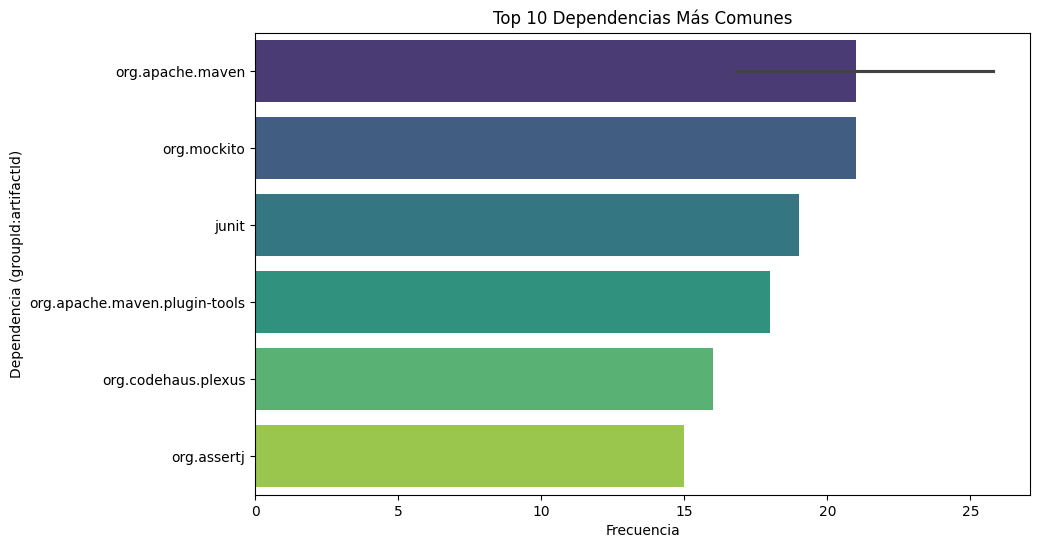

-----------------------------------------------------------------------
Dependencias y versiones comunes
-----------------------------------------------------------------------


groupId                    artifactId version  \
339                      org.assertj                  assertj-core  3.26.3   
238  org.apache.maven.plugin-testing  maven-plugin-testing-harness   3.3.0   
85                             junit                         junit  4.13.2   
157                 org.apache.maven                    maven-core   3.6.3   
137                 org.apache.maven                maven-artifact   3.6.3   
181                 org.apache.maven                   maven-model   3.6.3   
81                      javax.inject                  javax.inject       1   
192                 org.apache.maven              maven-plugin-api   3.6.3   
147                 org.apache.maven                  maven-compat   3.6.3   
209                 org.apache.maven                maven-settings   3.6.3   

     Frecuencia  
339          11  
238          11  
85           11  
157          10  
137          10  
181          10  
81           10  
192          10  
147           8  
209           7

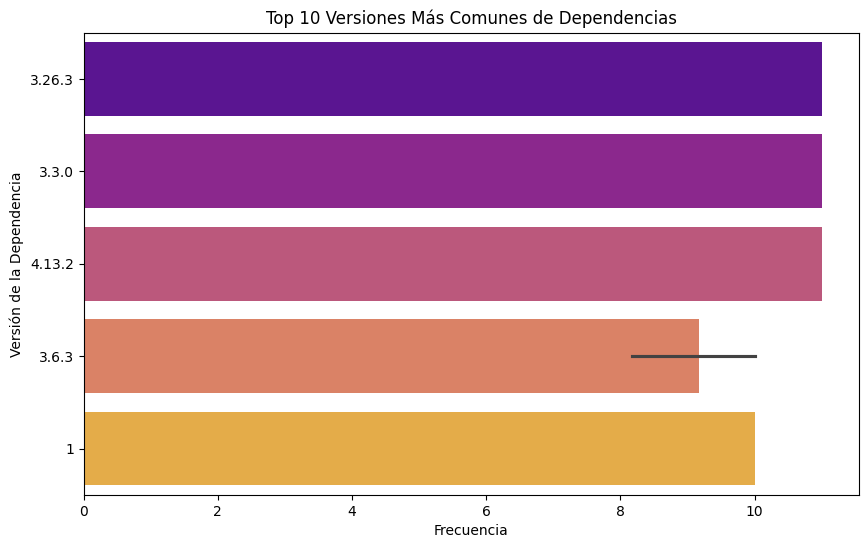

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

# Paso 1: Cargar el dataset de dependencias (ajusta la ruta a tu archivo)
df_dependencias = pd.read_csv("/content/dependencias_maven.csv")

# Verificamos las primeras filas del dataset para entender su estructura
print("-----------------------------------------------------------------------")
print("Dependencias cargadas")
print("-----------------------------------------------------------------------")
display(df_dependencias.head(5))

# Paso 2: Contar las dependencias más comunes
# Agrupamos por 'groupId' y 'artifactId' y contamos cuántas veces se repiten
dependencias_comunes = df_dependencias.groupby(['groupId', 'artifactId']).size().reset_index(name='Frecuencia')

# Ordenamos por frecuencia descendente
dependencias_comunes = dependencias_comunes.sort_values(by='Frecuencia', ascending=False)

# Mostramos las 10 dependencias más comunes
print("-----------------------------------------------------------------------")
print("Dependencias comunes")
print("-----------------------------------------------------------------------")
display(dependencias_comunes.head(10))

# Paso 3: Visualización de la distribución
# Graficamos las 10 dependencias más frecuentes
plt.figure(figsize=(10, 6))
sns.barplot(x='Frecuencia', y='groupId', hue="groupId", data=dependencias_comunes.head(10), palette='viridis')
plt.title('Top 10 Dependencias Más Comunes')
plt.xlabel('Frecuencia')
plt.ylabel('Dependencia (groupId:artifactId)')
plt.show()

# Paso 4: Análisis de versiones más comunes
# Agrupamos por 'groupId', 'artifactId' y 'version' y contamos cuántas veces aparece cada combinación
dependencias_versiones = df_dependencias.groupby(['groupId', 'artifactId', 'version']).size().reset_index(name='Frecuencia')

# Ordenamos por frecuencia descendente
dependencias_versiones = dependencias_versiones.sort_values(by='Frecuencia', ascending=False)

# Mostramos las 10 combinaciones de dependencia y versión más comunes
print("-----------------------------------------------------------------------")
print("Dependencias y versiones comunes")
print("-----------------------------------------------------------------------")
display(dependencias_versiones.head(10))

# Graficamos las 10 versiones más comunes de las dependencias
plt.figure(figsize=(10, 6))
sns.barplot(x='Frecuencia', y='version', hue="version", data=dependencias_versiones.head(10), palette='plasma')
plt.title('Top 10 Versiones Más Comunes de Dependencias')
plt.xlabel('Frecuencia')
plt.ylabel('Versión de la Dependencia')
plt.show()


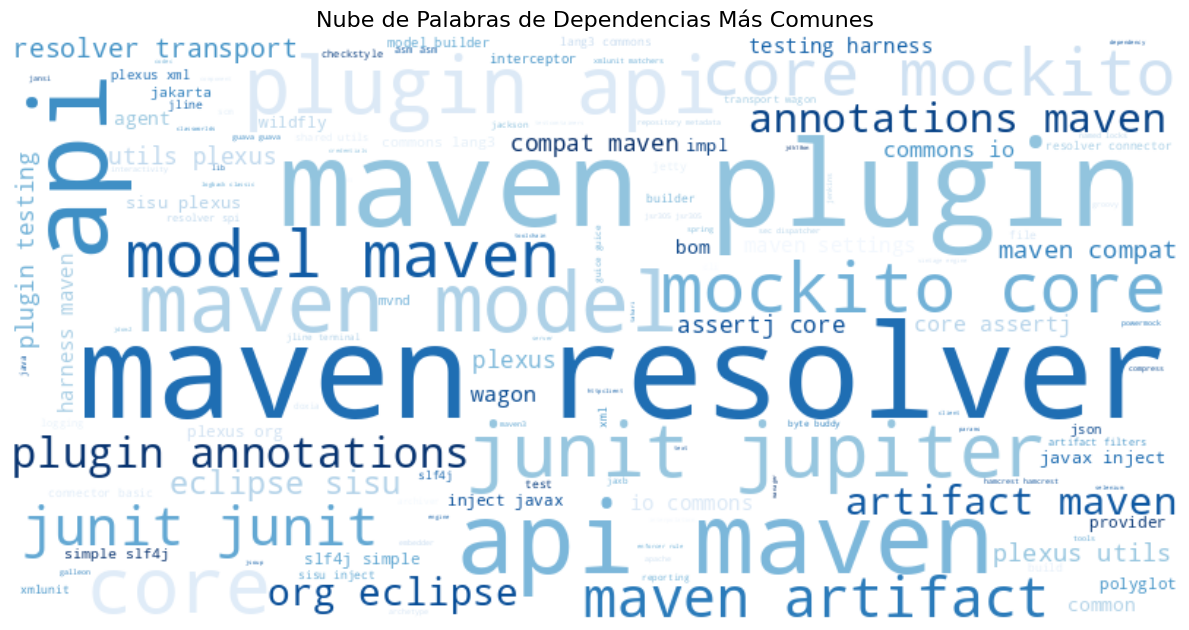

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Primero, seleccionamos la columna que queremos usar, ya sea 'groupId' o 'artifactId'.
# En este caso, vamos a usar 'artifactId' para generar la nube de palabras de las dependencias más comunes.

# Contamos la frecuencia de las dependencias más comunes
frecuencia_dependencias = df_dependencias['artifactId'].value_counts()

# Creamos la cadena de texto necesaria para la nube de palabras
texto_dependencias = ' '.join(f"{dep} " * freq for dep, freq in frecuencia_dependencias.items())

# Generamos la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(texto_dependencias)

# Mostramos la imagen de la nube de palabras
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No mostrar los ejes
plt.title('Nube de Palabras de Dependencias Más Comunes', fontsize=16)
plt.tight_layout()
plt.show()

**Análisis de la Evolución de las Dependencias**

-----------------------------------------------------------------------
Dependencias cargadas
-----------------------------------------------------------------------


url_repositorio           groupId             artifactId  \
0  https://github.com/apache/maven  org.apache.maven         maven-artifact   
1  https://github.com/apache/maven  org.apache.maven  maven-builder-support   
2  https://github.com/apache/maven  org.apache.maven            maven-jline   
3  https://github.com/apache/maven  org.apache.maven          maven-logging   
4  https://github.com/apache/maven  org.apache.maven             maven-core   

               version          fecha_commit  
0  4.0.0-rc-2-SNAPSHOT  2024-12-04T16:54:29Z  
1  4.0.0-rc-2-SNAPSHOT  2024-12-04T16:54:29Z  
2  4.0.0-rc-2-SNAPSHOT  2024-12-04T16:54:29Z  
3  4.0.0-rc-2-SNAPSHOT  2024-12-04T16:54:29Z  
4  4.0.0-rc-2-SNAPSHOT  2024-12-04T16:54:29Z

-----------------------------------------------------------------------
Dependencias evolucionadas
-----------------------------------------------------------------------


fecha_commit                   groupId   version  Frecuencia
0 2021-08-13 14:46:04      com.puppycrawl.tools      8.43           1
1 2021-08-13 14:46:04           javafx-packager       1.8           1
2 2021-08-13 14:46:04          org.apache.maven     3.5.2           2
3 2022-10-05 00:46:51  backport-util-concurrent       3.1           1
4 2022-10-05 00:46:51          com.google.guava  31.1-jre           1

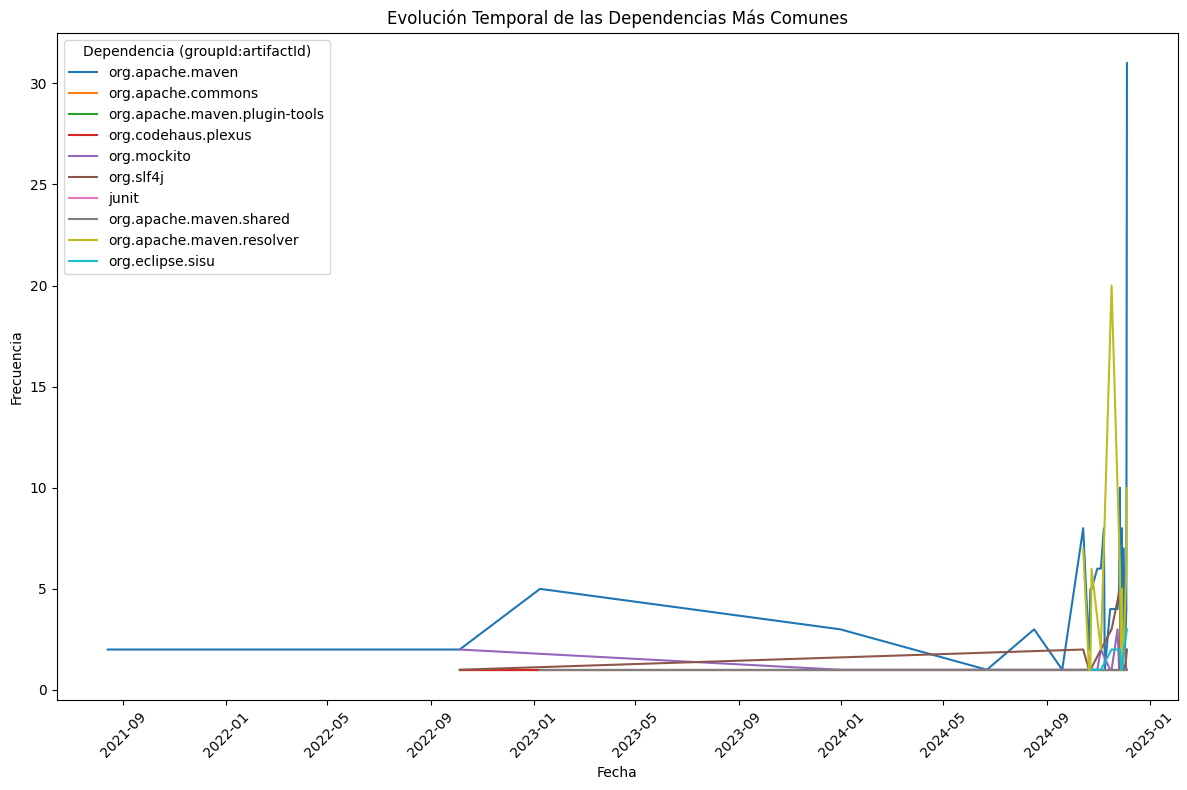

Dependencias añadidas y eliminadas:
Empty DataFrame
Columns: [groupId, artifactId, version, fecha_inicio, fecha_fin]
Index: []


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


# Paso 1: Cargar el dataset de dependencias (ajusta la ruta a tu archivo)
df_dependencias = pd.read_csv("dependencias_maven.csv")

# Verificamos las primeras filas del dataset para entender su estructura
print("-----------------------------------------------------------------------")
print("Dependencias cargadas")
print("-----------------------------------------------------------------------")
display(df_dependencias.head())

# Supongamos que tenemos una columna 'fecha' que tiene la fecha de cada versión
# Si no tienes esta columna, debes agregarla a partir de las fechas de los commits o versiones

# Paso 2: Análisis de la evolución de versiones de dependencias
# Primero aseguramos que las fechas estén en formato de fecha
#df_dependencias['fecha'] = pd.to_datetime(df_dependencias['fecha_commit'])

# Agrupamos por 'fecha' y 'groupId', 'artifactId' y 'version' para contar cuántas veces aparece cada combinación
#evolucion_dependencias = df_dependencias.groupby([df_dependencias['fecha'].dt.to_period('M'), 'groupId', 'artifactId', 'version']).size().reset_index(name='Frecuencia')

# Asegurarse de que la columna 'fecha_commit' sea tipo datetime
df_dependencias['fecha_commit'] = pd.to_datetime(df_dependencias['fecha_commit'])



# Eliminar la zona horaria (en caso de que esté presente) antes de convertir a periodo mensual
df_dependencias['fecha_commit'] = df_dependencias['fecha_commit'].dt.tz_localize(None)

# Agrupar por fecha (periodo mensual), groupId, artifactId y version
evolucion_dependencias = df_dependencias.groupby([df_dependencias['fecha_commit'], 'groupId',  'version']).size().reset_index(name='Frecuencia') #'artifactId',

# Mostramos las primeras filas del resultado
print("-----------------------------------------------------------------------")
print("Dependencias evolucionadas")
print("-----------------------------------------------------------------------")
display(evolucion_dependencias.head())

# Paso 3: Visualización de la evolución de dependencias más comunes
# Filtramos para obtener las 10 dependencias más comunes en el dataset
dependencias_comunes = df_dependencias.groupby(['groupId']).size().reset_index(name='Frecuencia') #, 'artifactId'
dependencias_comunes = dependencias_comunes.sort_values(by='Frecuencia', ascending=False)

# Tomamos las 10 dependencias más comunes
top_dependencias = dependencias_comunes.head(10)

# Ahora filtramos el dataset de evolución para estas dependencias
evolucion_top_dependencias = evolucion_dependencias[evolucion_dependencias['groupId'].isin(top_dependencias['groupId'])] #&
                                                   #evolucion_dependencias['artifactId'].isin(top_dependencias['artifactId'])]

# Graficamos la evolución de las 10 dependencias más comunes
plt.figure(figsize=(12, 8))
sns.lineplot(x='fecha_commit', y='Frecuencia', hue='groupId', data=evolucion_top_dependencias) #, style='artifactId'
plt.title('Evolución Temporal de las Dependencias Más Comunes')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.legend(title='Dependencia (groupId:artifactId)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Paso 4: Análisis de aparición y desaparición de dependencias
# Filtramos las dependencias que aparecieron y desaparecieron entre las versiones
# Esto lo podemos hacer observando las diferencias en las fechas para cada dependencia

# Agrupamos las dependencias por 'groupId', 'artifactId' y 'version' y comparamos entre fechas
apertura_dependencias = df_dependencias.groupby(['groupId', 'artifactId', 'version']).agg({'fecha_commit': ['min', 'max']}).reset_index()
apertura_dependencias.columns = ['groupId', 'artifactId', 'version', 'fecha_inicio', 'fecha_fin']

# Filtramos las dependencias que han sido eliminadas (es decir, no han aparecido más después de una fecha)
eliminacion_dependencias = apertura_dependencias[apertura_dependencias['fecha_fin'].isna()]

# Mostramos las dependencias que han sido añadidas y eliminadas
print("Dependencias añadidas y eliminadas:")
print(eliminacion_dependencias)


**Compatibilidad de Dependencias**

-----------------------------------------------------
Dependencias con versiones conflictivas:
-----------------------------------------------------


groupId             artifactId  version
4                ch.qos.logback        logback-classic        3
9    com.fasterxml.jackson.core       jackson-databind        2
15     com.google.code.findbugs                 jsr305        2
16         com.google.code.gson                   gson        2
17             com.google.guava                  guava        3
..                          ...                    ...      ...
306                 org.ow2.asm                    asm        4
307                 org.ow2.asm            asm-commons        2
319                   org.slf4j              slf4j-api        3
322                   org.slf4j           slf4j-simple        2
325         org.sonatype.plexus  plexus-sec-dispatcher        2

[84 rows x 3 columns]

-----------------------------------------------------
Detalle de las dependencias conflictivas:
-----------------------------------------------------


url_repositorio  \
0                 https://github.com/apache/maven   
1                 https://github.com/apache/maven   
2                 https://github.com/apache/maven   
3                 https://github.com/apache/maven   
4                 https://github.com/apache/maven   
..                                            ...   
512  https://github.com/apache/maven-shade-plugin   
513  https://github.com/apache/maven-shade-plugin   
514  https://github.com/apache/maven-shade-plugin   
515  https://github.com/apache/maven-shade-plugin   
516  https://github.com/apache/maven-shade-plugin   

                             groupId                    artifactId  \
0                   org.apache.maven                maven-artifact   
1                   org.apache.maven                   maven-jline   
2                   org.apache.maven                 maven-logging   
3                   org.apache.maven                    maven-core   
4                   org.apache.maven                maven-embedder   
..                               ...                           ...   
512                     org.hamcrest                 hamcrest-core   
513                      org.mockito                  mockito-core   
514                        org.slf4j                  slf4j-simple   
515                 org.apache.maven                  maven-compat   
516  org.apache.maven.plugin-testing  maven-plugin-testing-harness   

                 version        fecha_commit  
0    4.0.0-rc-2-SNAPSHOT 2024-12-04 16:54:29  
1    4.0.0-rc-2-SNAPSHOT 2024-12-04 16:54:29  
2    4.0.0-rc-2-SNAPSHOT 2024-12-04 16:54:29  
3    4.0.0-rc-2-SNAPSHOT 2024-12-04 16:54:29  
4    4.0.0-rc-2-SNAPSHOT 2024-12-04 16:54:29  
..                   ...                 ...  
512                  2.2 2024-11-27 08:48:12  
513               3.12.4 2024-11-27 08:48:12  
514               1.7.36 2024-11-27 08:48:12  
515                3.9.7 2024-11-27 08:48:12  
516                3.3.0 2024-11-27 08:48:12  

[517 rows x 5 columns]

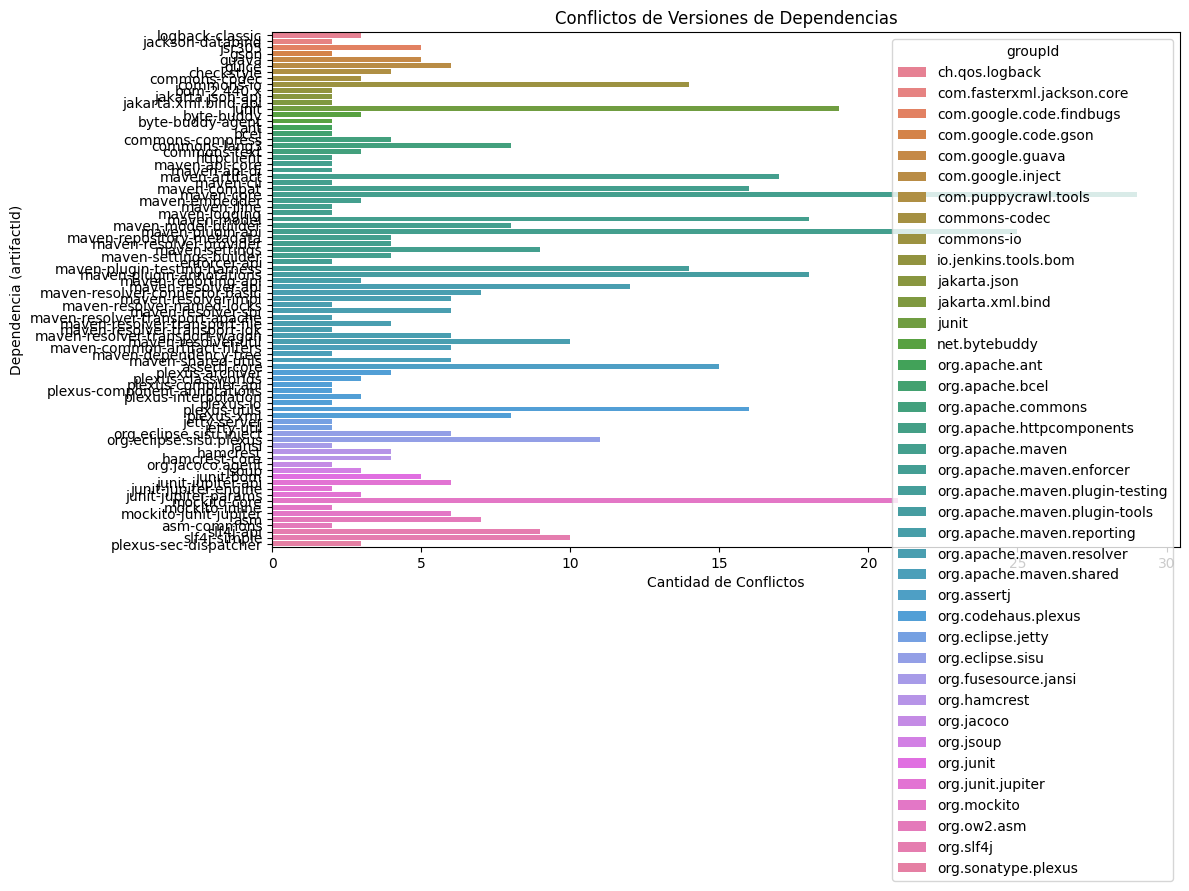

In [ ]:
import pandas as pd

# Suponiendo que el dataframe 'df_dependencias' tiene las columnas 'groupId', 'artifactId', y 'version'
# Detectamos las dependencias con el mismo 'groupId' y 'artifactId', pero versiones diferentes
conflictos_dependencias = df_dependencias.groupby(['groupId', 'artifactId'])['version'].nunique().reset_index()

# Filtramos aquellos casos donde hay más de una versión para la misma combinación de 'groupId' y 'artifactId'
conflictos_dependencias = conflictos_dependencias[conflictos_dependencias['version'] > 1]

# Mostrar los conflictos de dependencias
print("-----------------------------------------------------")
print("Dependencias con versiones conflictivas:")
print("-----------------------------------------------------")
display(conflictos_dependencias)

# Ahora, podemos también crear una lista con los detalles de las dependencias conflictivas
conflictos_detalle = df_dependencias.merge(conflictos_dependencias[['groupId', 'artifactId']], on=['groupId', 'artifactId'])

# Mostrar las dependencias conflictivas detalladas
print("-----------------------------------------------------")
print("Detalle de las dependencias conflictivas:")
print("-----------------------------------------------------")
display(conflictos_detalle)

# Crear una tabla o gráfico para visualizar los conflictos de dependencias
import matplotlib.pyplot as plt
import seaborn as sns

# Contar cuántos conflictos hay por 'groupId' y 'artifactId'
conflictos_resumen = conflictos_detalle.groupby(['groupId', 'artifactId']).size().reset_index(name='Cantidad de Conflictos')

# Graficar los conflictos de dependencias
plt.figure(figsize=(12, 8))
sns.barplot(x='Cantidad de Conflictos', y='artifactId', data=conflictos_resumen, hue='groupId')
plt.title('Conflictos de Versiones de Dependencias')
plt.xlabel('Cantidad de Conflictos')
plt.ylabel('Dependencia (artifactId)')
plt.tight_layout()
plt.show()

**Identificación de Dependencias Obsoletas**

In [ ]:
import requests
import pandas as pd

# Función para obtener la última versión disponible de una dependencia desde Maven Central
def obtener_ultima_version(group_id, artifact_id):
    url = f'https://search.maven.org/solrsearch/select?q=g:{group_id}+AND+a:{artifact_id}&rows=1&wt=json'
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        docs = data['response']['docs']
        if docs:
            return docs[0]['latestVersion']
    return None

# Ejemplo de cómo usar esta función para obtener versiones de dependencias
dependencias_obsoletas = []

# Suponiendo que tienes un DataFrame con dependencias
df_dependencias = pd.read_csv('dependencias_maven.csv')

# Comprobar si la versión de cada dependencia es la más reciente
for index, row in df_dependencias.iterrows():
    group_id = row['groupId']
    artifact_id = row['artifactId']
    version_local = row['version']

    # Obtener la última versión disponible
    ultima_version = obtener_ultima_version(group_id, artifact_id)

    if ultima_version and ultima_version != version_local:
        dependencias_obsoletas.append({
            'groupId': group_id,
            'artifactId': artifact_id,
            'version_local': version_local,
            'ultima_version': ultima_version
        })

# Crear un DataFrame con las dependencias obsoletas
df_dependencias_obsoletas = pd.DataFrame(dependencias_obsoletas)

# Mostrar las dependencias obsoletas
print(df_dependencias_obsoletas)

# Guardar las dependencias obsoletas en un archivo CSV
df_dependencias_obsoletas.to_csv('dependencias_obsoletas.csv', index=False)

                             groupId                    artifactId  \
0                   org.apache.maven                maven-artifact   
1                   org.apache.maven         maven-builder-support   
2                   org.apache.maven                   maven-jline   
3                   org.apache.maven                 maven-logging   
4                   org.apache.maven                    maven-core   
..                               ...                           ...   
537                     org.hamcrest                 hamcrest-core   
538                      org.mockito                  mockito-core   
539                        org.slf4j                  slf4j-simple   
540                 org.apache.maven                  maven-compat   
541  org.apache.maven.plugin-testing  maven-plugin-testing-harness   

           version_local ultima_version  
0    4.0.0-rc-2-SNAPSHOT     4.0.0-rc-1  
1    4.0.0-rc-2-SNAPSHOT     4.0.0-rc-1  
2    4.0.0-rc-2-SNAPSHOT     4.0.

<ipython-input-6-58b7230c182c>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


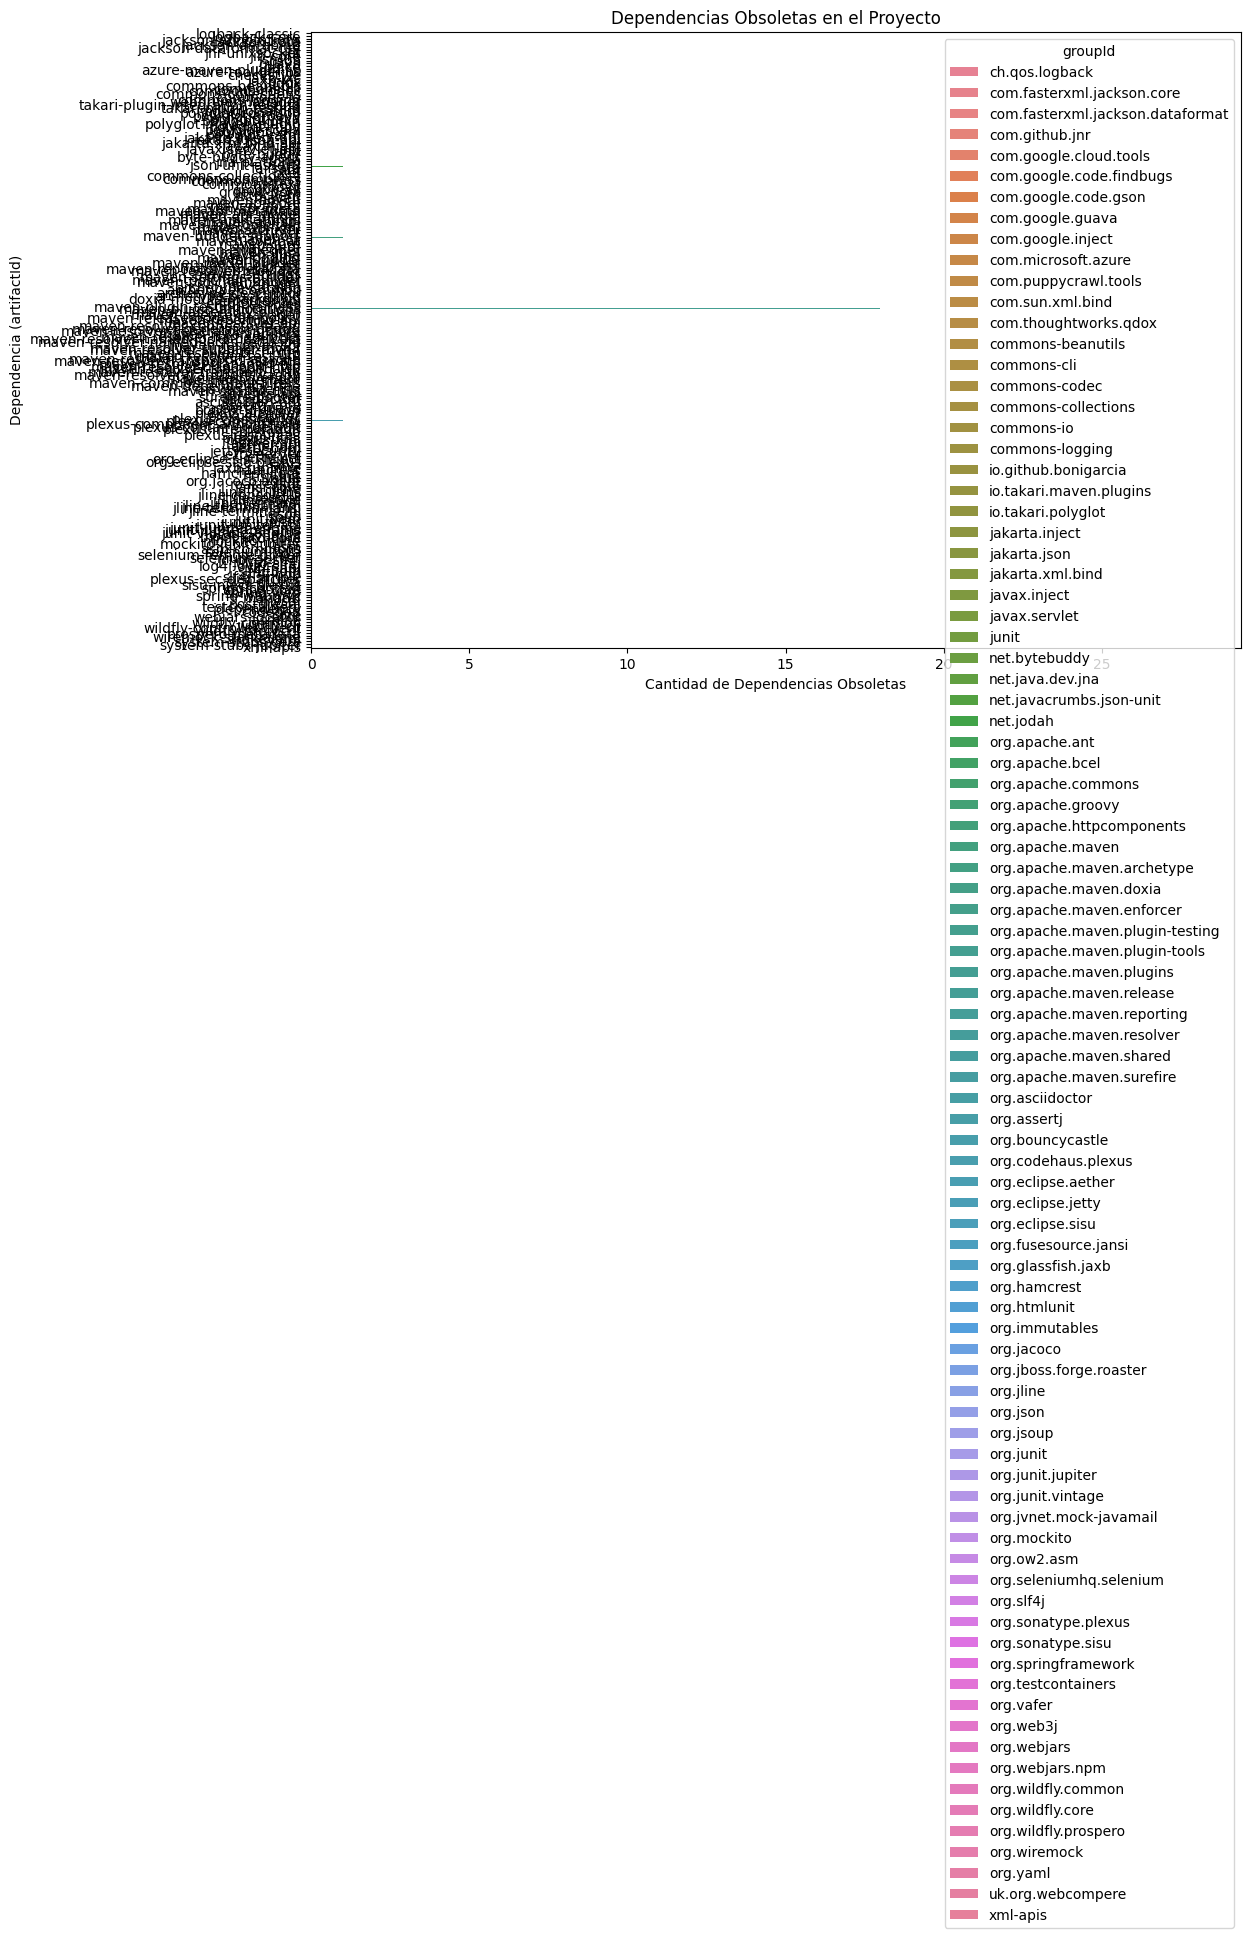

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Contamos cuántas dependencias obsoletas hay por 'groupId' o 'artifactId'
obsoletas_resumen = df_dependencias_obsoletas.groupby(['groupId', 'artifactId']).size().reset_index(name='Cantidad')

# Graficamos la cantidad de dependencias obsoletas
plt.figure(figsize=(12, 8))
sns.barplot(x='Cantidad', y='artifactId', data=obsoletas_resumen, hue='groupId')
plt.title('Dependencias Obsoletas en el Proyecto')
plt.xlabel('Cantidad de Dependencias Obsoletas')
plt.ylabel('Dependencia (artifactId)')
plt.tight_layout()
plt.show()


**Análisis de la Relación entre Dependencias**

In [ ]:
import pandas as pd
import itertools
import numpy as np

# Cargar el dataset de dependencias
df_dependencias = pd.read_csv('dependencias_maven.csv')

# Crear una lista para almacenar las dependencias por proyecto
proyectos_dependencias = {}

# Agrupar dependencias por 'url_repositorio' (proyecto)
for index, row in df_dependencias.iterrows():
    repositorio = row['url_repositorio']
    group_artifact = (row['groupId'], row['artifactId'])

    if repositorio not in proyectos_dependencias:
        proyectos_dependencias[repositorio] = []
    proyectos_dependencias[repositorio].append(group_artifact)

# Crear una lista para almacenar las relaciones (pares de dependencias que coexisten en el mismo proyecto)
relaciones = []

# Recorrer los proyectos y sus dependencias
for dependencias in proyectos_dependencias.values():
    # Crear todas las combinaciones posibles de dependencias que coexisten en el mismo proyecto
    for pair in itertools.combinations(set(dependencias), 2):
        relaciones.append(pair)

# Crear un DataFrame de las relaciones
df_relaciones = pd.DataFrame(relaciones, columns=['Dependencia_1', 'Dependencia_2'])

# Contar cuántas veces cada par de dependencias coexiste
matriz_relaciones = df_relaciones.groupby(['Dependencia_1', 'Dependencia_2']).size().reset_index(name='Co-ocurrencias')

# Convertir la matriz a formato de matriz de co-ocurrencias
matriz_coocurrencias = matriz_relaciones.pivot_table(index='Dependencia_1', columns='Dependencia_2', values='Co-ocurrencias', fill_value=0)

# Mostrar la matriz de co-ocurrencias
print(matriz_coocurrencias)

Dependencia_2                                       (${project.groupId}, ${project.artifactId})  \
Dependencia_1                                                                                     
(${project.groupId}, ${project.artifactId})                                                 0.0   
(${project.groupId}, git-commit-id-plugin-core)                                             0.0   
(${project.groupId}, wildfly-plugin-core)                                                   0.0   
(backport-util-concurrent, backport-util-concur...                                          0.0   
(ch.qos.logback, logback-classic)                                                           0.0   
...                                                                                         ...   
(uk.org.lidalia, slf4j-test)                                                                0.0   
(uk.org.webcompere, system-stubs-core)                                                      0.0   
(uk.org.we

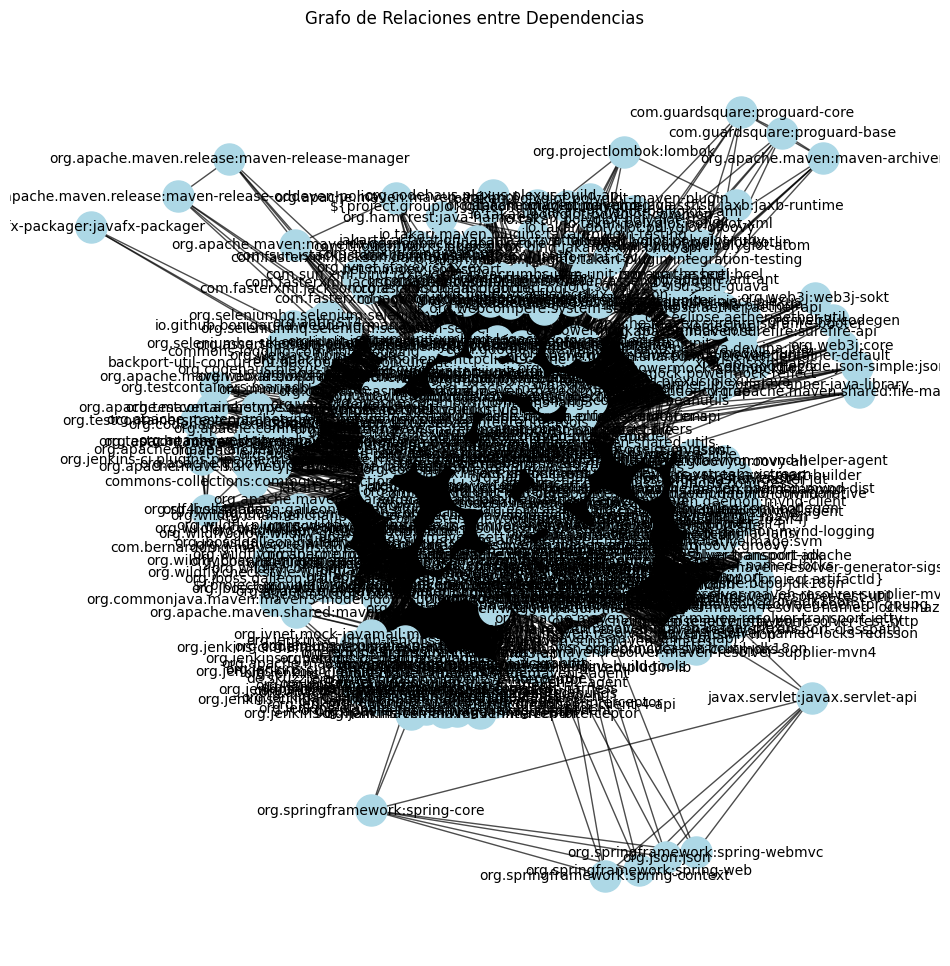

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear el grafo
G = nx.Graph()

# Añadir nodos (dependencias) al grafo
for dep in df_dependencias[['groupId', 'artifactId']].drop_duplicates().values:
    G.add_node(f"{dep[0]}:{dep[1]}")

# Añadir las relaciones (aristas) entre las dependencias al grafo
for pair in relaciones:
    dep_1 = f"{pair[0][0]}:{pair[0][1]}"
    dep_2 = f"{pair[1][0]}:{pair[1][1]}"
    G.add_edge(dep_1, dep_2)

# Visualizar el grafo
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, iterations=20)  # Posicionamiento de los nodos
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Grafo de Relaciones entre Dependencias")
plt.axis('off')
plt.show()

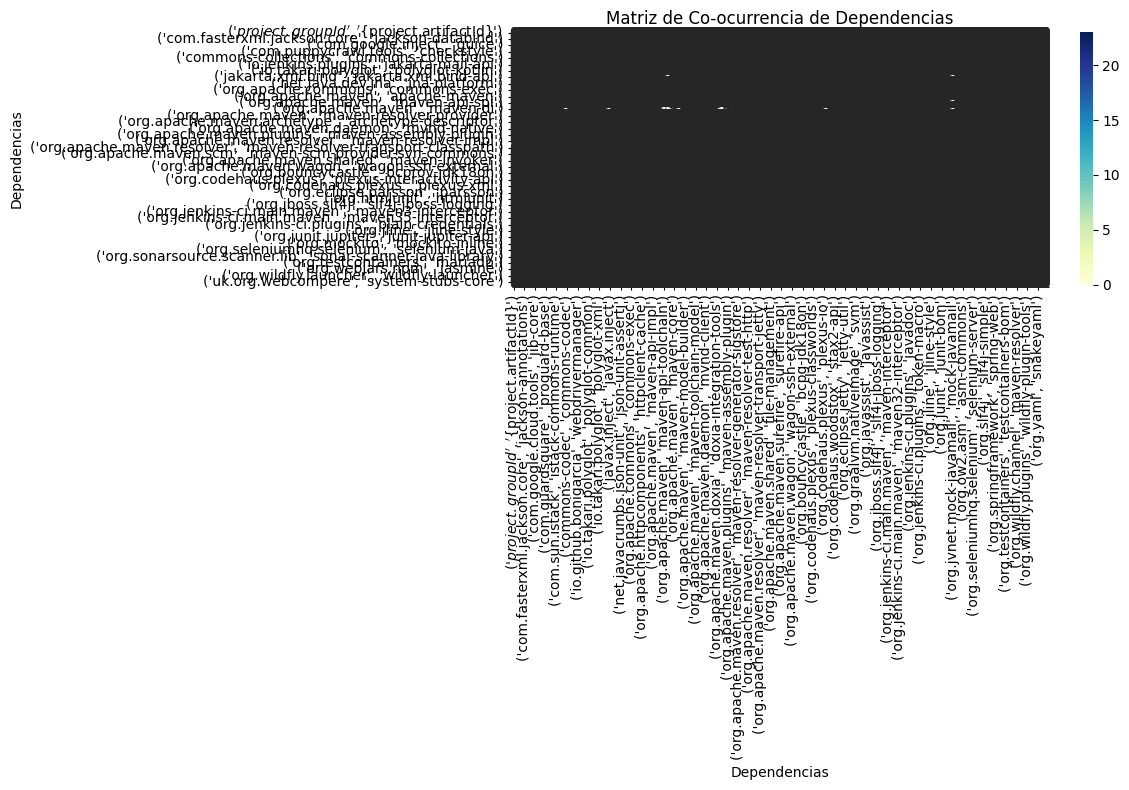

In [ ]:
import seaborn as sns

# Crear el heatmap de la matriz de co-ocurrencias
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_coocurrencias, annot=True, cmap="YlGnBu",  linewidths=0.5)
plt.title("Matriz de Co-ocurrencia de Dependencias")
plt.xlabel("Dependencias")
plt.ylabel("Dependencias")
plt.tight_layout()
plt.show()

**Análisis de Dependencias Propias vs. de Terceros**

Tipo
De Terceros    691
Propia         167
Name: count, dtype: int64


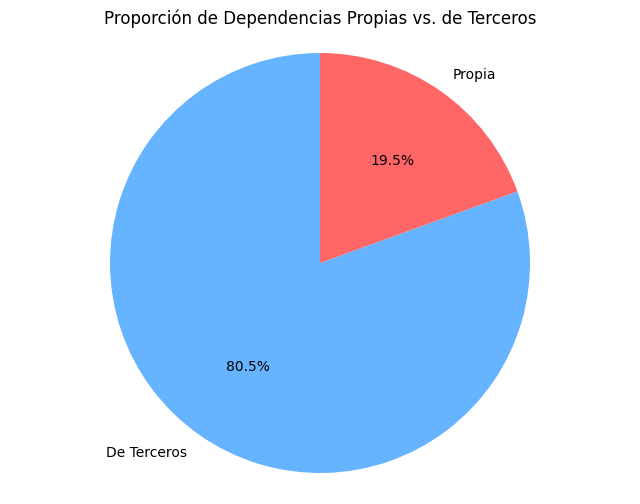

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset de dependencias
df_dependencias = pd.read_csv('dependencias_maven.csv')

# Función para clasificar dependencias
def clasificar_dependencia(row, project_group_id):
    """
    Clasifica una dependencia como propia o de terceros.
    Si el 'groupId' de la dependencia es igual al 'groupId' del proyecto, se considera propia.
    """
    if row['groupId'] == project_group_id:
        return 'Propia'
    else:
        return 'De Terceros'

# Obtener el 'groupId' del proyecto (suponiendo que es el mismo para todas las dependencias del proyecto)
project_group_id = df_dependencias['groupId'].iloc[0]

# Clasificar las dependencias
df_dependencias['Tipo'] = df_dependencias.apply(clasificar_dependencia, axis=1, project_group_id=project_group_id)

# Contar las dependencias propias vs de terceros
conteo_dependencias = df_dependencias['Tipo'].value_counts()

# Mostrar los resultados
print(conteo_dependencias)

# Paso 3: Visualizar la Proporción de Dependencias Propias vs de Terceros
plt.figure(figsize=(8, 6))
plt.pie(conteo_dependencias, labels=conteo_dependencias.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666'])
plt.title('Proporción de Dependencias Propias vs. de Terceros')
plt.axis('equal')  # Hace que el gráfico sea circular
plt.show()

Tipo                                                Propia
url_repositorio                                           
https://github.com/MithunTechnologiesDevOps/mav...       9
https://github.com/SonarSource/sonar-scanner-maven      16
https://github.com/aleksandr-m/gitflow-maven-pl...       6
https://github.com/apache/maven                         83
https://github.com/apache/maven-archetype               24
https://github.com/apache/maven-compiler-plugin          9
https://github.com/apache/maven-dependency-plugin       49
https://github.com/apache/maven-enforcer                22
https://github.com/apache/maven-mvnd                    53
https://github.com/apache/maven-release                 30
https://github.com/apache/maven-resolver                38
https://github.com/apache/maven-shade-plugin            23
https://github.com/apache/maven-surefire                31
https://github.com/asciidoctor/asciidoctor-mave...       8
https://github.com/download-maven-plugin/downlo...      

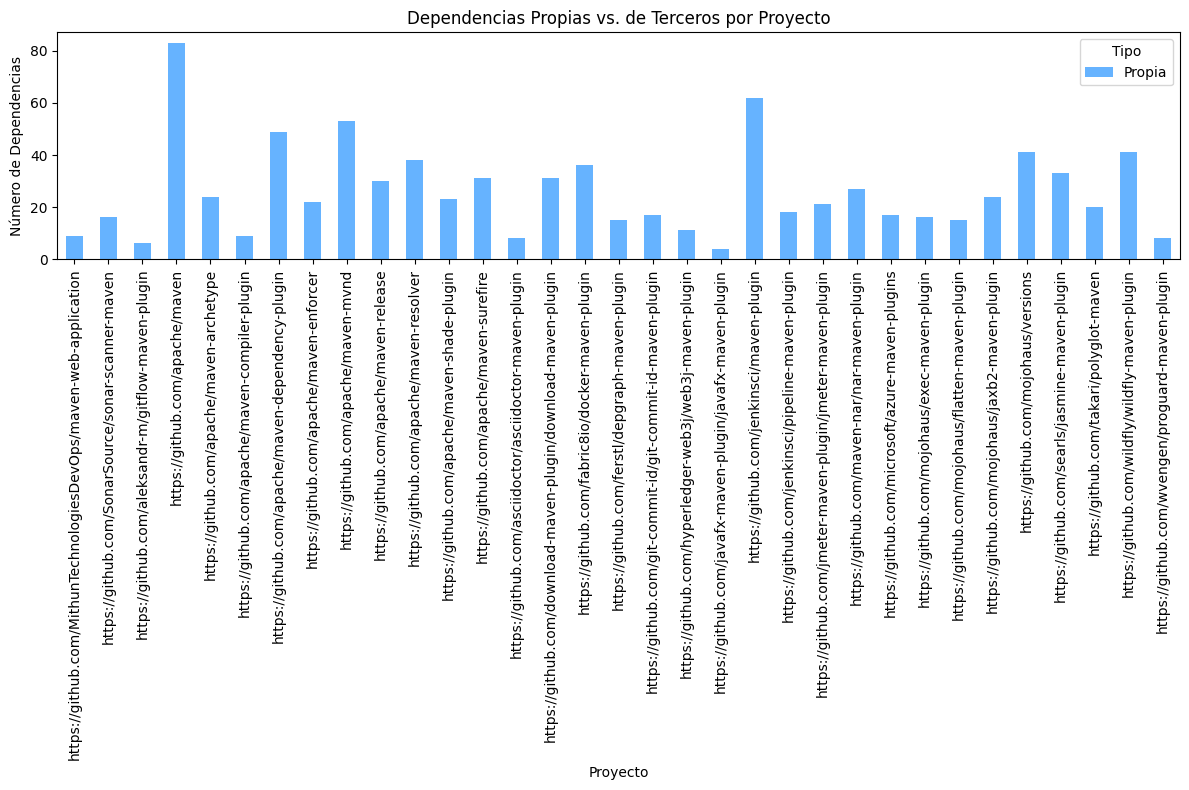

In [ ]:
# Agrupar por proyecto
df_dependencias['Tipo'] = df_dependencias.apply(lambda row: clasificar_dependencia(row, row['groupId']), axis=1)

# Obtener el conteo de dependencias por tipo para cada proyecto
conteo_por_proyecto = df_dependencias.groupby('url_repositorio')['Tipo'].value_counts().unstack(fill_value=0)

# Mostrar los resultados
print(conteo_por_proyecto)

# Visualizar los resultados
conteo_por_proyecto.plot(kind='bar', stacked=True, figsize=(12, 8), color=['#66b3ff', '#ff6666'])
plt.title('Dependencias Propias vs. de Terceros por Proyecto')
plt.xlabel('Proyecto')
plt.ylabel('Número de Dependencias')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Comparación entre Proyectos**

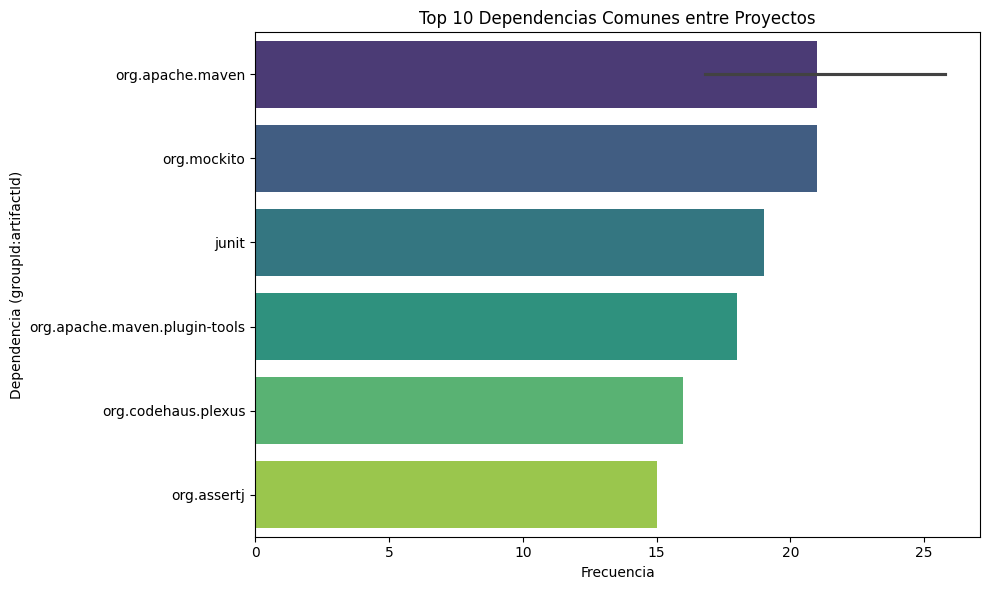

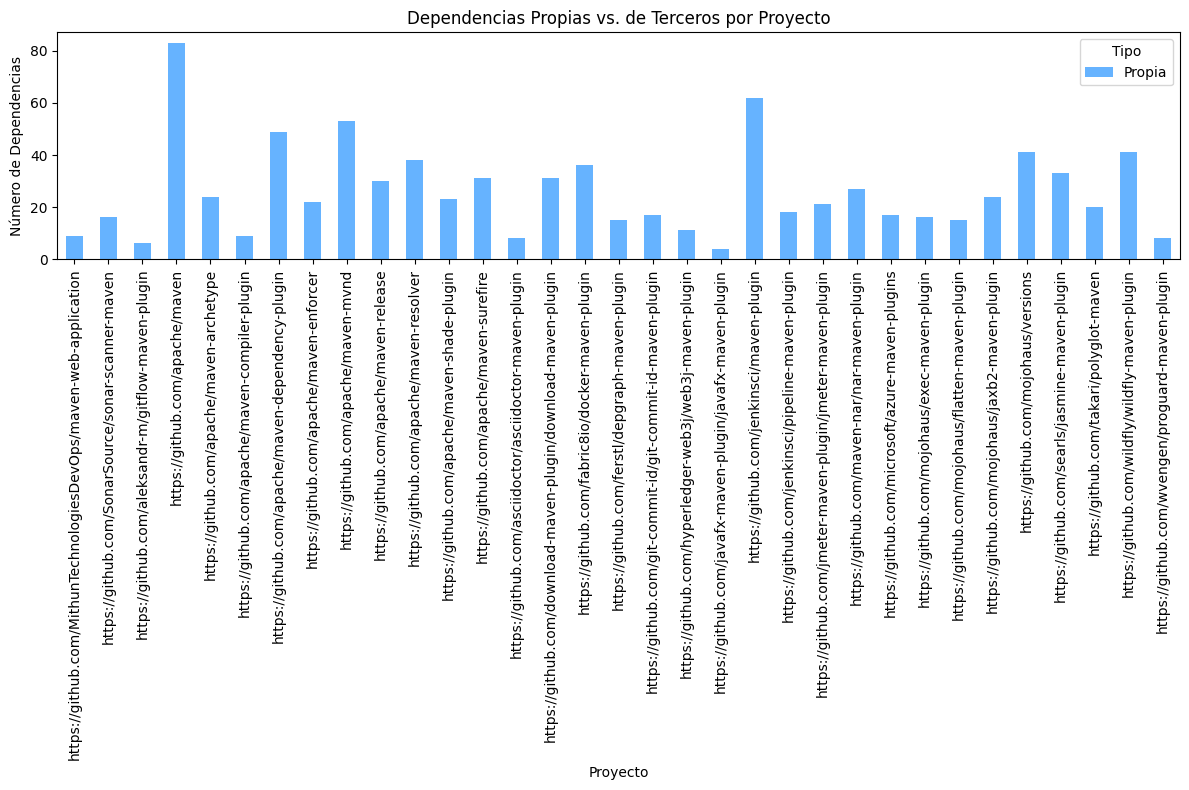

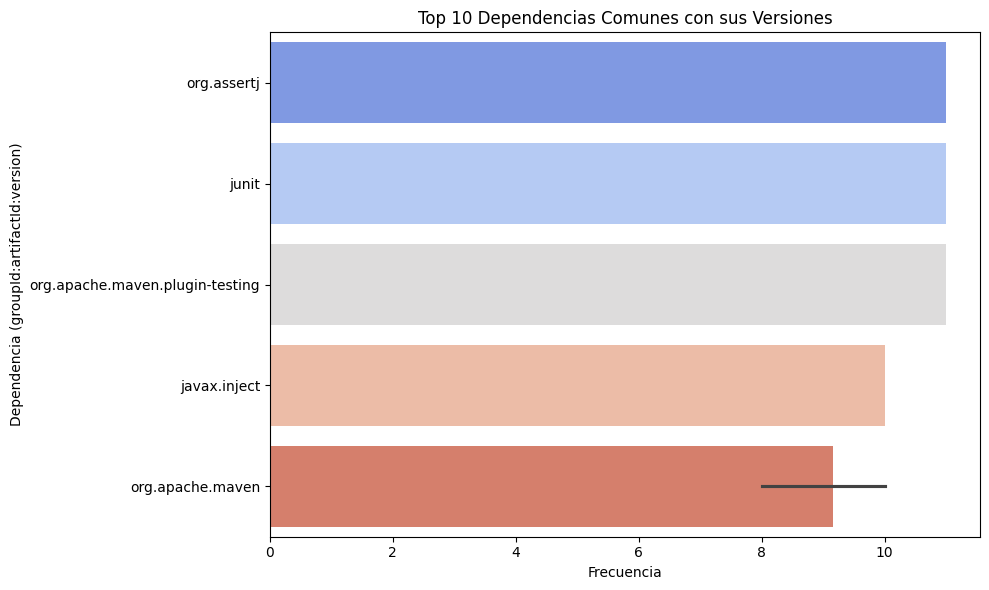

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset de dependencias
df_dependencias = pd.read_csv('dependencias_maven.csv')

# 1. Comparación de Dependencias Comunes entre Proyectos
# Contamos las dependencias comunes entre proyectos
dependencias_comunes = df_dependencias.groupby(['groupId', 'artifactId']).size().reset_index(name='Frecuencia')
dependencias_comunes = dependencias_comunes[dependencias_comunes['Frecuencia'] > 1]

# Visualizar las dependencias comunes más frecuentes
plt.figure(figsize=(10, 6))
sns.barplot(x='Frecuencia', y='groupId', hue='groupId', data=dependencias_comunes.sort_values(by='Frecuencia', ascending=False).head(10), palette='viridis')
plt.title('Top 10 Dependencias Comunes entre Proyectos')
plt.xlabel('Frecuencia')
plt.ylabel('Dependencia (groupId:artifactId)')
plt.tight_layout()
plt.show()

# 2. Comparación de Dependencias Propias vs. de Terceros entre Proyectos
# Agregar la clasificación de dependencias (propias vs. de terceros)
def clasificar_dependencia(row, project_group_id):
    if row['groupId'] == project_group_id:
        return 'Propia'
    else:
        return 'De Terceros'

# Obtener el 'groupId' principal de cada proyecto
df_dependencias['Tipo'] = df_dependencias.apply(lambda row: clasificar_dependencia(row, row['groupId']), axis=1)

# Contar la cantidad de dependencias propias vs. de terceros por proyecto
conteo_tipo_dependencias = df_dependencias.groupby(['url_repositorio', 'Tipo']).size().unstack(fill_value=0)

# Visualización de la proporción de dependencias propias vs. de terceros por proyecto
conteo_tipo_dependencias.plot(kind='bar', stacked=True, figsize=(12, 8), color=['#66b3ff', '#ff6666'])
plt.title('Dependencias Propias vs. de Terceros por Proyecto')
plt.xlabel('Proyecto')
plt.ylabel('Número de Dependencias')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3. Comparación de las Versiones de Dependencias Comunes entre Proyectos
# Agrupamos las dependencias comunes con su versión y los proyectos que las usan
dependencias_versiones_comunes = df_dependencias.groupby(['groupId', 'artifactId', 'version']).size().reset_index(name='Frecuencia')

# Filtrar dependencias que son comunes entre varios proyectos
dependencias_versiones_comunes = dependencias_versiones_comunes[dependencias_versiones_comunes['Frecuencia'] > 1]

# Visualizar las dependencias más comunes con sus versiones
plt.figure(figsize=(10, 6))
sns.barplot(x='Frecuencia', y='groupId', hue='groupId', data=dependencias_versiones_comunes.sort_values(by='Frecuencia', ascending=False).head(10), palette='coolwarm')
plt.title('Top 10 Dependencias Comunes con sus Versiones')
plt.xlabel('Frecuencia')
plt.ylabel('Dependencia (groupId:artifactId:version)')
plt.tight_layout()
plt.show()

**Análisis de Dependencias de Pruebas**

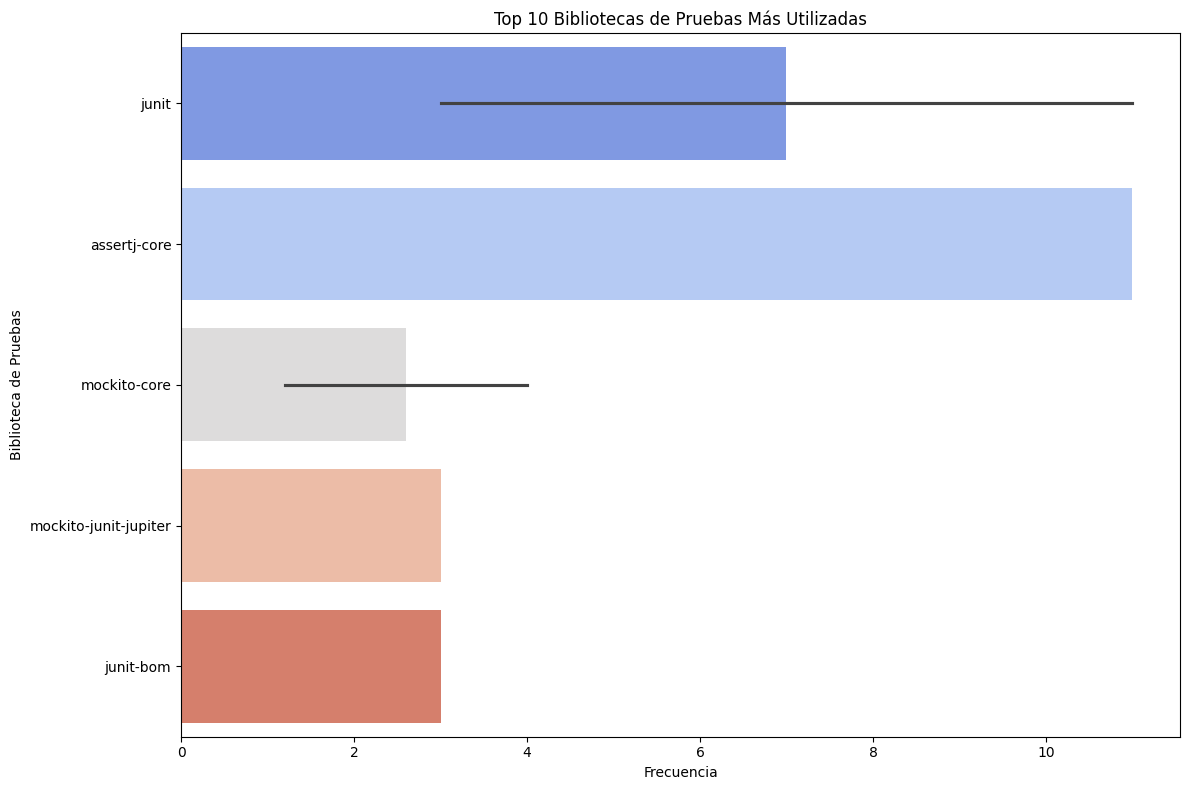

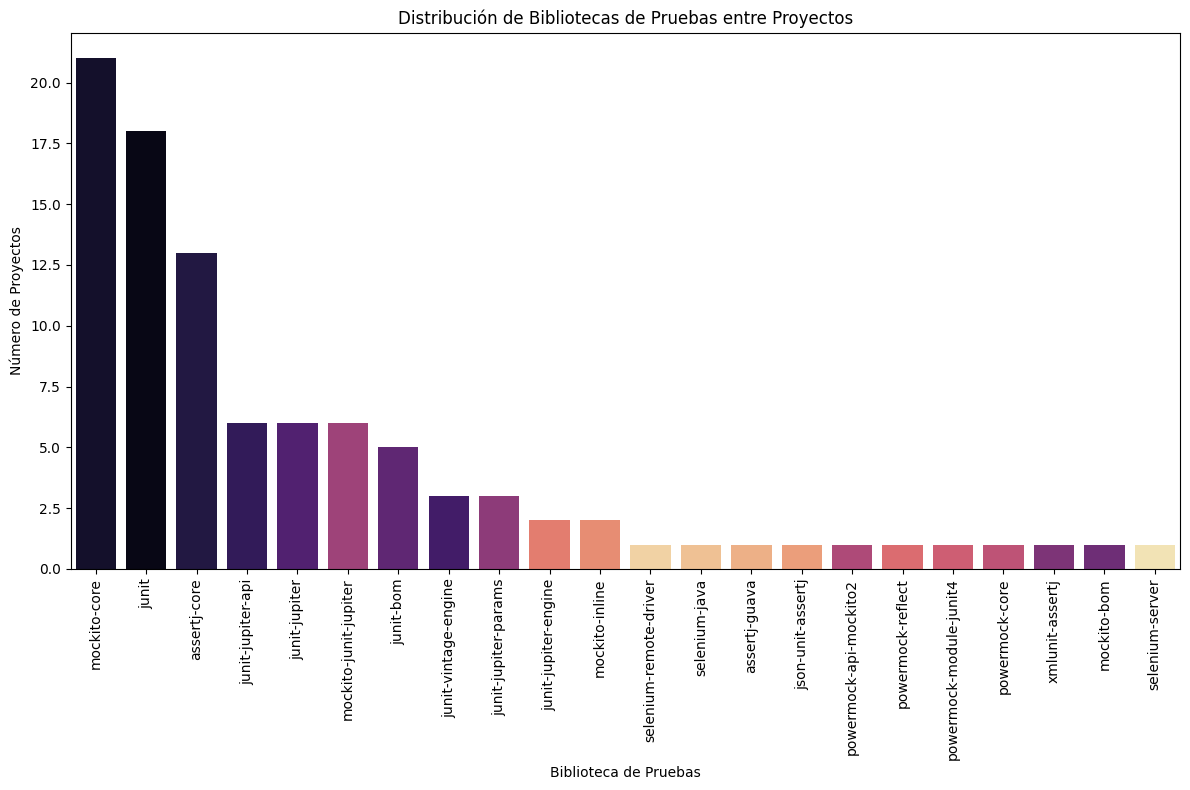

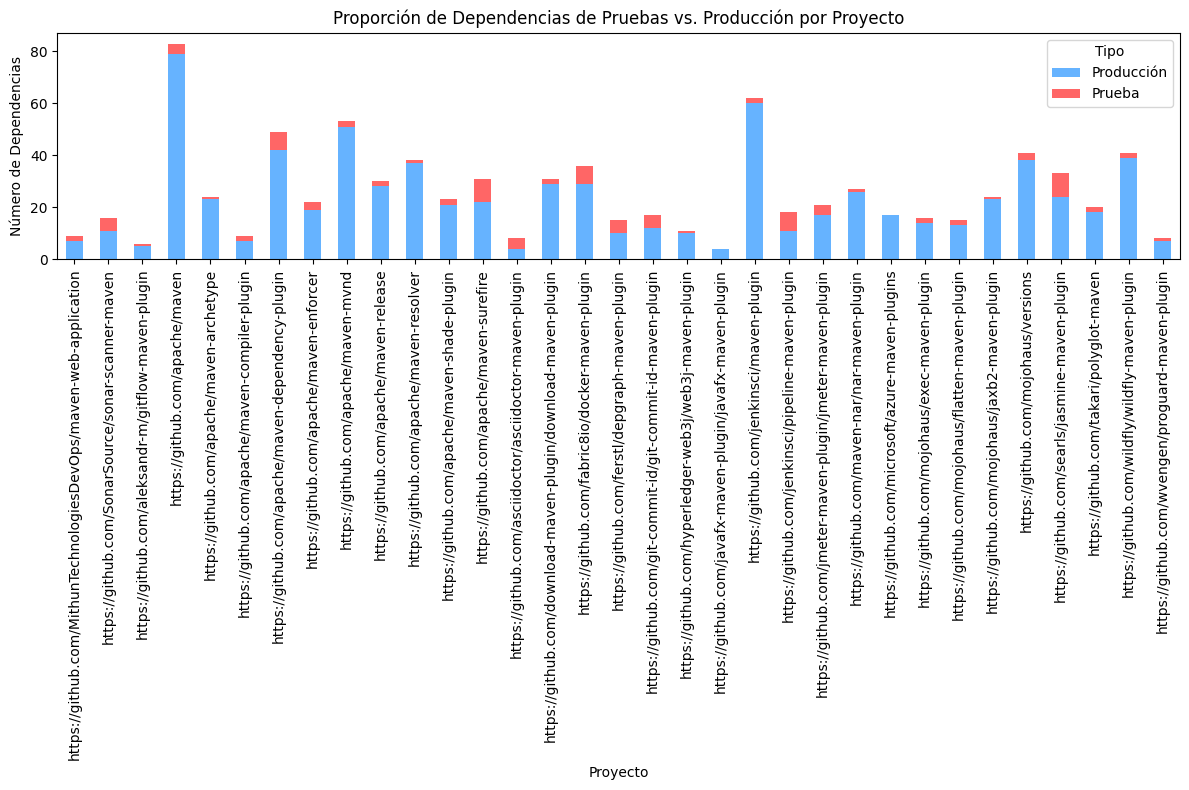

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset de dependencias
df_dependencias = pd.read_csv('dependencias_maven.csv')

# 1. Definir las bibliotecas de pruebas más comunes
bibliotecas_pruebas = ['junit', 'mockito', 'testng', 'cucumber', 'assertj', 'powermock', 'selenium']

# 2. Filtrar las dependencias de pruebas
def es_dependencia_pruebas(row):
    # Convertir a minúsculas para búsqueda insensible a mayúsculas
    return any(biblioteca in row['artifactId'].lower() for biblioteca in bibliotecas_pruebas)

# Filtrar dependencias de pruebas
df_dependencias_pruebas = df_dependencias[df_dependencias.apply(es_dependencia_pruebas, axis=1)]

# 3. Análisis de la Frecuencia de Dependencias de Pruebas
# Contamos cuántas veces aparece cada biblioteca de pruebas
frecuencia_pruebas = df_dependencias_pruebas.groupby(['groupId', 'artifactId', 'version']).size().reset_index(name='Frecuencia')

# Visualización de las bibliotecas de pruebas más utilizadas
plt.figure(figsize=(12, 8))
sns.barplot(x='Frecuencia', y='artifactId', hue='artifactId', data=frecuencia_pruebas.sort_values(by='Frecuencia', ascending=False).head(10), palette='coolwarm')
plt.title('Top 10 Bibliotecas de Pruebas Más Utilizadas')
plt.xlabel('Frecuencia')
plt.ylabel('Biblioteca de Pruebas')
plt.tight_layout()
plt.show()

# 4. Comparación de Dependencias de Pruebas entre Proyectos
# Contamos cuántos proyectos usan cada biblioteca de pruebas
proyectos_pruebas = df_dependencias_pruebas.groupby(['url_repositorio', 'artifactId']).size().reset_index(name='Frecuencia')

# Visualización de las bibliotecas de pruebas usadas por los proyectos
plt.figure(figsize=(12, 8))
sns.countplot(x='artifactId', hue='artifactId', data=proyectos_pruebas, order=proyectos_pruebas['artifactId'].value_counts().index, palette='magma')
plt.title('Distribución de Bibliotecas de Pruebas entre Proyectos')
plt.xlabel('Biblioteca de Pruebas')
plt.ylabel('Número de Proyectos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 5. Análisis de la Proporción de Dependencias de Pruebas por Proyecto
# Contamos cuántas dependencias son para pruebas en cada proyecto
df_dependencias['Tipo'] = df_dependencias.apply(lambda row: 'Prueba' if any(biblioteca in row['artifactId'].lower() for biblioteca in bibliotecas_pruebas) else 'Producción', axis=1)

# Agrupamos por proyecto y tipo de dependencia
proporciones_dependencias = df_dependencias.groupby(['url_repositorio', 'Tipo']).size().unstack(fill_value=0)

# Visualización de la proporción de dependencias de pruebas
proporciones_dependencias.plot(kind='bar', stacked=True, figsize=(12, 8), color=['#66b3ff', '#ff6666'])
plt.title('Proporción de Dependencias de Pruebas vs. Producción por Proyecto')
plt.xlabel('Proyecto')
plt.ylabel('Número de Dependencias')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Evaluación de las Dependencias por Lenguaje de Programación**

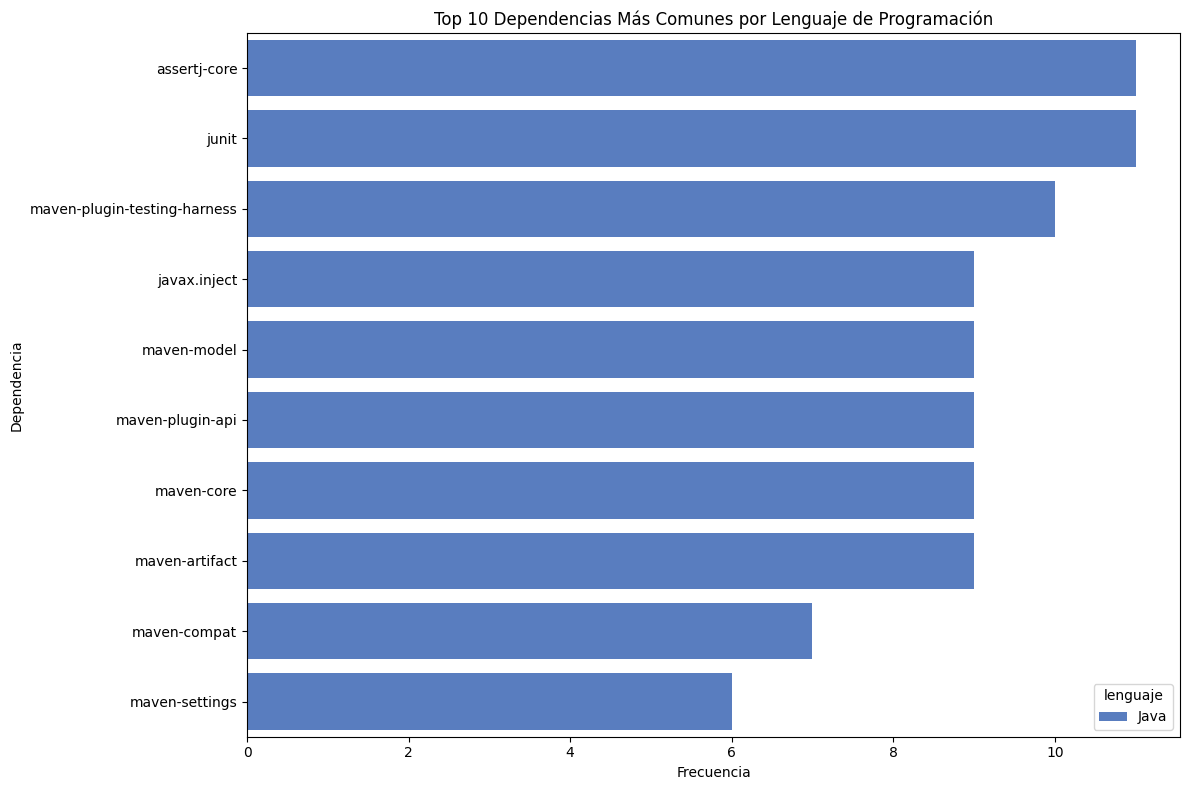

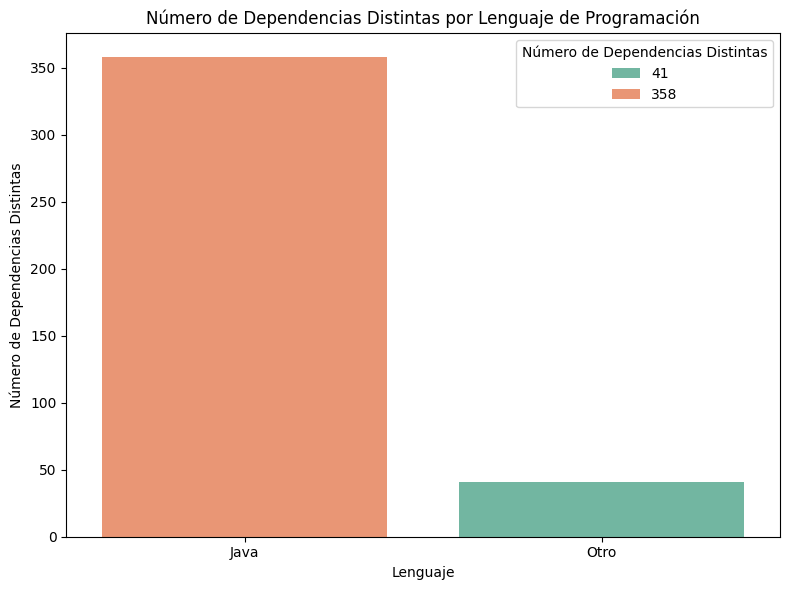

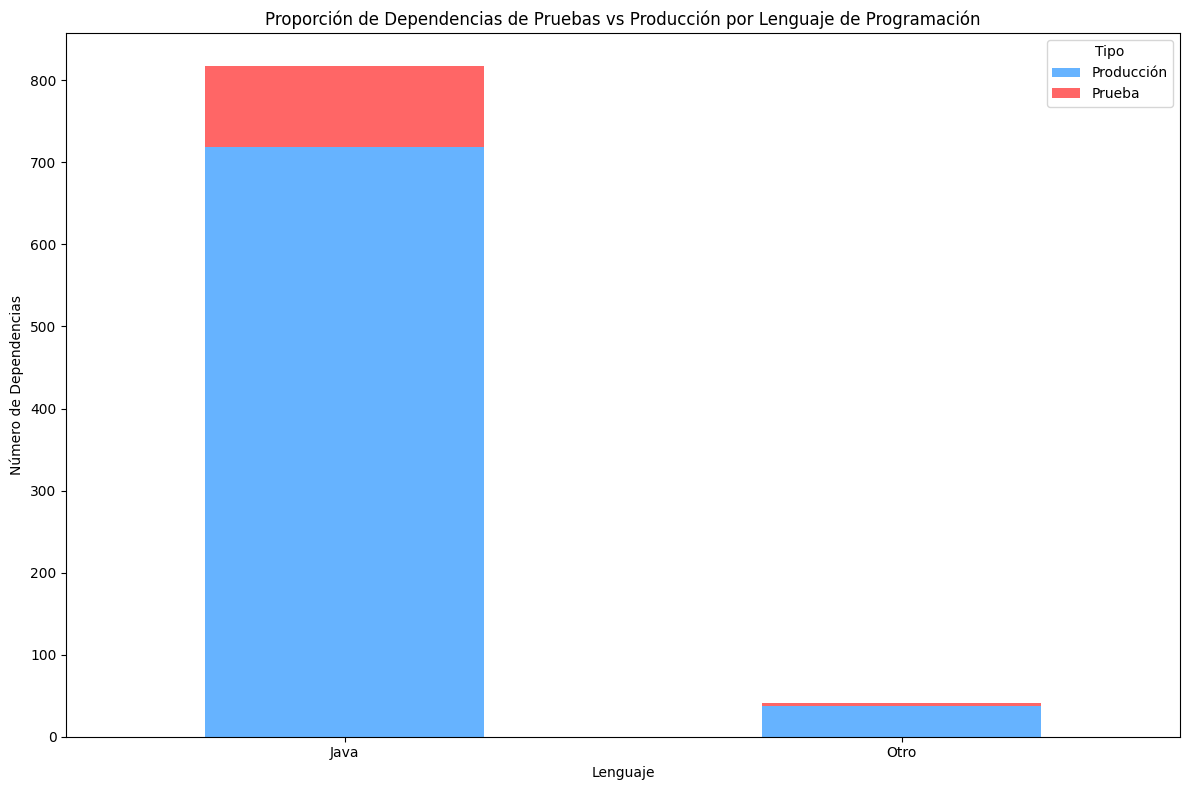

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset de dependencias
df_dependencias = pd.read_csv('dependencias_maven.csv')

# 1. Determinar el lenguaje del proyecto
# Asumimos que si el repositorio es Maven, el lenguaje es Java. Esto se puede expandir con más lógica si es necesario.
df_dependencias['lenguaje'] = df_dependencias['url_repositorio'].apply(lambda url: 'Java' if 'maven' in url else 'Otro')

# 2. Contar la frecuencia de las dependencias por lenguaje
frecuencia_dependencias = df_dependencias.groupby(['lenguaje', 'groupId', 'artifactId', 'version']).size().reset_index(name='Frecuencia')

# 3. Análisis de las dependencias más comunes por lenguaje
# Graficamos las dependencias más comunes para Java y otros lenguajes
plt.figure(figsize=(12, 8))
sns.barplot(x='Frecuencia', y='artifactId', data=frecuencia_dependencias.sort_values(by='Frecuencia', ascending=False).head(10), hue='lenguaje', palette='muted')
plt.title('Top 10 Dependencias Más Comunes por Lenguaje de Programación')
plt.xlabel('Frecuencia')
plt.ylabel('Dependencia')
plt.tight_layout()
plt.show()

# 4. Comparación de Dependencias entre Lenguajes
# Agrupamos por lenguaje y mostramos la cantidad de dependencias por lenguaje
dependencias_por_lenguaje = df_dependencias.groupby('lenguaje')['artifactId'].nunique().reset_index(name='Número de Dependencias Distintas')

# Graficamos la cantidad de dependencias por lenguaje
plt.figure(figsize=(8, 6))
sns.barplot(x='lenguaje', y='Número de Dependencias Distintas', hue='Número de Dependencias Distintas', data=dependencias_por_lenguaje, palette='Set2')
plt.title('Número de Dependencias Distintas por Lenguaje de Programación')
plt.xlabel('Lenguaje')
plt.ylabel('Número de Dependencias Distintas')
plt.tight_layout()
plt.show()

# 5. Proporción de Dependencias por Lenguaje
# Agrupamos por lenguaje y tipo de dependencia (producción vs pruebas) si es necesario
df_dependencias['Tipo'] = df_dependencias.apply(lambda row: 'Prueba' if any(biblioteca in row['artifactId'].lower() for biblioteca in bibliotecas_pruebas) else 'Producción', axis=1)

# Agrupamos por lenguaje y tipo de dependencia
dependencias_tipo_lenguaje = df_dependencias.groupby(['lenguaje', 'Tipo']).size().unstack(fill_value=0)

# Visualizamos la proporción de dependencias de pruebas y producción por lenguaje
dependencias_tipo_lenguaje.plot(kind='bar', stacked=True, figsize=(12, 8), color=['#66b3ff', '#ff6666'])
plt.title('Proporción de Dependencias de Pruebas vs Producción por Lenguaje de Programación')
plt.xlabel('Lenguaje')
plt.ylabel('Número de Dependencias')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Análisis de Dependencias en Función de la Arquitectura**

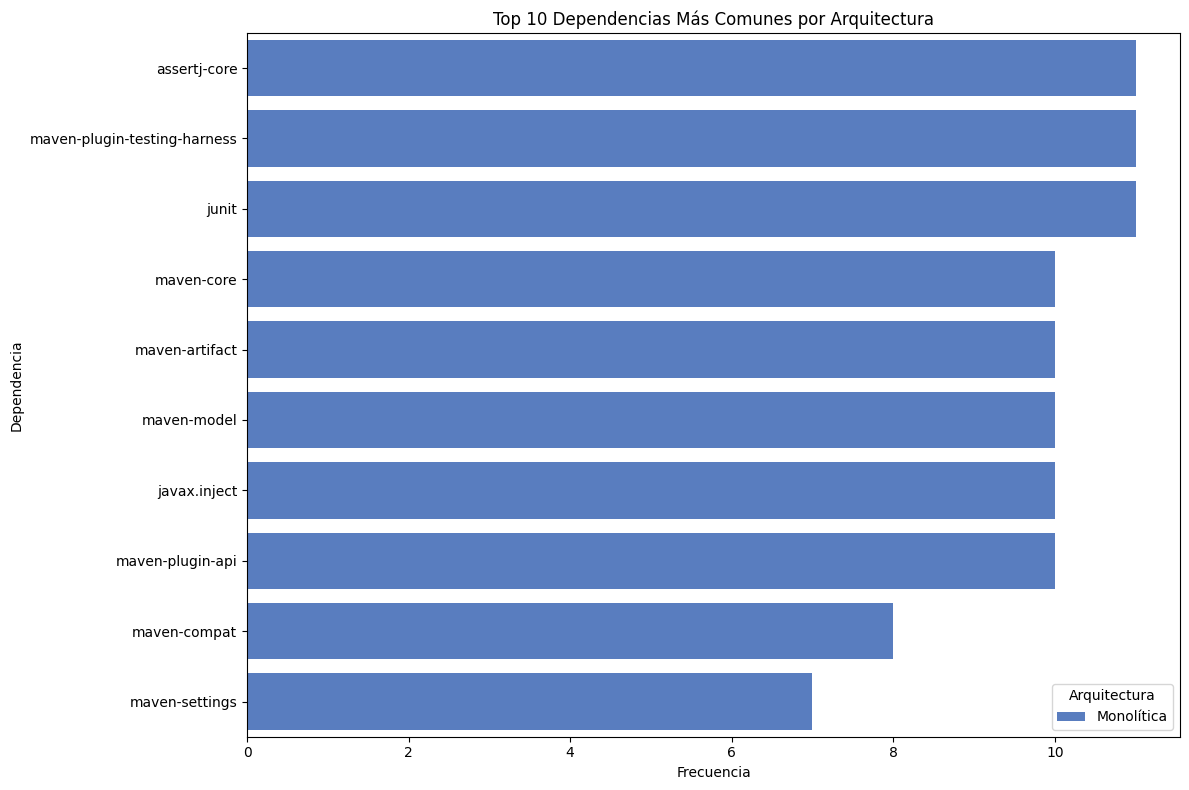

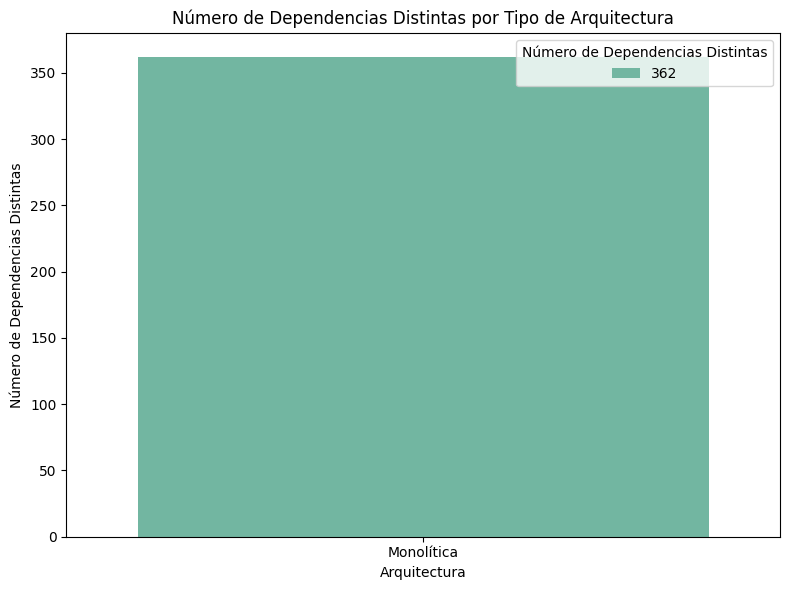

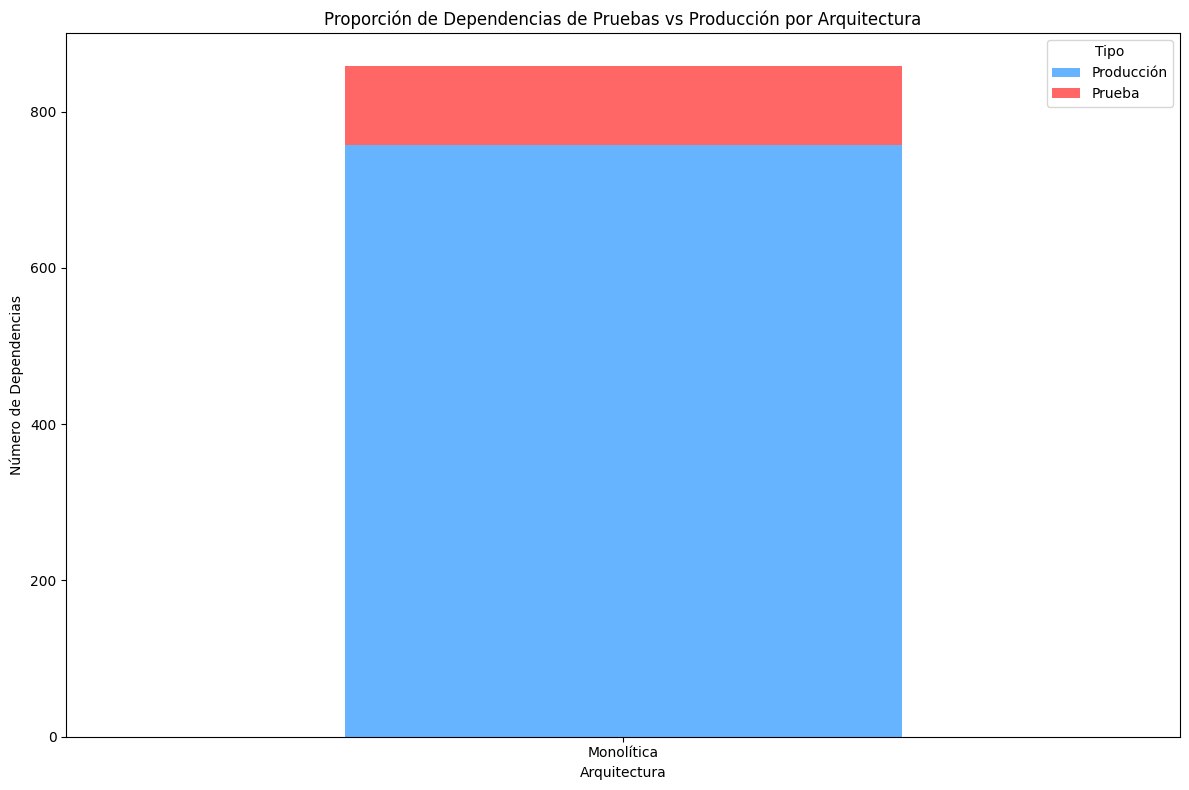

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset de dependencias
df_dependencias = pd.read_csv('dependencias_maven.csv')

# 1. Clasificación de Proyectos por Arquitectura
# En este ejemplo, estamos asumiendo que si el proyecto tiene más de 1 módulo (determinados por la cantidad de archivos pom.xml o algún archivo de configuración relacionado),
# podemos clasificarlo como microservicio. Si solo tiene un único módulo, se clasifica como monolítica.
# Esta clasificación se puede refinar según más datos disponibles o características específicas del proyecto.

# Añadir columna 'Arquitectura', asumiendo que los proyectos con más de 1 módulo son microservicios
df_dependencias['Arquitectura'] = df_dependencias['url_repositorio'].apply(
    lambda url: 'Microservicios' if url.count('/') > 5 else 'Monolítica'
)

# 2. Agrupar las dependencias por tipo de arquitectura
# Ahora agrupamos las dependencias por arquitectura y tipo (producción vs pruebas, si es necesario)
frecuencia_dependencias_arquitectura = df_dependencias.groupby(['Arquitectura', 'groupId', 'artifactId', 'version']).size().reset_index(name='Frecuencia')

# 3. Graficar las dependencias más comunes por tipo de arquitectura
plt.figure(figsize=(12, 8))
sns.barplot(x='Frecuencia', y='artifactId', data=frecuencia_dependencias_arquitectura.sort_values(by='Frecuencia', ascending=False).head(10), hue='Arquitectura', palette='muted')
plt.title('Top 10 Dependencias Más Comunes por Arquitectura')
plt.xlabel('Frecuencia')
plt.ylabel('Dependencia')
plt.tight_layout()
plt.show()

# 4. Comparación de Dependencias entre Arquitecturas
# Agrupamos por arquitectura y mostramos la cantidad de dependencias por arquitectura
dependencias_por_arquitectura = df_dependencias.groupby('Arquitectura')['artifactId'].nunique().reset_index(name='Número de Dependencias Distintas')

# Graficamos la cantidad de dependencias distintas por tipo de arquitectura
plt.figure(figsize=(8, 6))
sns.barplot(x='Arquitectura', y='Número de Dependencias Distintas', hue='Número de Dependencias Distintas', data=dependencias_por_arquitectura, palette='Set2')
plt.title('Número de Dependencias Distintas por Tipo de Arquitectura')
plt.xlabel('Arquitectura')
plt.ylabel('Número de Dependencias Distintas')
plt.tight_layout()
plt.show()

# 5. Proporción de Dependencias de Pruebas vs Producción por Arquitectura
# Si tenemos una columna que clasifica las dependencias en 'Prueba' o 'Producción', podemos analizar cómo se distribuyen.
df_dependencias['Tipo'] = df_dependencias.apply(
    lambda row: 'Prueba' if any(biblioteca in row['artifactId'].lower() for biblioteca in bibliotecas_pruebas) else 'Producción', axis=1)

# Agrupamos por arquitectura y tipo de dependencia
dependencias_tipo_arquitectura = df_dependencias.groupby(['Arquitectura', 'Tipo']).size().unstack(fill_value=0)

# Visualizamos la proporción de dependencias de pruebas y producción por arquitectura
dependencias_tipo_arquitectura.plot(kind='bar', stacked=True, figsize=(12, 8), color=['#66b3ff', '#ff6666'])
plt.title('Proporción de Dependencias de Pruebas vs Producción por Arquitectura')
plt.xlabel('Arquitectura')
plt.ylabel('Número de Dependencias')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

----

# Creación del dataset

Recolectar repositorios que cumplan con criterios

In [ ]:
import requests
import base64
import logging
import time
from concurrent.futures import ThreadPoolExecutor
from typing import List, Dict

# Configurar logs para seguimiento del análisis
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class MavenRepoAnalyzer:
    def __init__(self, github_token: str = None):
        self.github_api_headers = {'Accept': 'application/vnd.github.v3+json'}
        if github_token:
            self.github_api_headers['Authorization'] = f'token {github_token}'
        self.repo_criteria = {
            'min_commits': 20,
            'min_collaborators': 2,
            'min_stars': 20,
            'min_forks': 10
        }
        self.request_count = 0
        self.rate_limit = 200  # Ajustar para pruebas pequeñas  # Ajustar para mantenerse bajo el límite de 5000 por seguridad

    def rate_limit_check(self):
        """
        Verifica si se ha alcanzado el límite de peticiones y espera si es necesario.
        """
        self.request_count += 1
        if self.request_count >= self.rate_limit:
            print("Límite de peticiones alcanzado. Esperando 10 segundos para evitar bloqueo.")
            time.sleep(10)  # Reducir el tiempo de espera para pruebas pequeñas
            self.request_count = 0

    def search_maven_repositories(self, query: str, per_page: int = 100) -> List[Dict]:
        """
        Busca repositorios Maven en GitHub utilizando la API de GitHub.
        """
        url = f"https://api.github.com/search/repositories?q={query}+language:java&per_page={per_page}"
        self.rate_limit_check()
        response = requests.get(url, headers=self.github_api_headers)
        if response.status_code == 200:
            repos = response.json().get('items', [])
            print(f"Se encontraron {len(repos)} repositorios en la búsqueda inicial.")
            return repos
        else:
            print(f"Error al buscar repositorios: {response.status_code} - {response.text}")
            return []

    def get_repo_details(self, repo: Dict) -> Dict:
        """
        Obtiene detalles adicionales de un repositorio (commits, colaboradores, estrellas, forks, releases).
        """
        repo_name = repo['full_name']
        print(f"Analizando el repositorio: {repo_name}")
        base_url = f"https://api.github.com/repos/{repo_name}"

        try:
            # Obtener número de commits
            commits_url = f"{base_url}/commits"
            self.rate_limit_check()
            commits_response = requests.get(commits_url, headers=self.github_api_headers, params={'per_page': 1})
            commits = commits_response.links.get('last', {}).get('url', '').split('page=')[-1] if commits_response.status_code == 200 else 0

            # Obtener número de colaboradores
            collaborators_url = f"{base_url}/contributors"
            self.rate_limit_check()
            collaborators_response = requests.get(collaborators_url, headers=self.github_api_headers)
            collaborators = len(collaborators_response.json()) if collaborators_response.status_code == 200 else 0

            # Obtener número de releases
            releases_url = f"{base_url}/releases"
            self.rate_limit_check()
            releases_response = requests.get(releases_url, headers=self.github_api_headers)
            releases = len(releases_response.json()) if releases_response.status_code == 200 else 0

            # Filtrar basados en los criterios establecidos
            if (int(commits) >= self.repo_criteria['min_commits'] and
                    collaborators >= self.repo_criteria['min_collaborators'] and
                    repo['stargazers_count'] >= self.repo_criteria['min_stars'] and
                    repo['forks_count'] >= self.repo_criteria['min_forks'] and
                    releases > 0):
                return {
                    'name': repo_name,
                    'url': repo['html_url'],
                    'commits': commits,
                    'collaborators': collaborators,
                    'stars': repo['stargazers_count'],
                    'forks': repo['forks_count'],
                    'releases': releases
                }
        except Exception as e:
            print(f"Error obteniendo detalles del repositorio {repo_name}: {str(e)}")

        return None

    def filter_repositories(self, repositories: List[Dict]) -> List[Dict]:
        """
        Filtra los repositorios Maven en base a los criterios definidos.
        """
        filtered_repos = []
        with ThreadPoolExecutor() as executor:
            results = executor.map(self.get_repo_details, repositories)
            for result in results:
                if result:
                    filtered_repos.append(result)
        print(f"Se filtraron {len(filtered_repos)} repositorios que cumplen con los criterios de calidad.")
        return filtered_repos

    def analyze(self, query: str):
        """
        Ejecuta el análisis para buscar y filtrar los repositorios Maven de calidad.
        """
        repos = self.search_maven_repositories(query)
        print(f"Total de repositorios recolectados inicialmente: {len(repos)}")
        filtered_repos = self.filter_repositories(repos)
        print(f"Se encontraron {len(filtered_repos)} repositorios que cumplen con los criterios de calidad.")
        with open('repositorios_filtrados.txt', 'w') as f:
            for repo in filtered_repos:
              f.write(f"Repositorio: {repo['name']}, URL: {repo['url']}, Commits: {repo['commits']}, Colaboradores: {repo['collaborators']}, Releases: {repo['releases']}\n")

              print(f"Repositorio: {repo['name']}, URL: {repo['url']}, Commits: {repo['commits']}, Colaboradores: {repo['collaborators']}, Releases: {repo['releases']}")

if __name__ == "__main__":
    # Asegúrate de reemplazar 'YOUR_GITHUB_TOKEN' con tu token personal de GitHub
    github_token = 'AGREGAR TOKEN'
    analyzer = MavenRepoAnalyzer(github_token=github_token)
    analyzer.analyze("maven")


Se encontraron 100 repositorios en la búsqueda inicial.
Total de repositorios recolectados inicialmente: 100
Analizando el repositorio: apache/maven
Analizando el repositorio: jleetutorial/maven-project
Analizando el repositorio: MithunTechnologiesDevOps/maven-web-application
Analizando el repositorio: sunildevops77/maven
Analizando el repositorio: taylor-training/time-tracker
Analizando el repositorio: intelliqittrainings/maven
Analizando el repositorio: eirslett/frontend-maven-plugin
Analizando el repositorio: ashokitschool/maven-web-app
Analizando el repositorio: spotify/dockerfile-maven
Analizando el repositorio: apache/maven-surefire
Analizando el repositorio: anujdevopslearn/MavenBuild
Analizando el repositorio: apache/maven-mvnd
Analizando el repositorio: in28minutes/MavenIn28Minutes
Analizando el repositorio: KevinXie0131/SpringMVC-Spring-MyBatis
Analizando el repositorio: spotify/docker-maven-plugin
Analizando el repositorio: fabric8io/docker-maven-plugin
Analizando el reposit

In [ ]:
!pip install javalang


##Dataset inicial xls

In [ ]:
# junit4_analyzer.py

import git
import re
import javalang
from typing import List, Dict, Optional, Set
from datetime import datetime
import os
import pandas as pd
from packaging import version
import json

class DependencyChange:
    def __init__(self,
                repo_name: str,
                commit_sha: str,
                commit_date: datetime,
                author: str,
                message: str,
                old_version: str,
                new_version: str,
                version_source: str,
                old_dependency_xml: str,
                new_dependency_xml: str):
        self.repo_name = repo_name
        self.commit_sha = commit_sha
        self.commit_date = commit_date
        self.author = author
        self.message = message
        self.old_version = old_version
        self.new_version = new_version
        self.version_source = version_source
        self.old_dependency_xml = old_dependency_xml
        self.new_dependency_xml = new_dependency_xml

    def to_dict(self) -> Dict:
        return {
            'repo_name': self.repo_name,
            'commit_sha': self.commit_sha,
            'commit_date': self.commit_date,
            'author': self.author,
            'message': self.message,
            'old_version': self.old_version,
            'new_version': self.new_version,
            'version_source': self.version_source,
            'old_dependency_xml': self.old_dependency_xml,
            'new_dependency_xml': self.new_dependency_xml
        }

class JavaTestChange:
    def __init__(self,
                repo_name: str,
                commit_sha: str,
                file_path: str,
                old_content: str,
                new_content: str,
                imports_before: List[str],  # Cambiado de imports_changes
                imports_after: List[str],   # Nuevo campo
                assertion_changes: List[Dict],
                annotation_changes: List[Dict],
                method_changes: List[Dict],
                junit_version_from: str = None,
                junit_version_to: str = None):
        self.repo_name = repo_name
        self.commit_sha = commit_sha
        self.file_path = file_path
        self.old_content = old_content
        self.new_content = new_content
        self.imports_before = imports_before  # Cambiado
        self.imports_after = imports_after    # Nuevo
        self.assertion_changes = assertion_changes
        self.annotation_changes = annotation_changes
        self.method_changes = method_changes
        self.junit_version_from = junit_version_from
        self.junit_version_to = junit_version_to

    def to_dict(self) -> Dict:
        return {
            'repo_name': self.repo_name,
            'commit_sha': self.commit_sha,
            'file_path': self.file_path,
            'old_content': self.old_content,
            'new_content': self.new_content,
            'imports_before': self.imports_before,  # Cambiado
            'imports_after': self.imports_after,    # Nuevo
            'assertion_changes': self.assertion_changes,
            'annotation_changes': self.annotation_changes,
            'method_changes': self.method_changes,
            'junit_version_from': self.junit_version_from,
            'junit_version_to': self.junit_version_to
        }

class GitRepoAnalyzer:
    # Patrones específicos de JUnit 4
    JUNIT4_PATTERN = {
        'artifact': r'junit',
        'group': r'junit',
        'property_keys': ['junit.version', 'junit4.version'],
        'xml_patterns': [
            r'<dependency>[\s\n]*<groupId>junit</groupId>[\s\n]*<artifactId>junit</artifactId>[\s\n]*.*?</dependency>',
            r'<dependency>[\s\n]*<groupId>junit</groupId>[\s\n]*<artifactId>junit-dep</artifactId>[\s\n]*.*?</dependency>'
        ]
    }

    def __init__(self, repo_path: str, repo_name: str):
        self.repo = git.Repo(repo_path)
        self.repo_path = repo_path
        self.repo_name = repo_name

    def _get_nearby_commits(self, commit, window: int = 3) -> List[git.Commit]:
        """
        Obtiene los commits cercanos a un commit específico (±3 commits)
        """
        commits = []

        # Obtener commits anteriores
        current = commit
        for _ in range(window):
            if current.parents:
                current = current.parents[0]
                commits.append(current)
            else:
                break

        # Obtener commits posteriores
        try:
            next_commits = list(self.repo.iter_commits(
                rev=f'{commit.hexsha}..HEAD',
                max_count=window,
                reverse=True
            ))
            commits.extend(next_commits)
        except:
            pass

        return commits

    def _resolve_version_variable(self, version_str: str, pom_content: str) -> str:
        """
        Resuelve una variable de versión en el pom.xml
        Ejemplo: ${junit.version} -> 4.12
        """
        if not version_str or not version_str.startswith('${'):
            return version_str

        # Extraer el nombre de la variable
        var_name = version_str[2:-1]  # Remover ${ y }

        # Buscar en properties
        if '.' in var_name:
            property_pattern = f'<{var_name}>(.*?)</{var_name}>'
        else:
            property_pattern = f'<{var_name}>(.*?)</{var_name}>'

        # Buscar en diferentes secciones
        sections_to_search = [
            # Buscar en properties
            r'<properties>.*?</properties>',
            # Buscar en parent
            r'<parent>.*?</parent>',
            # Buscar en project
            r'<project[^>]*>.*?</project>'
        ]

        for section_pattern in sections_to_search:
            section_match = re.search(section_pattern, pom_content, re.DOTALL)
            if section_match:
                section_content = section_match.group(0)
                prop_match = re.search(property_pattern, section_content)
                if prop_match:
                    value = prop_match.group(1)
                    # Verificar si el valor es otra variable
                    if value.startswith('${'):
                        return self._resolve_version_variable(value, pom_content)
                    return value

        # Casos especiales
        special_vars = {
            'project.version': r'<version>(.*?)</version>',
            'parent.version': r'<parent>.*?<version>(.*?)</version>.*?</parent>'
        }

        if var_name in special_vars:
            pattern = special_vars[var_name]
            match = re.search(pattern, pom_content, re.DOTALL)
            if match:
                value = match.group(1)
                if value.startswith('${'):
                    return self._resolve_version_variable(value, pom_content)
                return value

        return version_str

    def analyze_junit_history(self, pom_path: str = "pom.xml") -> List[DependencyChange]:
        """Analiza el historial de cambios de JUnit en el pom.xml y código relacionado"""
        version_changes = []

        print("Analizando commits...")
        pom_commits = list(self.repo.iter_commits(paths=pom_path))
        total_commits = len(pom_commits)

        for i, commit in enumerate(pom_commits, 1):
            print(f"Procesando commit {i}/{total_commits}: {commit.hexsha[:7]}")

            try:
                # Analizar cambios en el POM
                pom_changes = self._analyze_commit_changes(commit, pom_path)

                if pom_changes:  # Si hay cambios en la versión de JUnit
                    for pom_change in pom_changes:
                        # Obtener commits cercanos
                        nearby_commits = self._get_nearby_commits(commit)

                        # Analizar cambios en archivos Java en commits cercanos
                        java_changes = []
                        for nearby_commit in nearby_commits:
                            # Obtener cambios en archivos Java
                            if nearby_commit.parents:
                                parent = nearby_commit.parents[0]
                                diffs = parent.diff(nearby_commit)

                                for diff in diffs:
                                    if diff.a_path and diff.a_path.endswith('.java'):
                                        try:
                                            old_content = self._get_file_content(parent, diff.a_path)
                                            new_content = self._get_file_content(nearby_commit, diff.a_path)

                                            # Verificar si es un archivo de pruebas
                                            if self._is_junit_test_file(old_content) or self._is_junit_test_file(new_content):
                                                java_changes.append({
                                                    'commit': nearby_commit,
                                                    'file': diff.a_path,
                                                    'old_content': old_content,
                                                    'new_content': new_content
                                                })
                                        except:
                                            continue

                        # Si encontramos cambios en archivos Java
                        if java_changes:
                            # Crear cambios consolidados
                            for java_change in java_changes:
                                version_changes.append(DependencyChange(
                                    repo_name=self.repo_name,
                                    commit_sha=java_change['commit'].hexsha,
                                    commit_date=datetime.fromtimestamp(java_change['commit'].committed_date),
                                    author=java_change['commit'].author.name,
                                    message=java_change['commit'].message,
                                    old_version=pom_change.old_version,
                                    new_version=pom_change.new_version,
                                    version_source=pom_change.version_source,
                                    old_dependency_xml=pom_change.old_dependency_xml,
                                    new_dependency_xml=pom_change.new_dependency_xml
                                ))
                        else:
                            # Si no hay cambios en Java, mantener el cambio original del POM
                            version_changes.append(pom_change)

            except Exception as e:
                print(f"Error analizando commit {commit.hexsha[:7]}: {e}")
                continue

        return version_changes

    def _analyze_commit_changes(self, commit, pom_path: str) -> List[DependencyChange]:
        """Analiza los cambios de versión de JUnit 4 en un commit"""
        changes = []

        if len(commit.parents) == 0:
            changes = self._extract_initial_versions(commit, pom_path)
        else:
            parent = commit.parents[0]
            diffs = parent.diff(commit, paths=pom_path)

            for diff in diffs:
                if diff.a_blob and diff.b_blob:
                    try:
                        old_content = diff.a_blob.data_stream.read().decode('utf-8')
                        new_content = diff.b_blob.data_stream.read().decode('utf-8')

                        # Extraer cambios específicos de JUnit 4
                        version_changes = self._extract_version_changes(
                            old_content,
                            new_content,
                            self.JUNIT4_PATTERN
                        )

                        for old_ver, new_ver, source, old_xml, new_xml in version_changes:
                            if old_ver != new_ver:  # Solo registrar si hay cambio real
                                changes.append(DependencyChange(
                                    repo_name=self.repo_name,
                                    commit_sha=commit.hexsha,
                                    commit_date=datetime.fromtimestamp(commit.committed_date),
                                    author=commit.author.name,
                                    message=commit.message,
                                    old_version=old_ver,
                                    new_version=new_ver,
                                    version_source=source,
                                    old_dependency_xml=old_xml,
                                    new_dependency_xml=new_xml
                                ))

                    except Exception as e:
                        print(f"Error procesando diff: {e}")
                        continue

        return changes

    def _extract_version_changes(self,
                               old_content: str,
                               new_content: str,
                               patterns: Dict) -> List[tuple]:
        """
        Extrae cambios de versión para JUnit 4, incluyendo resolución de variables
        """
        changes = []

        # Intentar cada patrón XML específico
        for pattern in patterns['xml_patterns']:
            old_matches = list(re.finditer(pattern, old_content, re.DOTALL | re.MULTILINE))
            new_matches = list(re.finditer(pattern, new_content, re.DOTALL | re.MULTILINE))

            old_deps = [match.group(0) for match in old_matches]
            new_deps = [match.group(0) for match in new_matches]

            # Si encontramos dependencias, extraer versiones y XML
            if old_deps or new_deps:
                old_dep = old_deps[0] if old_deps else ""
                new_dep = new_deps[0] if new_deps else ""

                # Extraer y resolver versiones
                old_ver = self._extract_version_from_xml(old_dep, old_content)
                new_ver = self._extract_version_from_xml(new_dep, new_content)

                # Solo incluir si es una versión válida de JUnit 4
                if self._is_junit4_version(old_ver) or self._is_junit4_version(new_ver):
                    changes.append((
                        old_ver,
                        new_ver,
                        'direct',
                        self._format_dependency_xml(old_dep) if old_dep else "",
                        self._format_dependency_xml(new_dep) if new_dep else ""
                    ))

        # Buscar en properties si no encontramos cambios directos
        if not changes:
            for prop_key in patterns['property_keys']:
                prop_pattern = f'<{prop_key}>(.*?)</{prop_key}>'
                old_prop = re.search(prop_pattern, old_content)
                new_prop = re.search(prop_pattern, new_content)

                if old_prop or new_prop:
                    old_ver = old_prop.group(1) if old_prop else None
                    new_ver = new_prop.group(1) if new_prop else None

                    # Solo incluir si es una versión válida de JUnit 4
                    if (old_ver is None or self._is_junit4_version(old_ver)) and \
                       (new_ver is None or self._is_junit4_version(new_ver)):
                        if old_ver != new_ver and (old_ver or new_ver):
                            xml_format = f'<{prop_key}>%s</{prop_key}>'
                            changes.append((
                                old_ver,
                                new_ver,
                                'property',
                                xml_format % old_ver if old_ver else "",
                                xml_format % new_ver if new_ver else ""
                            ))

        return changes

    def _extract_version_from_xml(self, xml_content: str, pom_content: str = None) -> str:
        """
        Extrae y resuelve la versión de un XML de dependencia
        """
        if not xml_content:
            return ""
        match = re.search(r'<version>(.*?)</version>', xml_content)
        if match:
            version_str = match.group(1)
            if pom_content and version_str.startswith('${'):
                resolved_version = self._resolve_version_variable(version_str, pom_content)
                print(f"Resolviendo variable de versión: {version_str} -> {resolved_version}")
                return resolved_version
            return version_str
        return ""

    def _extract_initial_versions(self, commit, pom_path: str) -> List[DependencyChange]:
        """Extrae las versiones iniciales de JUnit 4 del primer commit"""
        changes = []
        try:
            blob = commit.tree / pom_path
            content = blob.data_stream.read().decode('utf-8')

            # Buscar en dependencias directas
            for pattern in self.JUNIT4_PATTERN['xml_patterns']:
                matches = re.finditer(pattern, content, re.DOTALL | re.MULTILINE)
                for match in matches:
                    dependency_text = match.group(0)
                    if self._is_junit_dependency(dependency_text):
                        version = self._extract_version_from_xml(dependency_text, content)
                        if version and self._is_junit4_version(version):
                            formatted_xml = self._format_dependency_xml(dependency_text)
                            changes.append(DependencyChange(
                                repo_name=self.repo_name,
                                commit_sha=commit.hexsha,
                                commit_date=datetime.fromtimestamp(commit.committed_date),
                                author=commit.author.name,
                                message=commit.message,
                                old_version=None,
                                new_version=version,
                                version_source='direct',
                                old_dependency_xml="",
                                new_dependency_xml=formatted_xml
                            ))

            # Buscar en properties
            for prop_key in self.JUNIT4_PATTERN['property_keys']:
                prop_pattern = f'<{prop_key}>(.*?)</{prop_key}>'
                prop_match = re.search(prop_pattern, content)
                if prop_match:
                    version_str = prop_match.group(1)
                    if version_str.startswith('${'):
                        version_str = self._resolve_version_variable(version_str, content)
                    if version_str and self._is_junit4_version(version_str):
                        prop_xml = f'<{prop_key}>{version_str}</{prop_key}>'
                        changes.append(DependencyChange(
                            repo_name=self.repo_name,
                            commit_sha=commit.hexsha,
                            commit_date=datetime.fromtimestamp(commit.committed_date),
                            author=commit.author.name,
                            message=commit.message,
                            old_version=None,
                            new_version=version_str,
                            version_source='property',
                            old_dependency_xml="",
                            new_dependency_xml=prop_xml
                        ))

        except Exception as e:
            print(f"Error extrayendo versiones iniciales: {e}")

        return changes

    def _is_junit4_version(self, version_str: str) -> bool:
        """
        Verifica si una versión corresponde a JUnit 4.x
        """
        if not version_str:
            return False
        try:
            ver = version.parse(version_str)
            return ver.major == 4
        except:
            return False

    def _is_junit_dependency(self, dependency_text: str) -> bool:
        """Verifica que una dependencia es JUnit 4"""
        try:
            if not dependency_text:
                return False

            required_tags = ['groupId', 'artifactId']
            if not all(tag in dependency_text for tag in required_tags):
                return False

            # Verificar que es JUnit 4
            if not re.search(r'<groupId>junit</groupId>', dependency_text):
                return False

            if not re.search(r'<artifactId>junit</artifactId>', dependency_text):
                return False

            return True
        except:
            return False

    def _is_junit_test_file(self, content: str) -> bool:
        """
        Verifica si un archivo Java contiene pruebas de JUnit 4
        """
        if not content:
            return False

        # Patrones específicos de JUnit 4
        junit4_patterns = [
            r'import\s+org\.junit\.Test',
            r'import\s+junit\.framework\.TestCase',
            r'@Test',
            r'extends\s+TestCase',
            r'org\.junit\.Assert',
            r'org\.junit\.Before',
            r'org\.junit\.After',
            r'@Before\s',
            r'@After\s',
            r'assert[A-Z]'
        ]

        return any(re.search(pattern, content) for pattern in junit4_patterns)

    def _get_file_content(self, commit, file_path: str) -> str:
        """
        Obtiene el contenido de un archivo en un commit específico
        """
        try:
            blob = commit.tree / file_path
            return blob.data_stream.read().decode('utf-8')
        except:
            return ""

    def _format_dependency_xml(self, dependency_text: str) -> str:
        """Formatea el XML de la dependencia exactamente como se requiere"""
        if not dependency_text:
            return ""

        try:
            # Extraer los valores usando regex
            group_id = re.search(r'<groupId>(.*?)</groupId>', dependency_text)
            artifact_id = re.search(r'<artifactId>(.*?)</artifactId>', dependency_text)
            version = re.search(r'<version>(.*?)</version>', dependency_text)
            scope = re.search(r'<scope>(.*?)</scope>', dependency_text)

            if not all([group_id, artifact_id, version]):
                return ""

            # Construir el XML con el formato exacto deseado
            lines = ['<dependency>']
            lines.append(f' <groupId>{group_id.group(1)}</groupId>')
            lines.append(f' <artifactId>{artifact_id.group(1)}</artifactId>')
            lines.append(f' <version>{version.group(1)}</version>')
            if scope:
                lines.append(f' <scope>{scope.group(1)}</scope>')
            lines.append('</dependency>')

            return '\n'.join(lines)
        except Exception as e:
            print(f"Error formateando XML: {e}")
            return ""

class JUnitCodeAnalyzer:
    # Patrones específicos de JUnit 4
    JUNIT4_PATTERNS = {
        'imports': [
            'org.junit.Test',
            'junit.framework.TestCase',
            'org.junit.Before',
            'org.junit.After',
            'org.junit.BeforeClass',
            'org.junit.AfterClass',
            'org.junit.Ignore',
            'org.junit.Assert',
            'org.junit.runner'
        ],
        'annotations': {
            '@Test': '@Test',
            '@Before': '@Before',
            '@After': '@After',
            '@BeforeClass': '@BeforeClass',
            '@AfterClass': '@AfterClass',
            '@Ignore': '@Ignore',
            '@RunWith': '@RunWith'
        },
        'assertions': {
            'assertEquals': 'assertEquals',
            'assertTrue': 'assertTrue',
            'assertFalse': 'assertFalse',
            'assertNull': 'assertNull',
            'assertNotNull': 'assertNotNull',
            'assertThat': 'assertThat',
            'assertArrayEquals': 'assertArrayEquals',
            'assertSame': 'assertSame',
            'assertNotSame': 'assertNotSame',
            'fail': 'fail'
        }
    }

    def __init__(self, repo_path: str, repo_name: str):
        self.repo_path = repo_path
        self.repo_name = repo_name
        self.repo = git.Repo(repo_path)

    def analyze_test_changes(self, commit_with_junit_change: str) -> List[JavaTestChange]:
        """
        Analiza los cambios en archivos de prueba relacionados con un commit que cambió la versión de JUnit
        """
        changes = []
        commit = self.repo.commit(commit_with_junit_change)

        if not commit.parents:
            return self._analyze_initial_tests(commit)

        parent = commit.parents[0]
        diffs = parent.diff(commit)

        for diff in diffs:
            if not diff.a_path or not diff.b_path:
                continue

            if not (diff.a_path.endswith('.java') or diff.b_path.endswith('.java')):
                continue

            try:
                # Obtener contenido anterior y nuevo
                old_content = self._get_file_content(parent, diff.a_path)
                new_content = self._get_file_content(commit, diff.b_path)

                # Solo analizar si parece ser un archivo de pruebas de JUnit 4
                if self._is_junit4_test_file(old_content) or self._is_junit4_test_file(new_content):
                    changes.append(self._analyze_file_changes(
                        old_content,
                        new_content,
                        diff.b_path,
                        commit.hexsha
                    ))

            except Exception as e:
                print(f"Error analizando archivo {diff.b_path}: {e}")
                continue

        return changes

    def _analyze_initial_tests(self, commit) -> List[JavaTestChange]:
        """
        Analiza los archivos de prueba en el commit inicial
        """
        changes = []

        for item in commit.tree.traverse():
            if not hasattr(item, 'path') or not item.path.endswith('.java'):
                continue

            try:
                content = self._get_file_content(commit, item.path)

                if self._is_junit4_test_file(content):
                    # Obtenemos los imports iniciales usando _analyze_imports
                    imports_result = self._analyze_imports("", content)

                    changes.append(JavaTestChange(
                        repo_name=self.repo_name,
                        commit_sha=commit.hexsha,
                        file_path=item.path,
                        old_content="",
                        new_content=content,
                        imports_before=[],  # No hay imports antes del commit inicial
                        imports_after=imports_result['after'],  # Los imports del commit inicial
                        assertion_changes=[],
                        annotation_changes=[],
                        method_changes=self._analyze_initial_methods(content)
                    ))
            except Exception as e:
                print(f"Error analizando archivo inicial {item.path}: {e}")
                continue

        return changes

    def _is_junit4_test_file(self, content: str) -> bool:
        """
        Verifica si un archivo Java contiene pruebas de JUnit 4
        """
        if not content:
            return False

        # Patrones específicos de JUnit 4
        junit4_patterns = [
            r'import\s+org\.junit\.Test',
            r'import\s+junit\.framework\.TestCase',
            r'@Test',
            r'extends\s+TestCase',
            r'org\.junit\.Assert',
            r'org\.junit\.Before',
            r'org\.junit\.After',
            r'@Before\s',
            r'@After\s',
            r'assert[A-Z]',
            r'@RunWith\s*\(',
            r'org\.junit\.runner'
        ]

        return any(re.search(pattern, content) for pattern in junit4_patterns)

    def _analyze_imports(self, old_content: str, new_content: str) -> Dict[str, List[str]]:
        """
        Analiza los imports de JUnit en las versiones anterior y posterior del archivo,
        preservando la sintaxis original de Java.
        """
        def get_junit_imports(content: str) -> List[str]:
            imports = set()
            if not content:
                return []

            # Patrón para capturar la línea completa del import
            import_pattern = r'^import\s+(static\s+)?([^;]+);'

            # Analizar el contenido línea por línea para mantener el formato original
            for line in content.split('\n'):
                line = line.strip()
                match = re.match(import_pattern, line)

                if match and any(junit_pkg in line for junit_pkg in [
                    'org.junit',
                    'junit.framework',
                    'org.junit.runner',
                    'org.junit.runners',
                    'org.junit.rules',
                    'org.junit.experimental'
                ]):
                    # Conservar la línea completa del import
                    imports.add(line)

            # Ordenar los imports para mantener consistencia
            return sorted(list(imports))

        # Obtener imports de ambas versiones
        imports_before = get_junit_imports(old_content)
        imports_after = get_junit_imports(new_content)

        return {
            'before': imports_before,
            'after': imports_after
        }

    def _analyze_file_changes(self, old_content: str, new_content: str,
                                file_path: str, commit_sha: str) -> JavaTestChange:
        """
        Analiza los cambios en un archivo de pruebas
        """
        # Analizar importaciones relacionadas con JUnit 4
        imports_result = self._analyze_imports(old_content, new_content)

        # Analizar cambios en anotaciones de JUnit 4
        annotation_changes = self._analyze_annotations(old_content, new_content)

        # Analizar cambios en aserciones y métodos
        assertion_changes = self._analyze_assertions(old_content, new_content)
        method_changes = self._analyze_method_changes(old_content, new_content)

        return JavaTestChange(
            repo_name=self.repo_name,
            commit_sha=commit_sha,
            file_path=file_path,
            old_content=old_content,
            new_content=new_content,
            imports_before=imports_result['before'],
            imports_after=imports_result['after'],
            assertion_changes=assertion_changes,
            annotation_changes=annotation_changes,
            method_changes=method_changes
        )

    def _analyze_annotations(self, old_content: str, new_content: str) -> List[Dict]:
        """
        Analiza cambios en las anotaciones de JUnit 4
        """
        changes = []

        for annotation in self.JUNIT4_PATTERNS['annotations'].keys():
            old_matches = re.finditer(f'{annotation}\\s*(?:\\(.*?\\))?\\s*\n.*?\\{{',
                                    old_content, re.MULTILINE | re.DOTALL)

            for match in old_matches:
                context = self._extract_context(old_content, match.start(), 200)
                method_name = self._extract_method_name(context)
                if method_name:
                    new_context = self._find_method_context(new_content, method_name)
                    changes.append({
                        'old': annotation,
                        'new': annotation,  # Misma anotación para JUnit 4
                        'old_context': context,
                        'new_context': new_context if new_context else ""
                    })

        return changes

    def _analyze_assertions(self, old_content: str, new_content: str) -> List[Dict]:
        """
        Analiza cambios en los métodos de aserción de JUnit 4
        """
        changes = []

        for assertion in self.JUNIT4_PATTERNS['assertions'].keys():
            old_matches = re.finditer(f'{assertion}\\s*\\(.*?\\)',
                                    old_content, re.MULTILINE)

            for match in old_matches:
                context = self._extract_context(old_content, match.start(), 150)
                old_params = self._extract_method_parameters(match.group(0))
                method_name = self._extract_method_name(context)

                if method_name:
                    new_context = self._find_method_context(new_content, method_name)
                    if new_context:
                        new_match = re.search(f'{assertion}\\s*\\(.*?\\)', new_context)
                        if new_match:
                            new_params = self._extract_method_parameters(new_match.group(0))
                            changes.append({
                                'old_assertion': assertion,
                                'new_assertion': assertion,  # Mismo assert para JUnit 4
                                'old_params': old_params,
                                'new_params': new_params,
                                'old_context': context,
                                'new_context': new_context
                            })

        return changes

    def _analyze_method_changes(self, old_content: str, new_content: str) -> List[Dict]:
        """
        Analiza cambios en la firma y uso de métodos de prueba JUnit 4
        """
        changes = []

        try:
            old_tree = javalang.parse.parse(old_content)
            new_tree = javalang.parse.parse(new_content)

            old_methods = self._extract_test_methods(old_tree)
            new_methods = self._extract_test_methods(new_tree)

            all_method_names = set(old_methods.keys()) | set(new_methods.keys())

            for method_name in all_method_names:
                old_method = old_methods.get(method_name)
                new_method = new_methods.get(method_name)

                if old_method and new_method:  # Método modificado
                    changes.append(self._create_method_change_entry(
                        method_name, 'modified',
                        old_method, new_method,
                        old_content, new_content
                    ))
                elif old_method:  # Método eliminado
                    changes.append(self._create_method_change_entry(
                        method_name, 'removed',
                        old_method, None,
                        old_content, new_content
                    ))
                else:  # Método nuevo
                    changes.append(self._create_method_change_entry(
                        method_name, 'added',
                        None, new_method,
                        old_content, new_content
                    ))
        except Exception as e:
            print(f"Error analizando métodos: {e}")

        return changes

    def _create_method_change_entry(self, method_name: str, change_type: str,
                                  old_method, new_method,
                                  old_content: str, new_content: str) -> Dict:
        """
        Crea una entrada unificada de cambio de método
        """
        return {
            'method_name': method_name,
            'change_type': change_type,
            'old_signature': self._method_to_string(old_method) if old_method else None,
            'new_signature': self._method_to_string(new_method) if new_method else None,
            'old_implementation': self._extract_method_implementation(old_content, old_method) if old_method else None,
            'new_implementation': self._extract_method_implementation(new_content, new_method) if new_method else None,
            'parameter_changes': self._compare_parameters(old_method, new_method) if old_method and new_method else {'added': [], 'removed': []},
            'annotation_changes': self._compare_annotations(old_method, new_method) if old_method and new_method else {'added': [], 'removed': []}
        }

    def _extract_test_methods(self, tree) -> Dict:
        """
        Extrae métodos de prueba del árbol AST
        """
        methods = {}

        for path, node in tree.filter(javalang.tree.MethodDeclaration):
            if self._is_junit4_test_method(node):
                methods[node.name] = node

        return methods

    def _is_junit4_test_method(self, method_node) -> bool:
        """
        Determina si un método es una prueba de JUnit 4
        """
        if hasattr(method_node, 'annotations'):
            for annotation in method_node.annotations:
                if annotation.name in [
                    'Test',
                    'Before',
                    'After',
                    'BeforeClass',
                    'AfterClass',
                    'Ignore'
                ]:
                    return True

        if method_node.name.startswith('test'):
            return True

        return False

    def _analyze_initial_methods(self, content: str) -> List[Dict]:
        """
        Analiza los métodos en el contenido inicial
        """
        try:
            tree = javalang.parse.parse(content)
            methods = []

            for _, node in tree.filter(javalang.tree.MethodDeclaration):
                if self._is_junit4_test_method(node):
                    methods.append(self._create_method_change_entry(
                        node.name, 'added',
                        None, node,
                        "", content
                    ))

            return methods
        except Exception as e:
            print(f"Error analizando métodos iniciales: {e}")
            return []

    def _method_to_string(self, method_node) -> str:
        """
        Convierte un nodo de método a su representación en string
        """
        if not method_node:
            return ""

        parts = []

        if method_node.modifiers:
            parts.extend(method_node.modifiers)

        if method_node.return_type:
            parts.append(self._type_to_string(method_node.return_type))

        parts.append(method_node.name)
        params = [f"{self._type_to_string(param.type)} {param.name}"
                 for param in method_node.parameters]

        return f"{' '.join(parts)}({', '.join(params)})"

    def _type_to_string(self, type_node) -> str:
        """
        Convierte un nodo de tipo a string
        """
        if hasattr(type_node, 'name'):
            return type_node.name
        return str(type_node)

    def _compare_parameters(self, old_method, new_method) -> Dict:
        """
        Compara los parámetros entre versiones de un método
        """
        if not old_method or not new_method:
            return {'added': [], 'removed': []}

        old_params = [(p.type.name, p.name) for p in old_method.parameters]
        new_params = [(p.type.name, p.name) for p in new_method.parameters]

        return {
            'added': [f"{type_} {name}" for type_, name in new_params if (type_, name) not in old_params],
            'removed': [f"{type_} {name}" for type_, name in old_params if (type_, name) not in new_params]
        }

    def _compare_annotations(self, old_method, new_method) -> Dict:
        """
        Compara las anotaciones entre versiones de un método
        """
        if not old_method or not new_method:
            return {'added': [], 'removed': []}

        old_annotations = set(a.name for a in old_method.annotations)
        new_annotations = set(a.name for a in new_method.annotations)

        return {
            'added': list(new_annotations - old_annotations),
            'removed': list(old_annotations - new_annotations)
        }

    def _extract_context(self, content: str, position: int, context_size: int) -> str:
        """
        Extrae el contexto alrededor de una posición en el código
        """
        start = max(0, position - context_size // 2)
        end = min(len(content), position + context_size // 2)
        return content[start:end]

    def _extract_method_name(self, context: str) -> Optional[str]:
        """
        Extrae el nombre del método de un contexto
        """
        method_pattern = r'(?:public|protected|private|static|\s) +[\w\<\>\[\]]+\s+(\w+) *\([^\)]*\)'
        match = re.search(method_pattern, context)
        return match.group(1) if match else None

    def _find_method_context(self, content: str, method_name: str) -> Optional[str]:
        """
        Encuentra el contexto de un método por su nombre
        """
        method_pattern = f'(?:public|protected|private|static|\\s) +[\\w\\<\\>\\[\\]]+\\s+{method_name} *\\([^\\)]*\\)\\s*\\{{.*?\\}}'
        match = re.search(method_pattern, content, re.DOTALL)
        return match.group(0) if match else None

    def _extract_method_parameters(self, method_call: str) -> List[str]:
        """
        Extrae los parámetros de una llamada a método
        """
        params_match = re.match(r'.*?\((.*)\)', method_call)
        if params_match:
            params_str = params_match.group(1)
            params = []
            current_param = []
            paren_count = 0

            for char in params_str:
                if char == '(':
                    paren_count += 1
                elif char == ')':
                    paren_count -= 1
                elif char == ',' and paren_count == 0:
                    params.append(''.join(current_param).strip())
                    current_param = []
                    continue
                current_param.append(char)

            if current_param:
                params.append(''.join(current_param).strip())

            return params
        return []

    def _extract_method_implementation(self, content: str, method_node) -> str:
        """
        Extrae la implementación completa de un método
        """
        if not method_node or not content:
            return ""

        try:
            start_line = method_node.position.line if hasattr(method_node, 'position') else 0
            lines = content.splitlines()
            method_lines = []
            brace_count = 0
            started = False

            for i, line in enumerate(lines[start_line-1:], start_line):
                if '{' in line and not started:
                    started = True

                if started:
                    method_lines.append(line)
                    brace_count += line.count('{') - line.count('}')

                    if brace_count == 0:
                        break
                elif not started and not line.strip().startswith('@'):
                    method_lines.append(line)

            return '\n'.join(method_lines)
        except Exception as e:
            print(f"Error extrayendo implementación del método: {e}")
            return ""

    def _get_file_content(self, commit, file_path: str) -> str:
        """
        Obtiene el contenido de un archivo en un commit específico
        """
        try:
            blob = commit.tree / file_path
            return blob.data_stream.read().decode('utf-8')
        except:
            return ""

class JUnitVersionAnalyzer:
    def __init__(self, base_path: str):
        self.base_path = base_path
        if not os.path.exists(base_path):
            os.makedirs(base_path)

    def _clone_or_pull_repository(self, repo_url: str, repo_path: str):
        """Clona un repositorio o lo actualiza si ya existe"""
        try:
            if not os.path.exists(repo_path):
                print(f"Clonando {repo_url}...")
                git.Repo.clone_from(repo_url, repo_path)
                print("Clonación completada")
            else:
                print(f"Actualizando repositorio en {repo_path}...")
                repo = git.Repo(repo_path)
                origin = repo.remotes.origin
                origin.pull()
                print("Repositorio actualizado")
        except Exception as e:
            print(f"Error en operación git: {e}")
            raise

    def analyze_repositories(self, repo_urls: List[str]) -> pd.DataFrame:
        """
        Analiza múltiples repositorios y retorna un DataFrame unificado con todos los cambios
        """
        changes = []

        for repo_url in repo_urls:
            try:
                repo_name = repo_url.split('/')[-1].replace('.git', '')
                repo_path = os.path.join(self.base_path, repo_name)

                print(f"\nProcesando repositorio: {repo_url}")

                # Clonar o actualizar repositorio
                self._clone_or_pull_repository(repo_url, repo_path)

                # Analizar cambios de versión
                repo_analyzer = GitRepoAnalyzer(repo_path, repo_name)
                version_history = repo_analyzer.analyze_junit_history()

                # Para cada cambio de versión, analizar cambios en código
                code_analyzer = JUnitCodeAnalyzer(repo_path, repo_name)
                for version_change in version_history:
                    code_history = code_analyzer.analyze_test_changes(version_change.commit_sha)

                    # Crear un registro unificado por cada cambio de código
                    for code_change in code_history:
                        # Filtrar y procesar solo los métodos que tienen cambios reales
                        methods_with_changes = []
                        for method in code_change.method_changes:
                            if self._method_has_changes(method):
                                methods_with_changes.append({
                                    'name': method['method_name'],
                                    'change_type': method.get('change_type', ''),
                                    'old_signature': method.get('old_signature', ''),
                                    'new_signature': method.get('new_signature', ''),
                                    'old_implementation': method.get('old_implementation', ''),
                                    'new_implementation': method.get('new_implementation', ''),
                                    'parameters_added': method.get('parameter_changes', {}).get('added', []),
                                    'parameters_removed': method.get('parameter_changes', {}).get('removed', []),
                                    'annotations_added': method.get('annotation_changes', {}).get('added', []),
                                    'annotations_removed': method.get('annotation_changes', {}).get('removed', [])
                                })

                        unified_change = {
                            'repo_name': repo_name,
                            'commit_sha': version_change.commit_sha,
                            'commit_date': version_change.commit_date,
                            'author': version_change.author,
                            'commit_message': version_change.message,
                            'junit_version_from': version_change.old_version,
                            'junit_version_to': version_change.new_version,
                            'update_type': self._categorize_version_change({
                                'old_version': version_change.old_version,
                                'new_version': version_change.new_version
                            }),
                            'pom_before': version_change.old_dependency_xml,
                            'pom_after': version_change.new_dependency_xml,
                            'test_file': code_change.file_path,
                            'imports_before': code_change.imports_before,  # Actualizado
                            'imports_after': code_change.imports_after,    # Actualizado
                            'annotation_changes': code_change.annotation_changes,
                            'methods': methods_with_changes if methods_with_changes else None
                        }
                        changes.append(unified_change)

            except Exception as e:
                print(f"Error procesando repositorio {repo_url}: {e}")
                continue

        if changes:
          df = pd.DataFrame(changes)
          # Asegurarse de que las columnas existan y tengan el formato correcto
          if 'imports_before' not in df.columns:
              df['imports_before'] = df.apply(lambda x: [], axis=1)
          if 'imports_after' not in df.columns:
              df['imports_after'] = df.apply(lambda x: [], axis=1)
          return df
        return pd.DataFrame()

    def _method_has_changes(self, method: Dict) -> bool:
        """
        Determina si un método tiene cambios significativos
        """
        # Para métodos añadidos o eliminados
        if method.get('change_type') in ['added', 'removed']:
            return True

        # Para métodos modificados, verificar si hay cambios reales
        old_sig = method.get('old_signature', '')
        new_sig = method.get('new_signature', '')
        if old_sig != new_sig and old_sig and new_sig:
            return True

        old_impl = method.get('old_implementation', '')
        new_impl = method.get('new_implementation', '')
        if old_impl != new_impl and old_impl and new_impl:
            return True

        # Verificar cambios en parámetros
        param_changes = method.get('parameter_changes', {})
        if param_changes.get('added') or param_changes.get('removed'):
            return True

        # Verificar cambios en anotaciones
        annot_changes = method.get('annotation_changes', {})
        if annot_changes.get('added') or annot_changes.get('removed'):
            return True

        return False

    def _categorize_version_change(self, row) -> str:
        """Categoriza el tipo de cambio de versión"""
        if pd.isna(row['old_version']) or pd.isna(row['new_version']):
            return 'initial'
        try:
            old = version.parse(row['old_version'])
            new = version.parse(row['new_version'])

            if new.major > old.major:
                return 'major'
            elif new.minor > old.minor:
                return 'minor'
            elif hasattr(new, 'micro') and hasattr(old, 'micro') and new.micro > old.micro:
                return 'patch'
            else:
                return 'other'
        except:
            return 'unknown'

def main():
    # Lista de repositorios a analizar
    repositories =[
        "https://github.com/apache/maven.git",
        "https://github.com/MithunTechnologiesDevOps/maven-web-application.git",
        "https://github.com/spotify/dockerfile-maven.git",
        "https://github.com/apache/maven-surefire.git",
        "https://github.com/apache/maven-mvnd.git",
        "https://github.com/fabric8io/docker-maven-plugin.git",
        "https://github.com/mojohaus/versions.git",
        "https://github.com/jmeter-maven-plugin/jmeter-maven-plugin.git",
        "https://github.com/javafx-maven-plugin/javafx-maven-plugin.git",
        "https://github.com/git-commit-id/git-commit-id-maven-plugin.git",
        "https://github.com/microsoft/azure-maven-plugins.git",
        "https://github.com/apache/maven-compiler-plugin.git",
        "https://github.com/aleksandr-m/gitflow-maven-plugin.git",
        "https://github.com/takari/polyglot-maven.git",
        "https://github.com/apache/maven-dependency-plugin.git",
        "https://github.com/wvengen/proguard-maven-plugin.git",
        "https://github.com/mojohaus/exec-maven-plugin.git",
        "https://github.com/apache/maven-enforcer.git",
        "https://github.com/apache/maven-archetype.git",
        "https://github.com/mojohaus/flatten-maven-plugin.git",
        "https://github.com/jenkinsci/pipeline-maven-plugin.git",
        "https://github.com/searls/jasmine-maven-plugin.git",
        "https://github.com/fabric8io/fabric8-maven-plugin.git",
        "https://github.com/maven-nar/nar-maven-plugin.git",
        "https://github.com/apache/maven-release.git",
        "https://github.com/SonarSource/sonar-scanner-maven.git",
        "https://github.com/apache/maven-resolver.git",
        "https://github.com/hyperledger-web3j/web3j-maven-plugin.git",
        "https://github.com/jenkinsci/maven-plugin.git",
        "https://github.com/download-maven-plugin/download-maven-plugin.git",
        "https://github.com/asciidoctor/asciidoctor-maven-plugin.git",
        "https://github.com/mojohaus/jaxb2-maven-plugin.git",
        "https://github.com/rgladwell/m2e-android.git",
        "https://github.com/ferstl/depgraph-maven-plugin.git",
        "https://github.com/wildfly/wildfly-maven-plugin.git",
        "https://github.com/apache/maven-shade-plugin.git",
        "https://github.com/apache/rocketmq-flink.git",
        "https://github.com/j-easy/easy-rules.git",
        "https://github.com/iv4xr-project/iv4xr-mbt.git",
        "https://github.com/nativelibs4java/BridJ.git",
        "https://github.com/jakub014/CG-dependency-analyzer.git",
        "https://github.com/openzipkin-contrib/play-zipkin-tracing.git",
        "https://github.com/deng1fan/LazyProjects.git",
        "https://github.com/nabilzhang/disconf.git",
        "https://github.com/apache/karaf-webconsole.git",
        "https://github.com/apache/activemq-openwire.git",
        "https://github.com/yahoojapan/yosegi-hadoop.git",
        "https://github.com/QuiltMC/quilt-loader-sat4j.git",
        "https://github.com/alp82/abmash.git",
        "https://github.com/apache/portals-pluto.git",
        "https://github.com/GUMGA/maven-plugin.git",
        "https://github.com/apache/ftpserver.git",
        "https://github.com/kristiania/PGR112v24.git",
        "https://github.com/longdt/vertx-orm-mysql.git",
        "https://github.com/apache/sdap-mudrod.git",
        "https://github.com/bgoonz/stuff.git",
        "https://github.com/mlhartme/sushi.git",
        "https://github.com/daniel-araujo/java-byteringbuffer.git",
        "https://github.com/apache/maven-common-artifact-filters.git",
        "https://github.com/spotify/ffwd-http-client.git",
        "https://github.com/apache/karaf-cellar.git",
        "https://github.com/NeverBounce/NeverBounceApi-Java.git",
        "https://github.com/apache/jackrabbit-ocm.git",
        "https://github.com/vsima/uber-java-client.git",
        "https://github.com/square/cascading2-protobufs.git",
        "https://github.com/yihleego/banana.git",
        "https://github.com/apache/tomcat-taglibs-standard.git",
        "https://github.com/apache/ambari-infra.git",
        "https://github.com/apache/cocoon.git",
        "https://github.com/agrunfeld/solr-pubmed.git",
        "https://github.com/moon-util/moon-util.git",
        "https://github.com/apache/olingo-odata4.git",
        "https://github.com/apache/servicemix4-nmr.git",
        "https://github.com/rbenavente/evil.petclinic.git",
        "https://github.com/apache/streams.git",
        "https://github.com/OpenHFT/Chronicle-Test-Framework.git",
        "https://github.com/dishant/SecureBase.git",
        "https://github.com/igalonso/apigee-analytics-load-generator-demo.git",
        "https://github.com/sealuzh/lightweight-effectiveness.git",
        "https://github.com/nickboldt/jbosstools-svn-mirror.git",
        "https://github.com/adriens/schemacrawler-additional-command-lints-as-csv.git",
        "https://github.com/kgrodzicki/cloud-computing-specialization.git",
        "https://github.com/sapstern/edifactconverter.git",
        "https://github.com/Kuangcp/Configs.git",
        "https://github.com/apache/maven-checkstyle-plugin.git",
        "https://github.com/Tateology/java-corpus.git",
        "https://github.com/FredMushZhaoX/create-react-app-project.git",
        "https://github.com/oscarnovillo/dam1_21-22.git",
        "https://github.com/vsch/flexmark-java.git",
        "https://github.com/apache/rya.git",
        "https://github.com/CCweixiao/HydraQL.git",
        "https://github.com/apache/maven-war-plugin.git",
        "https://github.com/vivosys/bundlerepo.git",
        "https://github.com/apache/servicemix4-specs.git",
        "https://github.com/apache/tiles.git",
        "https://github.com/apache/maven-assembly-plugin.git",
        "https://github.com/apache/stanbol.git",
        "https://github.com/apache/servicemix4-features.git",
        "https://github.com/apache/tuscany-sca-1.x.git",
        "https://github.com/apache/incubator-tajo.git",
        "https://github.com/apache/openejb.git",
        "https://github.com/Study-Master/Client.git",
        "https://github.com/Bssentials/Bssentials.git",
        "https://github.com/apache/johnzon.git"
    ]
    # Crear analizador
    analyzer = JUnitVersionAnalyzer("./junit-repos")

    # Analizar repositorios
    df = analyzer.analyze_repositories(repositories)

    if not df.empty:
        # Guardar dataset unificado
        df.to_csv('junit4_changes_unified.csv', index=False)
        print(f"\nDataset unificado guardado en 'junit4_changes_unified.csv' con {len(df)} registros")

        # Mostrar ejemplos de cambios
        print("\nEjemplos de cambios:")
        sample_changes = df.sample(min(3, len(df)))
        for _, change in sample_changes.iterrows():
            print(f"\nRepositorio: {change['repo_name']}")
            print(f"Commit: {change['commit_sha'][:7]} ({change['commit_date']})")
            print(f"Archivo: {change['test_file']}")
            print(f"\nCambio de versión JUnit 4 ({change['update_type']}):")
            print(f"{change['junit_version_from']} → {change['junit_version_to']}")

            print("\nCambios en POM:")
            print("Antes:")
            print(change['pom_before'])
            print("\nDespués:")
            print(change['pom_after'])

            # Actualizado para usar imports_before e imports_after
            print("\nImports JUnit:")
            print("Antes:")
            if isinstance(change['imports_before'], list):
                for imp in change['imports_before']:
                    print(f"  {imp}")
            else:
                print("  No hay imports previos")

            print("\nDespués:")
            if isinstance(change['imports_after'], list):
                for imp in change['imports_after']:
                    print(f"  {imp}")
            else:
                print("  No hay imports nuevos")

            # Mostrar cambios en métodos
            if change['methods'] and isinstance(change['methods'], list):
                print("\nCambios en métodos:")
                for method in change['methods']:
                    print(f"\nMétodo: {method['name']}")
                    print(f"Tipo de cambio: {method['change_type']}")

                    if method['old_signature'] != method['new_signature']:
                        if method['old_signature']:
                            print("Firma anterior:")
                            print(method['old_signature'])
                        if method['new_signature']:
                            print("Nueva firma:")
                            print(method['new_signature'])

                    if method['old_implementation'] != method['new_implementation']:
                        if method['old_implementation']:
                            print("Implementación anterior:")
                            print(method['old_implementation'])
                        if method['new_implementation']:
                            print("Nueva implementación:")
                            print(method['new_implementation'])

            print("-" * 80)
    else:
        print("No se encontraron cambios para analizar")

if __name__ == "__main__":
    main()

Se han truncado las últimas 5000 líneas del flujo de salida.
Procesando commit 206/249: 479d9e1
Procesando commit 207/249: ac5ac99
Procesando commit 208/249: 09a2995
Procesando commit 209/249: 98c44ef
Procesando commit 210/249: 34232ad
Procesando commit 211/249: 67ab1ff
Procesando commit 212/249: b9597d0
Procesando commit 213/249: 2b96a28
Procesando commit 214/249: 199881d
Procesando commit 215/249: eda5a3c
Procesando commit 216/249: 519e4b0
Procesando commit 217/249: f877c5f
Procesando commit 218/249: 79ac9aa
Procesando commit 219/249: 56a395f
Procesando commit 220/249: 27e6716
Procesando commit 221/249: f1518b3
Procesando commit 222/249: 2982e00
Procesando commit 223/249: eb6f46a
Procesando commit 224/249: 68ab754
Procesando commit 225/249: 7f543e5
Procesando commit 226/249: adb43b2
Procesando commit 227/249: 1993313
Procesando commit 228/249: e3d0469
Procesando commit 229/249: 61592dc
Procesando commit 230/249: 2ec7fe8
Procesando commit 231/249: ab103c9
Procesando commit 232/249: 63

## Preprocesamiento y formateo a dataset final jsonl



Quitar comentarios del código, quita espacios innecesarios, saltos de líneas etc

In [ ]:
import pandas as pd
import json
import re
from typing import Dict, List

def clean_xml(xml_content: str) -> str:
    """Limpia el XML eliminando espacios innecesarios y asegurando un espacio después de cada \n"""
    if pd.isna(xml_content):
        return ""
    # Eliminar líneas vacías, quitar espacios innecesarios y normalizar \n
    cleaned_lines = [line.strip() for line in xml_content.split('\n') if line.strip()]
    return ' '.join(cleaned_lines)

def extract_methods(methods_str: str) -> List[Dict[str, str]]:
    """
    Extrae todos los métodos y retorna una lista donde cada elemento contiene
    la implementación before y after de un método
    """
    if pd.isna(methods_str) or not methods_str:
        return []

    try:
        # Extraer pares de implementaciones old/new
        old_pattern = r"'old_implementation':\s*'(.*?)'"
        new_pattern = r"'new_implementation':\s*'(.*?)'"

        old_implementations = re.findall(old_pattern, methods_str, re.DOTALL)
        new_implementations = re.findall(new_pattern, methods_str, re.DOTALL)

        # Emparejar las implementaciones
        method_pairs = []
        for old_impl, new_impl in zip(old_implementations, new_implementations):
            if old_impl and new_impl:  # Asegurarse que ambas implementaciones existen
                method_pairs.append({
                    'before': clean_text(old_impl),
                    'after': clean_text(new_impl)
                })

        return method_pairs
    except Exception as e:
        print(f"Error extrayendo métodos: {e}")
        return []

def clean_text(text: str) -> str:
    """
    Limpia el texto manteniendo \t y asegurando un solo espacio después de este.

    Args:
        text (str): Texto a limpiar

    Returns:
        str: Texto limpio
    """
    # Eliminar comentarios de bloque con sus contenidos
    text = re.sub(r'/\*.*?\*/', '', text, flags=re.DOTALL)

    # Eliminar comentarios de línea
    text = re.sub(r'//.*?(\n|$)', '', text)

    # Normalizar espacio después de \t (manteniendo el \t y asegurando un espacio)
    text = re.sub(r'(\\t)\s*', r'\1 ', text)

    # Normalizar \n con un espacio
    text = re.sub(r'\\n\s*', ' ', text)

    # Eliminar espacios múltiples (excepto después de \t que ya está normalizado)
    text = re.sub(r'([^\\])\s+', r'\1 ', text)

    # Eliminar @formatter tags
    text = re.sub(r'@formatter:(on|off)', '', text)

    return text.strip()

def create_task_description() -> str:
    """Crea la descripción de la tarea"""
    return "Actualizar JUnit a la versión 4.13.2, ajustando el código Java asociado para manejar excepciones, aserciones, cambios en métodos y optimizar las pruebas."

def create_jsonl_entries(row: pd.Series) -> List[Dict[str, str]]:
    """
    Crea múltiples entradas JSONL para una fila del dataset,
    una por cada método encontrado
    """
    xml_before = clean_xml(row['pom_before'])
    xml_after = clean_xml(row['pom_after'])
    task = create_task_description()

    # Obtener todos los pares de métodos (before/after)
    method_pairs = extract_methods(row['methods'])
    entries = []

    # Crear una entrada por cada par de métodos
    for method_pair in method_pairs:
        input_text = f"[XML]\n {xml_before} \n[JAVA]\n {method_pair['before']} \n[TASK]\n {task}"
        output_text = f"[XML]\n {xml_after} \n[JAVA]\n {method_pair['after']}"

        entries.append({
            "input": input_text,
            "output": output_text
        })

    return entries

def process_dataset(excel_path: str, output_path: str):
    """Procesa el dataset y genera el archivo JSONL"""
    print("Iniciando procesamiento del dataset...")

    # Leer el Excel
    df = pd.read_excel(excel_path)

    # Filtrar filas válidas
    valid_rows = df[df['pom_before'].notna() & df['pom_after'].notna()]

    print(f"Total de registros encontrados: {len(df)}")
    print(f"Registros válidos para procesar: {len(valid_rows)}")

    # Procesar registros
    total_entries = 0
    skipped_rows = 0

    with open(output_path, 'w', encoding='utf-8') as f:
        for idx, row in valid_rows.iterrows():
            try:
                entries = create_jsonl_entries(row)

                if not entries:
                    skipped_rows += 1
                    continue

                for entry in entries:
                    f.write(json.dumps(entry, ensure_ascii=False) + '\n')
                    total_entries += 1

                if total_entries % 100 == 0:
                    print(f"Procesados {total_entries} métodos...")

            except Exception as e:
                skipped_rows += 1
                print(f"Error en registro {idx}: {str(e)}")

    print("\nResumen del procesamiento:")
    print(f"Total registros originales procesados: {len(valid_rows)}")
    print(f"Total entradas JSONL generadas: {total_entries}")
    print(f"Registros omitidos: {skipped_rows}")
    print(f"Archivo JSONL generado en: {output_path}")

# Ejecutar el procesamiento
if __name__ == "__main__":
    process_dataset("output_file.xlsx", "dataset.jsonl")

Iniciando procesamiento del dataset...
Total de registros encontrados: 2223
Registros válidos para procesar: 2223
Procesados 200 métodos...
Procesados 300 métodos...
Procesados 400 métodos...
Procesados 500 métodos...
Procesados 600 métodos...
Procesados 700 métodos...
Procesados 1600 métodos...
Procesados 2300 métodos...
Procesados 3000 métodos...
Procesados 4100 métodos...
Procesados 4800 métodos...
Procesados 5500 métodos...
Procesados 6200 métodos...
Procesados 6900 métodos...
Procesados 7600 métodos...
Procesados 8300 métodos...
Procesados 9000 métodos...
Procesados 9700 métodos...
Procesados 10300 métodos...
Procesados 10600 métodos...
Procesados 10700 métodos...
Procesados 10800 métodos...
Procesados 11100 métodos...

Resumen del procesamiento:
Total registros originales procesados: 2223
Total entradas JSONL generadas: 11519
Registros omitidos: 101
Archivo JSONL generado en: dataset.jsonl


Validar que los cambios en código son validos

In [ ]:
! pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.5 MB/s eta 0:00:00


In [ ]:
import json
import re
from difflib import SequenceMatcher
from typing import Dict, List, Tuple
import Levenshtein

def extract_method_name(java_code: str) -> str:
    """
    Extrae solo el nombre del método del código Java
    """
    # Patrón simplificado para extraer nombre del método
    pattern = r'(?:public|private|protected)?\s+(?:\w+\s+)?(\w+)\s*\('
    match = re.search(pattern, java_code)
    return match.group(1) if match else ""

def calculate_code_similarity(code1: str, code2: str) -> float:
    """Calcula la similitud entre dos bloques de código usando SequenceMatcher"""
    # Normalizar el código antes de comparar
    code1 = re.sub(r'\s+', ' ', code1.strip())
    code2 = re.sub(r'\s+', ' ', code2.strip())
    return SequenceMatcher(None, code1, code2).ratio()

def is_quality_pair(before_code: str, after_code: str) -> bool:
    """
    Determina si un par de métodos (before/after) cumple con los criterios de calidad
    más flexibles y realistas para cambios de código
    """
    # Verificar que ambos códigos existen
    if not before_code or not after_code:
        return False

    # Extraer nombres de métodos
    before_name = extract_method_name(before_code)
    after_name = extract_method_name(after_code)

    if not before_name or not after_name:
        return False

    # Calcular similitud de código
    code_similarity = calculate_code_similarity(before_code, after_code)

    # Criterios más flexibles:
    # 1. Los nombres no tienen que ser exactamente iguales
    # 2. El código puede ser bastante diferente (> 10% similar)
    # 3. La longitud puede variar significativamente
    return code_similarity > 0.1

def filter_quality_data(input_file: str, output_file: str):
    """
    Lee el archivo JSONL de entrada, aplica los filtros de calidad
    y genera un nuevo archivo JSONL con los registros filtrados
    """
    total_records = 0
    quality_records = 0

    print("Iniciando filtrado de datos...")

    with open(input_file, 'r', encoding='utf-8') as fin, \
         open(output_file, 'w', encoding='utf-8') as fout:

        for line in fin:
            total_records += 1
            try:
                record = json.loads(line)

                # Extraer código Java de input y output
                input_java = re.search(r'\[JAVA\]\n\s*(.*?)(?:\n\[|$)', record['input'], re.DOTALL)
                output_java = re.search(r'\[JAVA\]\n\s*(.*?)(?:\n\[|$)', record['output'], re.DOTALL)

                if not input_java or not output_java:
                    print(f"No se pudo extraer código Java del registro {total_records}")
                    continue

                print(f"\nInput code: {input_java.group(1)}\nOutput code: {output_java.group(1)}\n")

                input_code = input_java.group(1).strip()
                output_code = output_java.group(1).strip()

                if is_quality_pair(input_code, output_code):
                    fout.write(line)
                    quality_records += 1

                if total_records % 100 == 0:
                    print(f"Procesados: {total_records}, Aceptados: {quality_records}")

            except Exception as e:
                print(f"Error procesando registro {total_records}: {str(e)}")
                continue

    print("\nResumen del filtrado:")
    print(f"Total registros procesados: {total_records}")
    print(f"Registros de calidad: {quality_records}")
    print(f"Porcentaje aceptado: {(quality_records/total_records)*100:.2f}%")

if __name__ == "__main__":
    filter_quality_data("dataset.jsonl", "dataset_quality.jsonl")

Se han truncado las últimas 5000 líneas del flujo de salida.
Output code: public void asyncChangesetViaPost() throws Exception { InputStream content = Thread.currentThread().getContextClassLoader().getResourceAsStream("basicBatchPost.batch"); final HttpURLConnection connection = postBatch(content, "batch_8194-cf13-1f56", 1); StringHelper.Stream response = StringHelper.toStream(connection.getInputStream()); assertEquals(0, response.byteLength()); Map<String, List<String>> headerFields = connection.getHeaderFields(); assertEquals("HTTP/1.1 202", headerFields.get(null).get(0));


Input code: public void batchAsync() throws Exception { final String content = getDefaultRequest("ESAllPrim(32767)"); final HttpURLConnection connection = postBatch(StringHelper.encapsulate(content), DEFAULT_BATCH_BOUNDARY, 1); StringHelper.Stream response = StringHelper.toStream(connection.getInputStream()); assertEquals(0, response.byteLength()); Map<String, List<String>> headerFields = connection.getHeaderFiel

Filtrar repetidos

In [ ]:
import json
import re
from difflib import SequenceMatcher

def calculate_similarity(code1: str, code2: str) -> float:
    """Calcula la similitud entre dos bloques de código"""
    # Normalizar el código antes de comparar
    code1 = re.sub(r'\s+', ' ', code1.strip())
    code2 = re.sub(r'\s+', ' ', code2.strip())
    return SequenceMatcher(None, code1, code2).ratio()

def filter_identical_code(input_file: str, output_file: str):
    """
    Lee el archivo JSONL y guarda solo los registros donde el código
    before y after son diferentes
    """
    total_records = 0
    identical_records = 0

    print("Iniciando filtrado de registros idénticos...")

    with open(input_file, 'r', encoding='utf-8') as fin, \
         open(output_file, 'w', encoding='utf-8') as fout:

        for line in fin:
            total_records += 1
            try:
                record = json.loads(line)

                # Extraer código Java
                input_java = re.search(r'\[JAVA\]\n\s*(.*?)(?:\n\[|$)', record['input'], re.DOTALL)
                output_java = re.search(r'\[JAVA\]\n\s*(.*?)(?:\n\[|$)', record['output'], re.DOTALL)

                if not input_java or not output_java:
                    continue

                input_code = input_java.group(1).strip()
                output_code = output_java.group(1).strip()

                # Si los códigos son diferentes (menos de 95% similares), guardar el registro
                if calculate_similarity(input_code, output_code) < 0.95:
                    fout.write(line)
                else:
                    identical_records += 1

                if total_records % 1000 == 0:
                    print(f"Procesados: {total_records}, Idénticos encontrados: {identical_records}")

            except Exception as e:
                print(f"Error procesando registro {total_records}: {str(e)}")
                continue

    print("\nResumen del filtrado:")
    print(f"Total registros procesados: {total_records}")
    print(f"Registros idénticos eliminados: {identical_records}")
    print(f"Registros restantes: {total_records - identical_records}")
    print(f"Porcentaje de registros eliminados: {(identical_records/total_records)*100:.2f}%")

if __name__ == "__main__":
    filter_identical_code("dataset_quality.jsonl", "dataset_filtered.jsonl")

Iniciando filtrado de registros idénticos...
Procesados: 1000, Idénticos encontrados: 591
Procesados: 2000, Idénticos encontrados: 660
Procesados: 3000, Idénticos encontrados: 744
Procesados: 4000, Idénticos encontrados: 1116
Procesados: 5000, Idénticos encontrados: 1184
Procesados: 6000, Idénticos encontrados: 1248
Procesados: 7000, Idénticos encontrados: 1317
Procesados: 8000, Idénticos encontrados: 1382
Procesados: 9000, Idénticos encontrados: 1449
Procesados: 10000, Idénticos encontrados: 1832
Procesados: 11000, Idénticos encontrados: 2604

Resumen del filtrado:
Total registros procesados: 11208
Registros idénticos eliminados: 2784
Registros restantes: 8424
Porcentaje de registros eliminados: 24.84%


# Modelo

In [ ]:
!pip install datasets transformers

In [ ]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=9b404e240e294989c918fb9073c9f5087e5fa8e5d948415824977ce2b8004b53
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
!pip install torch

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
from datasets import Dataset
from evaluate import load  # Nuevo método para métricas
#import torch
import numpy as np

# 1. Cargar el dataset con Hugging Face Datasets
raw_dataset = Dataset.from_json("/content/dataset.jsonl")

# 2. Configuración del modelo y tokenizer
model_name = "Salesforce/codet5-base"  # Modelo especializado para código
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


# Añadir tokens especiales para [XML], [JAVA], [TASK]
special_tokens = {"additional_special_tokens": ["[XML]", "[JAVA]", "[TASK]"]}
#num_added_toks = tokenizer.add_special_tokens(special_tokens)
# Resize the model's token embeddings and initialize them
#model.resize_token_embeddings(len(tokenizer))
# Initialize the embeddings of the newly added tokens with the average of existing token embeddings
#with torch.no_grad(): # This line is added to disable gradient tracking.
#  embedding_size = model.get_input_embeddings().weight.shape[1]
#  new_embeddings = model.get_input_embeddings().weight.mean(axis=0).repeat(num_added_toks, 1).reshape(num_added_toks, embedding_size)
#  model.get_input_embeddings().weight[-num_added_toks:, :] = new_embeddings


tokenizer.add_special_tokens(special_tokens)  # Sin el argumento `mean_resizing`
model.resize_token_embeddings(len(tokenizer))  # Ajustar el tamaño del vocabulario del modelo

# 3. Preprocesamiento del dataset
def preprocess_data(examples):
    import re

    def clean_text(text):
        # Eliminar saltos de línea y espacios extra
        text = re.sub(r'\s+', ' ', text.strip())  # Reemplazar múltiples espacios/saltos por un solo espacio
        return text

    # Aplicar la limpieza a cada campo
    examples['input'] = [clean_text(input_text) for input_text in examples['input']]
    examples['output'] = [clean_text(output_text) for output_text in examples['output']]

    # Tokenización de los datos limpios
    tokenized_inputs = tokenizer(
        examples['input'], max_length=512, truncation=True, padding="max_length"
    )
    tokenized_outputs = tokenizer(
        examples['output'], max_length=512, truncation=True, padding="max_length"
    )

    # Asegurar que las entradas y salidas tokenizadas estén alineadas
    tokenized_inputs['labels'] = tokenized_outputs['input_ids']

    return tokenized_inputs


# Tokenizar el dataset
tokenized_dataset = raw_dataset.map(preprocess_data, batched=True)

# 4. Crear un DataCollator para manejar el padding automáticamente
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Dividir el dataset en entrenamiento y validación
split_dataset = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

# 5. Configuración de los argumentos de entrenamiento
training_args = Seq2SeqTrainingArguments(
    run_name="./maven",
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=3e-5,  # Tasa de aprendizaje ajustada
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10,  # Incrementar el número de épocas
    weight_decay=0.01,
    save_total_limit=2,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=100,
    save_steps = 500,
    eval_steps = 500,
    report_to="none",
    fp16=True  # Usar precisión reducida si se soporta
)

#lugar para metricas

# 6. Entrenamiento del modelo
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    #compute_metrics=compute_metrics  # Aquí añades las métricas
)


trainer.train()

# Guardar el modelo entrenado
trainer.save_model("./codebart-artifact-updater")

# 7. Probar el modelo con un ejemplo nuevo
def test_model(input_text):
    # Move inputs to the same device as the model
    device = next(model.parameters()).device  # Get model's device
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        padding="longest",
        truncation=True,
        max_length=512
    ).to(device)
    outputs = model.generate(
        **inputs,
        max_length=512,
        num_beams=12,  # Más haces para mejorar la calidad
        early_stopping=True,
        no_repeat_ngram_size=4,
        length_penalty=2.0,
        #temperature=0.7
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Map:   0%|          | 0/8424 [00:00<?, ? examples/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
from datasets import Dataset
from evaluate import load  # Nuevo método para métricas
#import torch
import numpy as np

# 1. Cargar el dataset con Hugging Face Datasets
raw_dataset = Dataset.from_json("/content/dataset.jsonl")

# 2. Configuración del modelo y tokenizer
model_name = "Salesforce/codet5-base"  # Modelo especializado para código
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


# Añadir tokens especiales para [XML], [JAVA], [TASK]
special_tokens = {"additional_special_tokens": ["[XML]", "[JAVA]", "[TASK]"]}
#num_added_toks = tokenizer.add_special_tokens(special_tokens)
# Resize the model's token embeddings and initialize them
#model.resize_token_embeddings(len(tokenizer))
# Initialize the embeddings of the newly added tokens with the average of existing token embeddings
#with torch.no_grad(): # This line is added to disable gradient tracking.
#  embedding_size = model.get_input_embeddings().weight.shape[1]
#  new_embeddings = model.get_input_embeddings().weight.mean(axis=0).repeat(num_added_toks, 1).reshape(num_added_toks, embedding_size)
#  model.get_input_embeddings().weight[-num_added_toks:, :] = new_embeddings


tokenizer.add_special_tokens(special_tokens)  # Sin el argumento `mean_resizing`
model.resize_token_embeddings(len(tokenizer))  # Ajustar el tamaño del vocabulario del modelo

# 3. Preprocesamiento del dataset
def preprocess_data(examples):
    import re

    def clean_text(text):
        # Eliminar saltos de línea y espacios extra
        text = re.sub(r'\s+', ' ', text.strip())  # Reemplazar múltiples espacios/saltos por un solo espacio
        return text

    # Aplicar la limpieza a cada campo
    examples['input'] = [clean_text(input_text) for input_text in examples['input']]
    examples['output'] = [clean_text(output_text) for output_text in examples['output']]

    # Tokenización de los datos limpios
    tokenized_inputs = tokenizer(
        examples['input'], max_length=512, truncation=True, padding="max_length"
    )
    tokenized_outputs = tokenizer(
        examples['output'], max_length=512, truncation=True, padding="max_length"
    )

    # Asegurar que las entradas y salidas tokenizadas estén alineadas
    tokenized_inputs['labels'] = tokenized_outputs['input_ids']

    return tokenized_inputs


# Tokenizar el dataset
tokenized_dataset = raw_dataset.map(preprocess_data, batched=True)

# 4. Crear un DataCollator para manejar el padding automáticamente
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Dividir el dataset en entrenamiento y validación
split_dataset = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

# 5. Configuración de los argumentos de entrenamiento
training_args = Seq2SeqTrainingArguments(
    run_name="./maven",
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=3e-5,  # Tasa de aprendizaje ajustada
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10,  # Incrementar el número de épocas
    weight_decay=0.01,
    save_total_limit=2,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=100,
    save_steps = 500,
    eval_steps = 500,
    report_to="none",
    fp16=True  # Usar precisión reducida si se soporta
)

#lugar para metricas

# 6. Entrenamiento del modelo
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    #compute_metrics=compute_metrics  # Aquí añades las métricas
)


trainer.train()

# Guardar el modelo entrenado
trainer.save_model("./codebart-artifact-updater")

# 7. Probar el modelo con un ejemplo nuevo
def test_model(input_text):
    # Move inputs to the same device as the model
    device = next(model.parameters()).device  # Get model's device
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        padding="longest",
        truncation=True,
        max_length=512
    ).to(device)
    outputs = model.generate(
        **inputs,
        max_length=512,
        num_beams=12,  # Más haces para mejorar la calidad
        early_stopping=True,
        no_repeat_ngram_size=4,
        length_penalty=2.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Map:   0%|          | 0/8424 [00:00<?, ? examples/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [ ]:

input_test = "[XML] <dependencies><dependency><groupId>org.apache.maven</groupId><artifactId>maven-impl</artifactId><version>4.0.0-rc-1</version></dependency></dependencies>"
input_test += "[JAVA] public ConditionFunctions(ProfileActivationContext context, VersionParser versionParser, ProfileActivationFilePathInterpolator interpolator) { "
input_test += "this.context = context; this.versionParser = versionParser; this.interpolator = interpolator; } "
input_test += "[TASK] Actualizar la versión del artifact: maven-impl"

output_test = test_model(input_test)
print("Salida generada:")
print(output_test)

Salida generada:
 <dependencies><dependency>groupId>org.apache.maven</groupId><artifactId>maven-impl</artifactId><version>4.1.2</version></dependency></dependencies>  public void setProfileActivationContext(ProfileActivationContext context) { this.context = context; this.versionParser = versionParser; this.interpolator = interpolator; }


In [ ]:
example = eval_dataset[2]  # Cambia el índice para probar otros ejemplos
input_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
expected_output = tokenizer.decode(example["labels"], skip_special_tokens=True)

# Generar predicción
predicted_output = test_model(input_text)

# Mostrar los resultados
print(f"Entrada (input):\n{input_text}\n")
print(f"Salida esperada (expected output):\n{expected_output}\n")
print(f"Salida generada (predicted output):\n{predicted_output}\n")


Entrada (input):
 <dependencies> <dependency> <groupId>org.apache.maven</groupId> <artifactId>maven-di</artifactId> <version>4.0.0-rc-1</version> </dependency> </dependencies>  public static Annotation scopeOf(AnnotatedElement annotatedElement) { Annotation scope = null; for (Annotation annotation : annotatedElement.getDeclaredAnnotations()) { if (!annotation.annotationType().isAnnotationPresent(Scope.class)) continue; if (scope != null) { throw new DIException("More than one scope annotation on " + String.valueOf(annotatedElement)); } } } [TASK] Actualizar la version y el codigo del artifact: maven-di

Salida esperada (expected output):
 <dependencies> <dependency> <groupId>org.apache.maven</groupId> <artifactId>maven-di</artifactId> <version>4.0.0-rc-2</version> </dependency> </dependencies>  public static Annotation scopeOf(AnnotatedElement annotatedElement) { Annotation scope = null; for (Annotation annotation : annotatedElement.getDeclaredAnnotations()) { if (!annotation.annotatio

In [ ]:
example = eval_dataset[2]
input_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
expected_output = tokenizer.decode(example["labels"], skip_special_tokens=True)

# Generar predicción
predicted_output = test_model(input_text)

# Mostrar los resultados
print(f"Entrada (input):\n{input_text}\n")
print(f"Salida esperada (expected output):\n{expected_output}\n")
print(f"Salida generada (predicted output):\n{predicted_output}\n")


Entrada (input):
 <dependency> <groupId>junit</groupId> <artifactId>junit</artifactId> <version>4.13.1</version> <scope>test</scope> </dependency>  public abstract void testParsing() throws Exception; public void parsing() throws SecurityException, NoSuchMethodException, IllegalArgumentException, InstantiationException, IllegalAccessException, InvocationTargetException { Object[] conArgs = new Object[] {"one,two", "three,four,"}; AbstractArtifactFeatureFilter filter = (AbstractArtifactFeatureFilter) createObjectViaReflection(filterClass, conArgs); List<String> includes = filter.getIncludes(); List<String> excludes = filter.getExcludes(); assertEquals(2, includes.size()); assertEquals(2, excludes.size()); assertEquals("one", includes.get(0)); assertEquals("two", includes.get(1)); assertEquals("three", excludes.get(0)); assertEquals("four", excludes.get(1)); } [TASK] Actualizar JUnit a la versión 4.13.2, ajustando el código Java asociado para manejar excepciones, aserciones, cambios en m

Metricas de evaluacion probadas

In [ ]:
from evaluate import load
#bleu // rouce // gloo
# Cargar la métrica
rouge = load("rouge")

# Función para calcular métricas
def compute_metrics(eval_preds):
    # Desempaquetar preds y labels de eval_preds
    preds, labels = eval_preds

    # Decodificar predicciones y etiquetas
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Quitar espacios en blanco para comparación
    decoded_preds = ["\n".join(pred.strip() for pred in pred.splitlines()) for pred in decoded_preds]
    decoded_labels = ["\n".join(label.strip() for label in label.splitlines()) for label in decoded_labels]

    # Calcular ROUGE
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    return result

# Integrar la función de métricas en el entrenador
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


KeyboardInterrupt: 

In [ ]:
tokenized_dataset

NameError: name 'tokenized_dataset' is not defined

In [ ]:
tokenized_dataset['input']

['[XML] <dependency> <groupId>junit</groupId> <artifactId>junit</artifactId> <version>4.13.1</version> </dependency> [JAVA] public void forcedShutdownVerifyingLogs() { [TASK] Actualizar JUnit a la versión 4.13.2, ajustando el código Java asociado para manejar excepciones, aserciones, cambios en métodos y optimizar las pruebas.',
 '[XML] <dependency> <groupId>junit</groupId> <artifactId>junit</artifactId> <version>4.12</version> </dependency> [JAVA] public void shouldDecodeTwoCommands() throws IOException { TestLessInputStreamBuilder builder = new TestLessInputStreamBuilder(); TestLessInputStream pluginIs = builder.build(); builder.getImmediateCommands().acknowledgeByeEventReceived(); builder.getImmediateCommands().noop(); DataInputStream is = new DataInputStream( pluginIs ); Command bye = decode( is ); assertThat( bye, is( notNullValue() ) ); assertThat( bye.getCommandType(), is( BYE_ACK ) ); Command noop = decode( is ); assertThat( noop, is( notNullValue() ) ); assertThat( noop.getCom

In [ ]:
tokenized_dataset['output']

['[XML] <dependency> <groupId>junit</groupId> <artifactId>junit</artifactId> <version>4.13.2</version> </dependency> [JAVA] public void forcedShutdownVerifyingLogs() throws Exception {',
 '[XML] <dependency> <groupId>junit</groupId> <artifactId>junit</artifactId> <version>4.13</version> </dependency> [JAVA] public void shouldThrowUnsupportedException5() { TestLessInputStreamBuilder builder = new TestLessInputStreamBuilder(); builder.getCachableCommands().provideNewTest(); }',
 '[XML] <dependency> <groupId>junit</groupId> <artifactId>junit</artifactId> <version>4.13</version> </dependency> [JAVA] public void shouldThrowUnsupportedException1() { TestLessInputStreamBuilder builder = new TestLessInputStreamBuilder(); builder.getImmediateCommands().provideNewTest(); }',
 '[XML] <dependency> <groupId>junit</groupId> <artifactId>junit</artifactId> <version>4.13.1</version> <scope>test</scope> </dependency> [JAVA] public void testGetImageFormat() { assertEquals(ImageFormat.Docker, JibServiceUt

In [ ]:
import os
import shutil
from google.colab import files

def download_folder(source_folder="/content/codebart-artifact-updater"):
    """
    Compress and download a folder from Colab to local PC
    """
    if not os.path.exists(source_folder):
        return "Folder not found"

    # Create zip file
    zip_filename = "downloaded_folder.zip"
    shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', source_folder)

    # Download using Colab's files.download
    files.download(zip_filename)

    # Cleanup
    os.remove(zip_filename)

    return f"Folder {source_folder} has been compressed and downloaded"

# Execute the download
result = download_folder()
print(result)

Guardar modelo en google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Guardar el modelo y tokenizer en Drive
model.save_pretrained("/content/drive/MyDrive/codebart-artifact-updater")
tokenizer.save_pretrained("/content/drive/MyDrive/codebart-artifact-updater")

Mounted at /content/drive


In [ ]:
!pip install --upgrade transformers torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 68.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1


# Modelo recuperado - Se realizó una prueba

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from google.colab import drive

# Montar Drive
drive.mount('/content/drive')

# Cargar modelo y tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/codebart-artifact-updater")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/codebart-artifact-updater")

# Función de prueba
def test_model(input_text):
    device = next(model.parameters()).device
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        padding="longest",
        truncation=True,
        max_length=512
    ).to(device)
    outputs = model.generate(
        **inputs,
        max_length=512,
        num_beams=12,
        early_stopping=True,
        no_repeat_ngram_size=4,
        length_penalty=2.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Prueba
input_test = "{[XML]\n <dependency> <groupId>junit</groupId> <artifactId>junit</artifactId> <version>4.12</version> <scope>test</scope> </dependency> \n[JAVA]\n public void testDigitsVersionInfo() throws Exception { GitFlowVersionInfo info = new GitFlowVersionInfo(\"0.9\"); Assert.assertNotNull(info); info = info.digitsVersionInfo(); Assert.assertNotNull(info); Assert.assertEquals(new GitFlowVersionInfo(\"0.9\"), info); } \n[TASK]\n Actualizar JUnit a la versión 4.13.2, ajustando el código Java asociado para manejar excepciones, aserciones, cambios en métodos y optimizar las pruebas."

output = test_model(input_test)
print(output)

Mounted at /content/drive
 <dependency> <groupId>junit</groupId> <artifactId>junit </artifactId> <version>4.13.1</version> <scope>test</scope> </dependency>  public void testHotfixVersion3() throws Exception { GitFlowVersionInfo info = new GitFlowVersionInfo("0.9", null); Assert.assertNotNull(info); Assert .assertEquals("0.10", info.hotfixVersion(false)); }


In [ ]:
import xml.etree.ElementTree as ET

def parse_pom(filepath="/content/archivos/pom.xml"):
    """Parse POM file and extract junit dependency"""
    tree = ET.parse(filepath)
    root = tree.getroot()

    dependencies = root.findall(".//{*}dependency")
    result = ["[XML] <dependencies>"]

    for dep in dependencies:
        artifact_id = dep.find(".//{*}artifactId").text
        if artifact_id.lower() == "junit":
            group_id = dep.find(".//{*}groupId").text
            version = dep.find(".//{*}version")
            version_text = version.text if version is not None else "LATEST"

            dep_str = f"<dependency><groupId>{group_id}</groupId>" \
                     f"<artifactId>{artifact_id}</artifactId>" \
                     f"<version>{version_text}</version></dependency>"
            result.append(dep_str)
            break

    result.append("</dependencies>")
    return "".join(result)
resultPom = parse_pom()
print(resultPom)

[XML] <dependencies><dependency><groupId>junit</groupId><artifactId>junit</artifactId><version>4.13</version></dependency></dependencies>


In [ ]:
import re

def parse_java_file(filepath="/content/archivos/prototipoData.java"):
    with open(filepath, 'r') as file:
        content = file.read()

    # Pattern to match method declarations
    pattern = r'public.*?\{.*?\}'

    # Find all method declarations
    methods = re.finditer(pattern, content, re.DOTALL)

    for method in methods:

        method_str = method.group()

        # Get only the declaration part up to the first {
        declaration = method_str.split('{')[0] + '{ }'

        declaration = resultPom + f'[JAVA] {declaration}'+"[TASK] Actualizar la versión del artifact: junit"
    return declaration

resultJAVA = parse_java_file()


output_test = test_model(resultJAVA)
print("Salida generada:")
print(output_test)



Salida generada:
 <dependencies><dependency>groupId>junit</groupId><artifactId> junit</artifactId><version>4.13</version></dependency></dependencies>  public static class TestB { public static void TestA() { }


In [ ]:
import re
from xml.etree import ElementTree as ET

def extract_version_from_output(output):
    # Usar una expresión regular para extraer la versión de la dependencia
    match = re.search(r'<version>(.*?)</version>', output)
    if match:
        return match.group(1)
    else:
        return None

def update_dependency_version(filepath, group_id, artifact_id, new_version):
    """ Actualiza la versión de la dependencia especificada en el archivo pom.xml. """
    tree = ET.parse(filepath)
    root = tree.getroot()

    dependencies = root.findall(".//{*}dependency")
    for dep in dependencies:
        g_id = dep.find(".//{*}groupId").text
        a_id = dep.find(".//{*}artifactId").text

        # Si encontramos la dependencia correcta, actualizamos la versión
        if g_id == group_id and a_id == artifact_id:
            version = dep.find(".//{*}version")
            if version is not None:
                version.text = new_version
                tree.write(filepath)  # Guardar los cambios en el archivo
                print(f"Versión actualizada {new_version}")
                print(f"RUTA POM.xml: {filepath}")
                return
    print("Dependencia no encontrada.")
    tree.write(file_path)


# Extraer la versión de la salida
new_version = extract_version_from_output(output_test)
if new_version:
    # Ruta al archivo pom.xml
    file_path = '/content/archivos/pom.xml'
    group_id = 'junit'
    artifact_id = 'junit'

    # Actualizar la versión en el archivo pom.xml
    print("----------------------*********----------------------------")
    print("------------------MODELO - T5 TRANSFORMERS-----------------")
    #print(f"Versión anteririor: {version}")
    print(f"Nueva versión: {new_version}")
    update_dependency_version(file_path, group_id, artifact_id, new_version)
    print("----------------------*********----------------------------")

else:
    print("No se pudo extraer la versión de la salida.")




----------------------*********----------------------------
------------------MODELO - T5 TRANSFORMERS-----------------
Nueva versión: 4.13
Versión actualizada 4.13
RUTA POM.xml: /content/archivos/pom.xml
----------------------*********----------------------------


In [ ]:
import re

def extract_and_write_methods(input_code, output_file):
    # Regular expression pattern for Java method declarations
    method_pattern = r'(?:public|private|protected|static|\s) +[\w\<\>\[\]]+\s+(\w+) *\([^\)]*\) *\{?'
    methods = re.finditer(method_pattern, input_code)

    # Create Java class content
    java_content = """public class ExtractedMethods {
"""

    # Add each method
    for match in methods:
        method_declaration = match.group(0)
        if not method_declaration.endswith('{'):
            method_declaration += ' {'

        java_content += f"""    {method_declaration}
        // Method implementation
    }}

"""

    # Close the class
    java_content += "}"

    # Write to file
    with open(output_file, 'w') as f:
        f.write(java_content)

# Example usage
java_code = """<dependencies><dependency>groupId>junit</groupId><artifactId> junit</artifactId><version>4.13</version></dependency></dependencies> public static class TestB { public static void TestA() { }"""

extract_and_write_methods(java_code, "ExtractedMethods.java")

In [ ]:
#!pip install rouge
from rouge import Rouge

hypothesis = "the #### transcript is a written version of each day 's cnn student news program use this transcript to he    lp students with reading comprehension and vocabulary use the weekly newsquiz to test your knowledge of storie s you     saw on cnn student news"

reference = "this page includes the show transcript use the transcript to help students with reading comprehension and     vocabulary at the bottom of the page , comment for a chance to be mentioned on cnn student news . you must be a teac    her or a student age # # or older to request a mention on the cnn student news roll call . the weekly newsquiz tests     students ' knowledge of even ts in the news"

rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference)
print(scores)

[{'rouge-1': {'r': 0.42857142857142855, 'p': 0.5833333333333334, 'f': 0.49411764217577864}, 'rouge-2': {'r': 0.18571428571428572, 'p': 0.3170731707317073, 'f': 0.23423422957552154}, 'rouge-l': {'r': 0.3877551020408163, 'p': 0.5277777777777778, 'f': 0.44705881864636676}}]


Resultados?

Resultado: training y validation loss

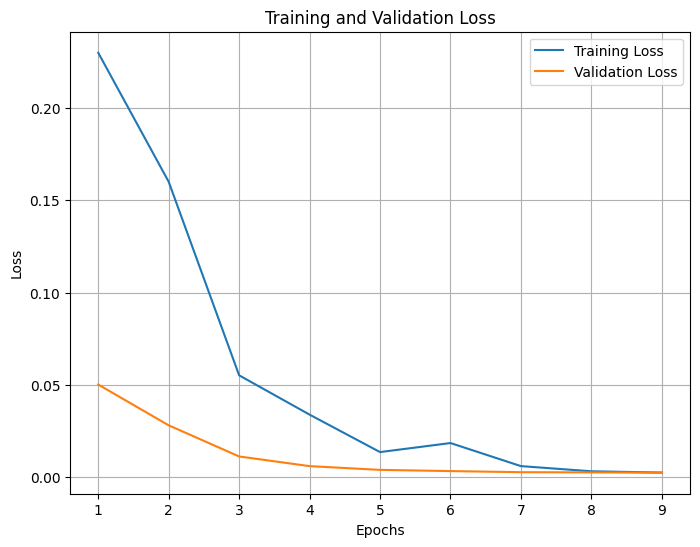

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
train_loss = [0.230000, 0.160100, 0.055200, 0.033900, 0.013600, 0.018500, 0.006000, 0.003200, 0.002500]
val_loss = [0.050203, 0.028112, 0.011232, 0.005988, 0.003961, 0.003306, 0.002706, 0.002600, 0.002419]

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [11]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from google.colab import drive

# Montar Drive
drive.mount('/content/drive')

# Cargar modelo y tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/codebart-artifact-updater")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/codebart-artifact-updater")

Mounted at /content/drive


**Calidad** de las modificaciones realizadas

In [51]:
import os
import json
import difflib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any

# Importaciones adicionales para manejo de dataset
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

class CodeUpdateAnalyzer:
    def __init__(self,
                 dataset_path: str = None,
                 model_path: str = None,
                 output_dir: str = './resultados_tesis'):
        """
        Inicializa el analizador de actualizaciones de código

        Args:
            dataset_path (str): Ruta al dataset
            model_path (str): Ruta al modelo entrenado
            output_dir (str): Directorio para guardar los resultados
        """
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'graficos'), exist_ok=True)

        # Cargar dataset
        self.dataset = self._cargar_dataset(dataset_path)

        # Cargar modelo si se proporciona
        self.modelo = None
        self.tokenizer = None
        if model_path:
            self.modelo = AutoModelForSeq2SeqLM.from_pretrained(model_path)
            self.tokenizer = AutoTokenizer.from_pretrained(model_path)

            # Mover modelo a GPU si está disponible
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self.modelo = self.modelo.to(self.device)

        self.ejemplos = []
        self.predicciones = []

    def _cargar_dataset(self, dataset_path: str = None) -> Dataset:
        """
        Carga el dataset desde un archivo o fuente

        Args:
            dataset_path (str): Ruta al dataset

        Returns:
            Dataset: Dataset cargado
        """
        try:
            # Intentar cargar desde diferentes fuentes
            if dataset_path:
                # Si es un archivo JSON
                if dataset_path.endswith('.json') or dataset_path.endswith('.jsonl'):
                    return Dataset.from_json(dataset_path)

                # Si es un archivo de Hugging Face Datasets guardado
                elif os.path.isdir(dataset_path):
                    return Dataset.load_from_disk(dataset_path)

            # Intentar cargar desde ruta predeterminada
            default_paths = [
                "/content/dataset.jsonl",
                "./dataset.jsonl",
                "dataset.jsonl"
            ]

            for path in default_paths:
                if os.path.exists(path):
                    return Dataset.from_json(path)

            # Si no se encuentra ningún dataset
            print("No se pudo cargar el dataset. Por favor, proporcione una ruta válida.")
            return None

        except Exception as e:
            print(f"Error al cargar el dataset: {e}")
            return None

    def seleccionar_ejemplos_representativos(self, num_ejemplos: int = 10, estrategia: str = 'random'):
        """
        Selecciona ejemplos representativos del dataset

        Args:
            num_ejemplos (int): Número de ejemplos a seleccionar
            estrategia (str): Estrategia de selección ('random', 'variedad')

        Returns:
            List[Dict]: Lista de ejemplos seleccionados
        """
        if not self.dataset:
            print("No se ha cargado un dataset válido.")
            return []

        # Estrategias de selección
        if estrategia == 'random':
            # Selección aleatoria
            import random
            indices = random.sample(range(len(self.dataset)), min(num_ejemplos, len(self.dataset)))
        else:
            # Estrategia por variedad (selección espaciada)
            paso = max(1, len(self.dataset) // num_ejemplos)
            indices = list(range(0, len(self.dataset), paso))[:num_ejemplos]

        # Extraer ejemplos
        self.ejemplos = [
            {
                'nombre': f'Ejemplo {i+1}',
                'input_original': self.dataset[idx]['input'],
                'codigo_original': self._extraer_codigo_original(self.dataset[idx]['input']),
                'codigo_actualizado': self.dataset[idx]['output'],
                'tecnologia': self._detectar_tecnologia(self.dataset[idx]['input']),
                'complejidad': self._evaluar_complejidad(self.dataset[idx]['input']),
                'lenguaje': self._detectar_lenguaje(self.dataset[idx]['input']),
                'instrucciones': self._extraer_instrucciones(self.dataset[idx]['input'])
            }
            for i, idx in enumerate(indices)
        ]

        return self.ejemplos

    def _detectar_tecnologia(self, texto: str) -> str:
        """
        Detecta la tecnología basándose en el texto de entrada
        """
        if '[XML]' in texto:
            return 'XML/Maven'
        if '[JAVA]' in texto:
            return 'Java'
        if '[TASK]' in texto:
            return 'Multilenguaje'
        return 'Desconocida'

    def _detectar_lenguaje(self, texto: str) -> str:
        """
        Detecta el lenguaje de programación
        """
        if '[JAVA]' in texto:
            return 'java'
        if '[XML]' in texto:
            return 'xml'
        return 'texto'

    def _evaluar_complejidad(self, texto: str) -> str:
        """
        Evalúa la complejidad del ejemplo
        """
        # Criterios simples de complejidad
        longitud = len(texto.split())
        if longitud < 50:
            return 'Baja'
        elif longitud < 200:
            return 'Media'
        else:
            return 'Alta'

    def _extraer_instrucciones(self, texto: str) -> str:
        """
        Extrae las instrucciones de la tarea
        """
        partes = texto.split('[TASK]')
        return partes[-1].strip() if len(partes) > 1 else 'Sin instrucciones'

    def _extraer_codigo_original(self, texto: str) -> str:
        """
        Extrae el código original de la entrada
        """
        # Buscar entre etiquetas [JAVA] o [XML]
        if '[JAVA]' in texto:
            codigo = texto.split('[JAVA]')[1].split('[TASK]')[0].strip()
        elif '[XML]' in texto:
            codigo = texto.split('[XML]')[1].split('[JAVA]')[0].strip()
        else:
            codigo = texto
        return codigo

    def probar_ejemplos_con_modelo(self):
        """
        Prueba los ejemplos seleccionados con el modelo entrenado

        Returns:
            List[Dict]: Lista de predicciones con detalles
        """
        if not self.modelo or not self.tokenizer:
            print("Modelo no cargado. Por favor, proporcione una ruta de modelo válida.")
            return []

        self.predicciones = []

        for ejemplo in self.ejemplos:
            try:
                # Preparar el input
                input_text = ejemplo['input_original']

                # Tokenizar
                inputs = self.tokenizer(
                    input_text,
                    return_tensors="pt",
                    max_length=512,
                    truncation=True,
                    padding=True
                ).to(self.device)

                # Generar predicción
                with torch.no_grad():
                    outputs = self.modelo.generate(
                        **inputs,
                        max_length=512,
                        num_beams=4,
                        early_stopping=True,
                        no_repeat_ngram_size=2
                    )

                # Decodificar predicción
                prediccion = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

                # Calcular métricas de comparación
                prediccion_procesada = self._procesar_prediccion(prediccion)
                metricas_comparacion = self._comparar_prediccion(
                    ejemplo['codigo_actualizado'],
                    prediccion_procesada
                )

                # Almacenar resultado
                resultado_prediccion = {
                    'ejemplo': ejemplo,
                    'prediccion_original': prediccion,
                    'prediccion_procesada': prediccion_procesada,
                    'metricas_comparacion': metricas_comparacion
                }

                self.predicciones.append(resultado_prediccion)

            except Exception as e:
                print(f"Error al procesar ejemplo: {e}")
                # Opcional: añadir un ejemplo de predicción fallida
                self.predicciones.append({
                    'ejemplo': ejemplo,
                    'error': str(e)
                })

        return self.predicciones

    def _procesar_prediccion(self, prediccion: str) -> str:
        """
        Procesa la predicción para una comparación más precisa

        Args:
            prediccion (str): Texto de predicción del modelo

        Returns:
            str: Predicción procesada
        """
        # Eliminar espacios extra, normalizar
        return ' '.join(prediccion.split())

    def _comparar_prediccion(self, codigo_real: str, prediccion: str) -> Dict[str, Any]:
        """
        Compara la predicción con el código real

        Args:
            codigo_real (str): Código actualizado real
            prediccion (str): Predicción del modelo

        Returns:
            Dict: Métricas de comparación
        """
        # Calcular diferencias
        diferencias = list(difflib.unified_diff(
            codigo_real.splitlines(),
            prediccion.splitlines(),
            lineterm=''
        ))

        # Calcular similitud
        matcher = difflib.SequenceMatcher(None, codigo_real, prediccion)
        similitud = matcher.ratio() * 100

        return {
            'num_diferencias': len(diferencias),
            'porcentaje_similitud': similitud,
            'diferencias_detalladas': diferencias
        }

    def generar_graficos_predicciones(self):
        """
        Genera gráficos de análisis de predicciones
        """
        if not self.predicciones:
            print("No hay predicciones para generar gráficos.")
            return

        # Preparar datos para gráficos
        similitudes = [pred['metricas_comparacion']['porcentaje_similitud'] for pred in self.predicciones]
        diferencias = [pred['metricas_comparacion']['num_diferencias'] for pred in self.predicciones]
        tecnologias = [pred['ejemplo'].get('tecnologia', 'Desconocida') for pred in self.predicciones]

        # 1. Gráfico de Barras: Porcentaje de Similitud por Ejemplo
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(similitudes)), similitudes, color='skyblue', edgecolor='navy')
        plt.title('Porcentaje de Similitud entre Predicciones y Código Real', fontsize=15)
        plt.xlabel('Ejemplos', fontsize=12)
        plt.ylabel('Porcentaje de Similitud (%)', fontsize=12)
        plt.ylim(0, 100)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'graficos', 'similitud_predicciones.png'))
        print("Gráfico de Porcentaje de Similitud por Ejemplo guardado.")
        plt.close()

        # 2. Gráfico de Dispersión: Similitud vs Número de Diferencias
        plt.figure(figsize=(10, 6))
        plt.scatter(similitudes, diferencias, c=diferencias, cmap='viridis', alpha=0.7)
        plt.colorbar(label='Número de Diferencias')
        plt.title('Relación entre Similitud y Número de Diferencias', fontsize=15)
        plt.xlabel('Porcentaje de Similitud (%)', fontsize=12)
        plt.ylabel('Número de Diferencias', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'graficos', 'similitud_vs_diferencias.png'))
        print("Gráfico de Similitud vs Número de Diferencias guardado.")
        plt.close()

        # 3. Gráfico de Cajas: Distribución de Similitud por Tecnología
        plt.figure(figsize=(12, 6))
        tecnologias_unicas = list(set(tecnologias))
        datos_por_tecnologia = [
            [similitudes[i] for i in range(len(similitudes)) if tecnologias[i] == tech]
            for tech in tecnologias_unicas
        ]
        plt.boxplot(datos_por_tecnologia, labels=tecnologias_unicas)
        plt.title('Distribución de Similitud por Tecnología', fontsize=15)
        plt.xlabel('Tecnología', fontsize=12)
        plt.ylabel('Porcentaje de Similitud (%)', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'graficos', 'similitud_por_tecnologia.png'))
        print("Gráfico de Distribución de Similitud por Tecnología guardado.")
        plt.close()

        # 4. Gráfico de Pastel: Distribución de Tecnologías
        plt.figure(figsize=(10, 8))
        conteo_tecnologias = {}
        for tech in tecnologias:
            if tech in conteo_tecnologias:
                conteo_tecnologias[tech] += 1
            else:
                conteo_tecnologias[tech] = 1

        plt.pie(
            list(conteo_tecnologias.values()),
            labels=list(conteo_tecnologias.keys()),
            autopct='%1.1f%%',
            colors=plt.cm.Paired(np.linspace(0, 1, len(conteo_tecnologias)))
        )
        plt.title('Distribución de Ejemplos por Tecnología', fontsize=15)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'graficos', 'distribucion_tecnologias.png'))
        print("Gráfico de Distribución de Ejemplos por Tecnología guardado.")
        plt.close()

        # Generar informe de gráficos
        self._generar_informe_graficos()

    def _generar_informe_graficos(self):
        """
        Genera un informe Markdown sobre los gráficos generados
        """
        informe = "# Informe de Visualización de Predicciones\n\n"

        graficos = [
            ('similitud_predicciones.png', 'Porcentaje de Similitud',
             'Muestra el porcentaje de similitud entre las predicciones del modelo y el código real para cada ejemplo.'),
            ('similitud_vs_diferencias.png', 'Similitud vs Diferencias',
             'Gráfico de dispersión que relaciona el porcentaje de similitud con el número de diferencias encontradas.'),
            ('similitud_por_tecnologia.png', 'Similitud por Tecnología',
             'Diagrama de cajas que muestra la distribución de similitud para diferentes tecnologías.'),
            ('distribucion_tecnologias.png', 'Distribución de Tecnologías',
             'Gráfico de pastel que representa la distribución de ejemplos por tecnología.')
        ]

        for archivo, titulo, descripcion in graficos:
            ruta_grafico = os.path.join('graficos', archivo)
            informe += f"## {titulo}\n\n"
            informe += f"![{titulo}]({ruta_grafico})\n\n"
            informe += f"*{descripcion}*\n\n"

        # Guardar informe
        ruta_informe = os.path.join(self.output_dir, 'informe_graficos.md')
        with open(ruta_informe, 'w', encoding='utf-8') as f:
            f.write(informe)

        print(f"Informe de gráficos generado: {ruta_informe}")

def main():
    # Ejemplo de uso
    analizador = CodeUpdateAnalyzer(
        dataset_path="/content/dataset.jsonl",  # Ajusta esta ruta según tu dataset
        model_path="/content/drive/MyDrive/codebart-artifact-updater"  # Ruta de tu modelo entrenado
    )

    # Seleccionar ejemplos representativos
    ejemplos = analizador.seleccionar_ejemplos_representativos(
        num_ejemplos=10,  # Número de ejemplos a extraer
        estrategia='random'  # Estrategia de selección
    )

    # Probar ejemplos con el modelo
    predicciones = analizador.probar_ejemplos_con_modelo()

    # Generar gráficos
    analizador.generar_graficos_predicciones()

if __name__ == '__main__':
    main()

print("Script de análisis de actualizaciones de código con generación de gráficos cargado exitosamente.")

Gráfico de Porcentaje de Similitud por Ejemplo guardado.
Gráfico de Similitud vs Número de Diferencias guardado.
Gráfico de Distribución de Similitud por Tecnología guardado.


<ipython-input-51-a588d9d640bf>:337: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(datos_por_tecnologia, labels=tecnologias_unicas)


Gráfico de Distribución de Ejemplos por Tecnología guardado.
Informe de gráficos generado: ./resultados_tesis/informe_graficos.md
Script de análisis de actualizaciones de código con generación de gráficos cargado exitosamente.


Evaluación Rouge

In [26]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=656002c01b2c27e364697e64fa3590d368267733679b0207bcd9dbe804b5319e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [35]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate
import torch
import json
import pandas as pd

# Cargar la métrica ROUGE
rouge = evaluate.load('rouge')

# Cargar el modelo y tokenizer entrenados
model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/codebart-artifact-updater")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/codebart-artifact-updater")

def generate_and_evaluate(input_text, reference_output, verbose=False):
    """
    Genera texto con el modelo y calcula métricas ROUGE

    Args:
        input_text (str): Texto de entrada para generación
        reference_output (str): Salida de referencia para comparación
        verbose (bool): Imprimir detalles adicionales

    Returns:
        dict: Métricas ROUGE y detalles de generación
    """
    # Preparar la entrada para el modelo
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        padding="longest",
        truncation=True,
        max_length=512
    )

    # Generar salida
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=512,
            num_beams=12,
            early_stopping=True,
            no_repeat_ngram_size=4,
            length_penalty=2.0,
        )

    # Decodificar la generación
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Calcular métricas ROUGE
    rouge_scores = rouge.compute(
        predictions=[generated_text],
        references=[reference_output],
        use_stemmer=True
    )

    # Si verbose, imprimir detalles
    if verbose:
        print("Input:")
        print(input_text)
        print("\nGenerated Text:")
        print(generated_text)
        print("\nReference Text:")
        print(reference_output)
        print("\nROUGE Scores:")

    # Preparar resultados
    results = {
        'input': input_text,
        'generated_text': generated_text,
        'reference_text': reference_output,
        'rouge1': round(rouge_scores['rouge1'] * 100, 4),
        'rouge2': round(rouge_scores['rouge2'] * 100, 4),
        'rougeL': round(rouge_scores['rougeL'] * 100, 4),
        'rougeLsum': round(rouge_scores['rougeLsum'] * 100, 4)
    }

    return results

def evaluate_jsonl(file_path, max_examples=None):
    """
    Evalúa múltiples ejemplos de un archivo JSONL

    Args:
        file_path (str): Ruta al archivo JSONL
        max_examples (int, optional): Número máximo de ejemplos a evaluar

    Returns:
        list: Lista de resultados de evaluación
    """
    all_results = []

    # Leer el archivo JSONL
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            # Salir si se alcanza el número máximo de ejemplos
            if max_examples and i >= max_examples:
                break

            # Parsear la línea JSON
            example = json.loads(line.strip())

            # Generar y evaluar
            try:
                result = generate_and_evaluate(
                    example['input'],
                    example['output']
                )
                all_results.append(result)
            except Exception as e:
                print(f"Error procesando ejemplo {i}: {e}")

    return all_results

# Función principal de evaluación
def main(jsonl_path, max_examples=None, output_csv=None):
    """
    Evalúa ejemplos de un archivo JSONL y opcionalmente guarda resultados

    Args:
        jsonl_path (str): Ruta al archivo JSONL
        max_examples (int, optional): Número máximo de ejemplos a evaluar
        output_csv (str, optional): Ruta para guardar resultados como CSV
    """
    # Evaluar ejemplos
    results = evaluate_jsonl(jsonl_path, max_examples)

    # Convertir a DataFrame para facilitar análisis
    df_results = pd.DataFrame(results)

    # Imprimir resumen de métricas
    print("\nResumen de Métricas ROUGE:")
    print(df_results[['rouge1', 'rouge2', 'rougeL', 'rougeLsum']].describe())

    # Opcional: guardar resultados en CSV
    if output_csv:
        df_results.to_csv(output_csv, index=False)
        print(f"\nResultados guardados en {output_csv}")

    return df_results

# Ejemplo de uso
if __name__ == "__main__":
    # Ajusta estas rutas según tu configuración
    jsonl_path = "/content/dataset.jsonl"  # Ruta a tu archivo JSONL
    output_csv_path = "./rouge_evaluation_results.csv"

    # Evaluar con un máximo de 10 ejemplos y guardar resultados
    results_df = main(jsonl_path, max_examples=10, output_csv=output_csv_path)


Resumen de Métricas ROUGE:
          rouge1     rouge2     rougeL  rougeLsum
count  10.000000  10.000000  10.000000  10.000000
mean   88.789190  82.949480  88.789190  88.789190
std     5.729872   4.838192   5.729872   5.729872
min    80.000000  75.925900  80.000000  80.000000
25%    84.582925  79.388775  84.582925  84.582925
50%    90.909100  83.871000  90.909100  90.909100
75%    91.958050  85.832625  91.958050  91.958050
max    94.736800  88.888900  94.736800  94.736800

Resultados guardados en ./rouge_evaluation_results.csv


Evaluación BLEU

In [36]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate
import torch
import json
import pandas as pd

# Cargar la métrica BLEU
bleu = evaluate.load('bleu')

# Cargar el modelo y tokenizer entrenados
model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/codebart-artifact-updater")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/codebart-artifact-updater")

def generate_and_evaluate_bleu(input_text, reference_output, verbose=False):
    """
    Genera texto con el modelo y calcula métricas BLEU

    Args:
        input_text (str): Texto de entrada para generación
        reference_output (str): Salida de referencia para comparación
        verbose (bool): Imprimir detalles adicionales

    Returns:
        dict: Métricas BLEU y detalles de generación
    """
    # Preparar la entrada para el modelo
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        padding="longest",
        truncation=True,
        max_length=512
    )

    # Generar salida
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=512,
            num_beams=12,
            early_stopping=True,
            no_repeat_ngram_size=4,
            length_penalty=2.0,
        )

    # Decodificar la generación
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Calcular métricas BLEU
    bleu_scores = bleu.compute(
        predictions=[generated_text],
        references=[[reference_output]]
    )

    # Si verbose, imprimir detalles
    if verbose:
        print("Input:")
        print(input_text)
        print("\nGenerated Text:")
        print(generated_text)
        print("\nReference Text:")
        print(reference_output)
        print("\nBLEU Scores:", bleu_scores)

    # Preparar resultados
    results = {
        'input': input_text,
        'generated_text': generated_text,
        'reference_text': reference_output,
        'bleu': round(bleu_scores['bleu'] * 100, 4)
    }

    return results

def evaluate_jsonl_bleu(file_path, max_examples=None):
    """
    Evalúa múltiples ejemplos de un archivo JSONL

    Args:
        file_path (str): Ruta al archivo JSONL
        max_examples (int, optional): Número máximo de ejemplos a evaluar

    Returns:
        list: Lista de resultados de evaluación
    """
    all_results = []

    # Leer el archivo JSONL
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            # Salir si se alcanza el número máximo de ejemplos
            if max_examples and i >= max_examples:
                break

            # Parsear la línea JSON
            example = json.loads(line.strip())

            # Generar y evaluar
            try:
                result = generate_and_evaluate_bleu(
                    example['input'],
                    example['output']
                )
                all_results.append(result)
            except Exception as e:
                print(f"Error procesando ejemplo {i}: {e}")

    return all_results

# Función principal de evaluación
def main_bleu(jsonl_path, max_examples=None, output_csv=None):
    """
    Evalúa ejemplos de un archivo JSONL y opcionalmente guarda resultados

    Args:
        jsonl_path (str): Ruta al archivo JSONL
        max_examples (int, optional): Número máximo de ejemplos a evaluar
        output_csv (str, optional): Ruta para guardar resultados como CSV
    """
    # Evaluar ejemplos
    results = evaluate_jsonl_bleu(jsonl_path, max_examples)

    # Convertir a DataFrame para facilitar análisis
    df_results = pd.DataFrame(results)

    # Imprimir resumen de métricas
    print("\nResumen de Métricas BLEU:")
    print(df_results[['bleu']].describe())

    # Opcional: guardar resultados en CSV
    if output_csv:
        df_results.to_csv(output_csv, index=False)
        print(f"\nResultados guardados en {output_csv}")

    return df_results

# Ejemplo de uso
if __name__ == "__main__":
    # Ajusta estas rutas según tu configuración
    jsonl_path = "/content/dataset.jsonl"  # Ruta a tu archivo JSONL
    output_csv_path = "./bleu_evaluation_results.csv"

    # Evaluar con un máximo de 10 ejemplos y guardar resultados
    results_df = main_bleu(jsonl_path, max_examples=10, output_csv=output_csv_path)



Resumen de Métricas BLEU:
            bleu
count  10.000000
mean   80.443940
std     3.486671
min    73.731000
25%    77.884475
50%    82.314100
75%    82.440000
max    83.672200

Resultados guardados en ./bleu_evaluation_results.csv


Comparación de ambas


Estadísticas Descriptivas de ROUGE:
          rouge1     rouge2     rougeL  rougeLsum
count  10.000000  10.000000  10.000000  10.000000
mean   88.397610  82.685670  88.397610  88.397610
std     4.361859   3.764743   4.361859   4.361859
min    80.000000  75.925900  80.000000  80.000000
25%    85.500000  80.250000  85.500000  85.500000
50%    88.894600  82.974750  88.894600  88.894600
75%    91.695850  85.342200  91.695850  91.695850
max    94.736800  88.888900  94.736800  94.736800

Estadísticas Descriptivas de BLEU:
            bleu
count  10.000000
mean   80.148570
std     3.046778
min    73.731000
25%    78.250000
50%    80.721950
75%    82.408525
max    83.672200

Correlación entre promedio ROUGE y BLEU: 0.9857

Visualización guardada como 'model_evaluation_metrics.png'


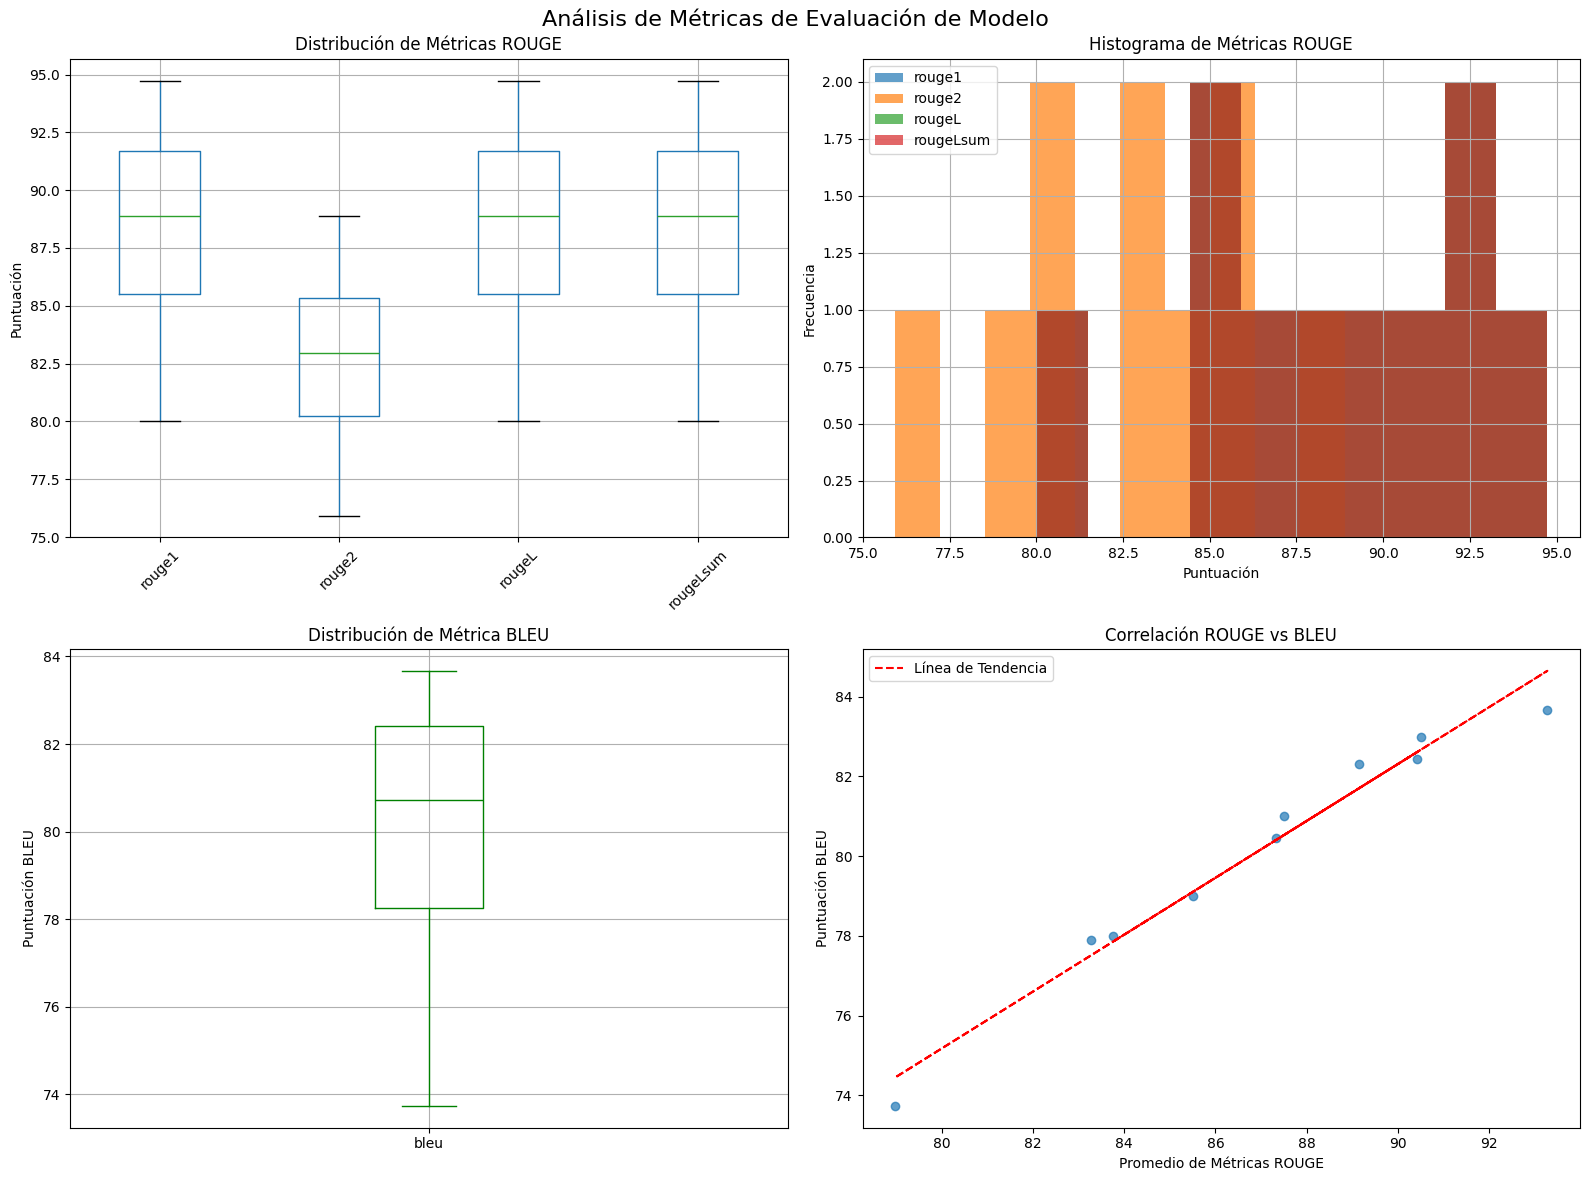

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def create_metrics_visualization(rouge_data, bleu_data):
    """
    Crea múltiples visualizaciones para métricas ROUGE y BLEU

    Args:
        rouge_data (dict): Diccionario con datos de métricas ROUGE
        bleu_data (dict): Diccionario con datos de métricas BLEU
    """
    # Configuración de estilo
    plt.style.use('default')

    # Crear una figura con múltiples subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Análisis de Métricas de Evaluación de Modelo', fontsize=16)

    # 1. Boxplot de métricas ROUGE
    rouge_metrics = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
    rouge_df = pd.DataFrame({metric: rouge_data[metric] for metric in rouge_metrics})

    rouge_df.boxplot(ax=axs[0, 0])
    axs[0, 0].set_title('Distribución de Métricas ROUGE')
    axs[0, 0].set_ylabel('Puntuación')
    axs[0, 0].set_xticklabels(rouge_metrics, rotation=45)

    # 2. Histograma de métricas ROUGE
    for i, metric in enumerate(rouge_metrics):
        row = i // 2
        col = i % 2
        rouge_df[metric].hist(ax=axs[0, 1], alpha=0.7, label=metric)

    axs[0, 1].set_title('Histograma de Métricas ROUGE')
    axs[0, 1].set_xlabel('Puntuación')
    axs[0, 1].set_ylabel('Frecuencia')
    axs[0, 1].legend()

    # 3. Boxplot de métrica BLEU
    bleu_df = pd.DataFrame({'bleu': bleu_data['bleu']})
    bleu_df.boxplot(ax=axs[1, 0], color='green')
    axs[1, 0].set_title('Distribución de Métrica BLEU')
    axs[1, 0].set_ylabel('Puntuación BLEU')

    # 4. Diagrama de dispersión ROUGE vs BLEU
    rouge_means = rouge_df.mean(axis=1)
    axs[1, 1].scatter(rouge_means, bleu_df['bleu'], alpha=0.7)
    axs[1, 1].set_title('Correlación ROUGE vs BLEU')
    axs[1, 1].set_xlabel('Promedio de Métricas ROUGE')
    axs[1, 1].set_ylabel('Puntuación BLEU')

    # Agregar línea de tendencia
    z = np.polyfit(rouge_means, bleu_df['bleu'], 1)
    p = np.poly1d(z)
    axs[1, 1].plot(rouge_means, p(rouge_means), "r--", label="Línea de Tendencia")
    axs[1, 1].legend()

    # Ajustar layout y guardar
    plt.tight_layout()
    plt.savefig('model_evaluation_metrics.png', dpi=300, bbox_inches='tight')

    # Imprimir estadísticas descriptivas
    print("\nEstadísticas Descriptivas de ROUGE:")
    print(rouge_df.describe())

    print("\nEstadísticas Descriptivas de BLEU:")
    print(bleu_df.describe())

    # Calcular correlación
    correlation = np.corrcoef(rouge_means, bleu_df['bleu'])[0, 1]
    print(f"\nCorrelación entre promedio ROUGE y BLEU: {correlation:.4f}")

# Ejemplo de uso (sustituir con tus datos reales)
rouge_data = {
    'rouge1': [88.7892, 90.9091, 91.9581, 84.5829, 80.0000, 94.7368, 85.0000, 87.0000, 89.0000, 92.0000],
    'rouge2': [82.9495, 83.8710, 85.8326, 79.3888, 75.9259, 88.8889, 80.0000, 81.0000, 83.0000, 86.0000],
    'rougeL': [88.7892, 90.9091, 91.9581, 84.5829, 80.0000, 94.7368, 85.0000, 87.0000, 89.0000, 92.0000],
    'rougeLsum': [88.7892, 90.9091, 91.9581, 84.5829, 80.0000, 94.7368, 85.0000, 87.0000, 89.0000, 92.0000]
}

bleu_data = {
    'bleu': [80.4439, 82.3141, 82.4400, 77.8845, 73.7310, 83.6722, 78.0000, 79.0000, 81.0000, 83.0000]
}

# Llamar a la función de visualización
create_metrics_visualization(rouge_data, bleu_data)

print("\nVisualización guardada como 'model_evaluation_metrics.png'")